# Script for analysis of insertion patterns of transposons


In [1]:
import pandas as pd
import hicstraw
import pyBigWig
import matplotlib
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.metrics.pairwise import euclidean_distances

from collections import Counter
import pickle

# Load in transposon data

Detection of Transposons in genome:

repeat masker from UCSC:

https://genome.ucsc.edu/cgi-bin/hgTrackUi?g=rmsk


https://genome.ucsc.edu/cgi-bin/hgTables?hgta_doMainPage=1&hgta_group=varRep&hgta_track=rmsk&hgta_table=rmsk&hgsid=1409663405_4aL7oZASpQ7rZ6grjKWGJNHJPUAe&source=post_page-----2b32f6b67364--------------------------------


uses data from repeatmasker:
https://www.repeatmasker.org/genomicDatasets/RMGenomicDatasets.html


#Alternative names of chromosomes:
https://genome.ucsc.edu/FAQ/FAQdownloads.html#downloadAlt

"The chr_alt chromosomes, such as chr5_KI270794v1_alt, are alternative sequences that differ from the reference genome currently available..."

"The chr_fix chromosomes, such as chr1_KN538361v1_fix, are fix patches currently available for the mm10, hg19, and hg38 assemblies that represent changes to the existing sequence..."


"ChrUn contains clone contigs that cannot be confidently placed on a specific chromosome..."


"ChrN_random: ...data related to sequence that is known to be in a particular chromosome, but could not be reliably ordered within the current sequence..."

"What is chromosome M (chrM)? "Mitochondrial DNA.

etc...



Annotation of Lines https://www.repeatmasker.org/faq.html:
Since LINE copies tend to be 5' truncated, full-length models of the detailed subfamily structure apparent in the well-represented and fast-evolving 3' end are difficult to obtain. Rather than comparing the query to a large number of full-length (6-8 kb) consensus sequences that are identical except for the very 3' end, we often fragment LINE models into domains (e.g. 5' end, ORF2-region, and 3' end) which are transparently merged in the RepeatMasker annotation as if the matching was done to a full-length consensus. Our nomenclature and fragmentation thus create a many-to-one relationship with Repbase full-length entries. 


https://www.animalgenome.org/bioinfo/resources/manuals/RepeatMasker.html

In [2]:
#repeat masker files
fields_sel=["genoName","genoStart","genoEnd","repName","repClass","repFamily"]
rmd_3=pd.read_csv("Transposon_analysis_1/hg19_all_fields_repeat_masker",sep="\t",header = 0,usecols=fields_sel)



In [3]:
rmd_3 #[rmd_3["repFamily"]=="DNA"]

genoName  genoStart   genoEnd     repName repClass  \
0                         chr1   16777160  16777470       AluSp     SINE   
1                         chr1   25165800  25166089        AluY     SINE   
2                         chr1   33553606  33554646         L2b     LINE   
3                         chr1   50330063  50332153      L1PA10     LINE   
4                         chr1   58720067  58720973       L1PA2     LINE   
...                        ...        ...       ...         ...      ...   
5481336  chr21_gl000210_random      25378     25875      MER74B      LTR   
5481337  chr21_gl000210_random      26437     26596        MIRc     SINE   
5481338  chr21_gl000210_random      26881     27022        MIRc     SINE   
5481339  chr21_gl000210_random      27296     27447  HAL1-2a_MD     LINE   
5481340  chr21_gl000210_random      27468     27682  HAL1-2a_MD     LINE   

        repFamily  
0             Alu  
1             Alu  
2              L2  
3              L1  
4              L1  
...           ...  
5481336      ERVL  
5481337       MIR  
5481338       MIR  
5481339        L1  
5481340        L1  

[5481341 rows x 6 columns]

In [4]:
#load de-novo insertions
#fields_sel_de_novo=["genoName","genoStart","genoEnd"]

#rmd_3=pd.read_csv("Transposon_analysis_1/L1_neo_pos.txt",sep="\t",header = None, names=fields_sel_de_novo)

#rmd_3["repName"]="L1"

#rmd_3

In [5]:
#Names of sub-families
unique_v3 = [rmd_3[col_name].unique() for col_name in rmd_3.columns]

for i in unique_v3[3]:
    print(i)

AluSp
AluY
L2b
L1PA10
L1PA2
L1MB7
ERVL-E-int
L2a
L1ME1
L1PA7
L1PA3
AluSq2
HSMAR2
MLT1J
MIRb
THE1B
AluSx1
MER58A
LTR12C
MIR3
L1ME2
L3
AluSc
L2
AluJb
L1MEc
Charlie1b
AluSx
MIRc
MER21C
AluSx4
L4
L1MA9
AT_rich
L2c
L1MB3
THE1B-int
MER58B
AluJr
MamRep1527
MIR
THE1D
SVA_D
FRAM
AluSg
LTR47B
L1PA8A
AluJo
MER6B
LTR76
L1PA6
LTR85c
L1M2
Mam_R4
HAL1
L1PA14
AluSz
L1MA10
L1M1
(CA)n
L1ME3
L1PBa
L1PA15-16
MLT2B4
MER21A
MLT1F2
L1M4
AluSc8
Arthur1
L1MDa
MLT1M
LTR24C
MER65D
Charlie25
MLT1B
HERVH-int
MER58D
L1MC4
L1ME4a
Tigger3a
L1MB8
MER20
(CAAAA)n
MER52-int
HERVK-int
LTR7B
MLT1H
LTR37A
(TA)n
LTR38B
MER39
MLT1A0
MER11C
L1MC
LTR7C
MER5B
AluSz6
MER53
AluSx3
SVA_F
MLT1L
GA-rich
L1M3
MER41B
Tigger1
(GAA)n
L1MC1
MLT1I
L1PA5
L1PA4
LTR33
MER33
L1MC3
FLAM_C
AluJr4
L1M5
Harlequin-int
L1PA15
LTR16A
L1MA1
MER41-int
L1PA17
L1PB4
L1M4b
L1PB1
L1PA13
L1MB1
HERVI-int
MLT1E1A
MLT1C
MER82
MamGypLTR1b
L1MA7
LTR85a
L1MB2
L1PA8
MLT2A1
MLT1J1-int
L1P1
LTR16A1
MER31-int
LTR1B
(TG)n
THE1A-int
MLT1D
HERVL32-int
L1MA3
ERVL-B4-int


# Load subset of repeat masker data, sub-family positions, on each chromosome

## Functions

In [6]:
#function to select repetitive elements
def sel_rep_element_on_chr(rmd_1,chr_list,elements_name):
    rmd_list=[]
    for i in range(len(chr_list)):
        rmd_chrx=rmd_1[rmd_1[0]==chr_list[i]]
        if elements_name!=None:
            rmd_chrx_sel=rmd_chrx[rmd_chrx.iloc[:,3].str.startswith(elements_name)]
            rmd_list.append(rmd_chrx_sel)
        if elements_name==None:
            rmd_list.append(rmd_chrx)
    return rmd_list

def sel_rep_element_on_chr_2(rmd_1,chr_list,elements_name,chr_col_name,element_col_name):
    rmd_list=[]
    for i in range(len(chr_list)):
        rmd_chrx=rmd_1[rmd_1[chr_col_name]==chr_list[i]]
        if elements_name!=None:
            rmd_chrx_sel=rmd_chrx[rmd_chrx[element_col_name].str.fullmatch(elements_name)]
            rmd_list.append(rmd_chrx_sel)
        if elements_name==None:
            rmd_list.append(rmd_chrx)
    return rmd_list


##################
##################

#get positions and length of elements
def positions_elements_2_b(rmd_input):
    #rmd_input: repeat masker file with positions from only one chr
    #get position middle of element on chr:
    pos=[]
    len_element=[]
    for i in range(len(rmd_input)):
        len_1=rmd_input[i:i+1]["genoEnd"].to_numpy()[0]-rmd_input[i:i+1]["genoStart"].to_numpy()[0]
        pos_1=rmd_input[i:i+1]["genoStart"].to_numpy()[0] + 0.5*len_1
        
        pos.append(pos_1)
        len_element.append(len_1)
    return np.asarray(pos), np.asarray(len_element)

#get positions and lengths of elements and pariwise distances for each entry in chr_list, and same for random positions
def get_pos_dist_2(chr_list,rmd_list):
    #list of positions
    pos_x_list=[]
    #list of lengths
    len_x_list=[]
    #list of uniformly distributed positions
    pos_rd_x_list=[]

    #list of pairwise distances in each chromosome
    dist_x_list=[]
    #list of pairwise distances from uniformly distributed elements
    dist_rd_x_list=[]
    for i in range(len(chr_list)):
        #print(chr_list[i])
        positions_elements_x,lenghts_elements_x=positions_elements_2_b(rmd_list[i])
        pos_x_list.append(positions_elements_x)
        len_x_list.append(lenghts_elements_x)
        
        '''dist_x = np.empty((len(positions_elements_x),len(positions_elements_x)))
        for i in range(len(positions_elements_x)):
            dist_x[i, :] = ((positions_elements_x.reshape(-1,1)-positions_elements_x.reshape(-1,1)[i])**2).sum(axis=1)**0.5
            
        dist_x=dist_x[np.triu_indices(len(positions_elements_x),k=1)]'''
        #return D
        dist_x=scipy.spatial.distance.pdist(positions_elements_x.reshape(-1,1),metric='euclidean')
        #dist_x=euclidean_distances(positions_elements_x.reshape(-1,1),positions_elements_x.reshape(-1,1))[np.triu_indices(len(positions_elements_x),k=1)]
        dist_x_list.append(np.asarray(dist_x) )

        #uniformly distributed positions in intervall [min_pos, max_pos], number =  number of elements on chr. from rep. masker subset
        positions_random_x=np.random.choice(np.arange(np.min(positions_elements_x),np.max(positions_elements_x),step=0.5),size=len(positions_elements_x))
        '''dist_rd_x = np.empty((len(positions_random_x),len(positions_random_x)))
        for i in range(len(positions_random_x)):
            dist_rd_x[i, :] = ((positions_random_x.reshape(-1,1)-positions_random_x.reshape(-1,1)[i])**2).sum(axis=1)**0.5
            
        dist_rd_x=dist_rd_x[np.triu_indices(len(positions_random_x),k=1)]'''
        pos_rd_x_list.append(positions_random_x)
        dist_rd_x=scipy.spatial.distance.pdist(positions_random_x.reshape(-1,1),metric='euclidean')
        #dist_rd_x=euclidean_distances(positions_random_x.reshape(-1,1),positions_random_x.reshape(-1,1))[np.triu_indices(len(positions_random_x),k=1)]

        dist_rd_x_list.append(np.asarray(dist_rd_x))
    return pos_x_list,len_x_list, pos_rd_x_list, dist_x_list, dist_rd_x_list

## Load data

In [7]:
#split read-in into chromosomes
#no chrY to compare to HeLa cells
chr_list_3=["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15","chr16",
         "chr17","chr18","chr19","chr20","chr21","chr22","chrX"
         ]
#select the sub-family for analysis
element_sel_3="L1ME1" #"MamRep1527"  #"MamRep1527" #"L1ME1" #"AluSp"



In [8]:
#annotation for sub-family elements, split into chromosomes
rmd_list_3= sel_rep_element_on_chr_2(rmd_1=rmd_3,chr_list=chr_list_3,elements_name=element_sel_3,chr_col_name="genoName",element_col_name="repName")

In [9]:
rmd_list_3

[       genoName  genoStart    genoEnd repName repClass repFamily
 8          chr1  117440426  117440514   L1ME1     LINE        L1
 9          chr1  117440494  117441457   L1ME1     LINE        L1
 62         chr1  114294558  114295009   L1ME1     LINE        L1
 63         chr1  116391804  116391994   L1ME1     LINE        L1
 103        chr1  216004377  216007947   L1ME1     LINE        L1
 ...         ...        ...        ...     ...      ...       ...
 431113     chr1  247939643  247940146   L1ME1     LINE        L1
 431117     chr1  247941299  247941531   L1ME1     LINE        L1
 431120     chr1  247943689  247943971   L1ME1     LINE        L1
 431122     chr1  247944179  247944276   L1ME1     LINE        L1
 432651     chr1  249126262  249126531   L1ME1     LINE        L1
 
 [2527 rows x 6 columns],
        genoName  genoStart    genoEnd repName repClass repFamily
 432872     chr2    4194280    4195111   L1ME1     LINE        L1
 432949     chr2  191889374  191889503   L1ME1  

In [10]:
#get total number of elements
len_rmd_list_3=0
for i in range(len(rmd_list_3)):
    len_rmd_list_3=len_rmd_list_3+len(rmd_list_3[i])
print("Total number of elements loaded:",len_rmd_list_3)

Total number of elements loaded: 31377


In [11]:
#get centre position and lengths of elements and control elements placed randomly from uniform distribution
pos_x_list_3,len_x_list_3, pos_rd_x_list_3, dist_x_list_3, dist_rd_x_list_3 = get_pos_dist_2(chr_list=chr_list_3,rmd_list=rmd_list_3)

# Probability density of pairwise distances from uniformly distributed positions

Pairwise distance of x from 2 points on a 1D domain of lenth L:

First point has to be within L-x from boundary, as distance x would not fit in 1D domain with length L otherwise.
prob first point ~ (L-x)/L

Probability to find second point such that pairwise distance is x, is ~1/L, as each point is equally likely.
prob second point ~1/L

Multiply and add normalization 1/N:

p= (L-x)/L^2 * 1/N

Integration has to be one-> N=2

p= 2*(L-x)/L^2

In [12]:
def distr_1(L,x):
    return 2/L**2 * (L-x) 

Integration of pdf= 1.0


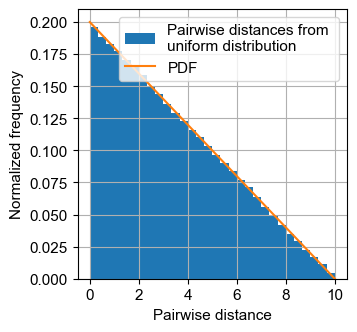

In [13]:
#test distribution
#uniformly distributed points on 1D line
interval_test=np.arange(0,10,step=0.001) #np.arange(0,1000,step=0.1)
random_pos_test=np.random.choice(interval_test,size=5000)

#resulting pairwise distances
dist_random_pos_test=scipy.spatial.distance.pdist(random_pos_test.reshape(-1,1),metric='euclidean')


#integration
int2=scipy.integrate.trapezoid(distr_1(np.max(interval_test),interval_test),interval_test)

print("Integration of pdf=",int2)

fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)
hist_dist_1=ax1.hist(dist_random_pos_test,bins=30,label="Pairwise distances from \nuniform distribution",density=True)
ax1.errorbar(interval_test,distr_1(np.max(interval_test),interval_test),label="PDF")


plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
plt.ylabel("Normalized frequency",fontname = "Arial",fontsize=11)
plt.xlabel("Pairwise distance",fontname = "Arial",fontsize=11)
plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
#plt.yscale("log")
#plt.xscale("log")
ax1.set_aspect(1./ax1.get_data_ratio())

#plt.savefig("Transposon_analysis_1/figures/pairwise_distances_uniform_points_log_1.png",format="png",bbox_inches="tight",dpi=300)

 Mean and Std of distribution:

Mean: L/3

Std: L/sqrt(18)

In [14]:
print("Mean samples:",np.mean(dist_random_pos_test), "Mean Pdf: ",np.max(interval_test)/3)
print("Std samples:",np.std(dist_random_pos_test), "Std Pdf: ",np.max(interval_test)/np.sqrt(18))

Mean samples: 3.3291724342468503 Mean Pdf:  3.333
Std samples: 2.354014901268353 Std Pdf:  2.3567869016947633


# Pairwise distances 

## Functions

In [15]:
#plot pairwise distances
def pairwise_dist_hist_1(chr_list,dist_x_list,dist_rd_x_list):
    
    for i in range(len(chr_list[:])):
        print(chr_list[i])
        dist_x=dist_x_list[i]


        dist_rd_x=dist_rd_x_list[i]



        fig=plt.figure(figsize=(3.5,3.5))
        ax1 = fig.add_subplot(111)


        hist_dist_b_3=ax1.hist([dist_x,dist_rd_x],bins=40,label=["Rep. elements","Uniform insertions"],density=True,color=["tab:orange","tab:blue"],cumulative=False,histtype="bar")

        #distribution
        L_sel=np.max(dist_x) #distances in [0, max_possible_distance], L=max_possible_distance=max_pos-min_pos =max(distances)
        ax1.errorbar(np.linspace(0,L_sel),distr_1(L_sel,np.linspace(0,L_sel)),label="PDF uniform insertions",color="black")


        print("Mean dist: ", np.mean(dist_x))
        print("Std dist: ", np.std(dist_x))
        print("Median dist: ", np.median(dist_x))
        print("Min dist: ", np.min(dist_x),"Max dist: ",np.max(dist_x))

        plt.yticks(fontname = "Arial",fontsize=11) 
        plt.xticks(fontname = "Arial",fontsize=11) 
        plt.ylabel("Normalized frequency",fontname = "Arial",fontsize=11)
        plt.xlabel("Pairwise distance [Nt]",fontname = "Arial",fontsize=11)
        #plt.xscale("log")
        plt.legend(prop={'family': 'Arial','size': 11})
        plt.grid()
        ax1.set_aspect(1./ax1.get_data_ratio())

        #plt.savefig("Transposon_analysis_1/figures/hist_L1_chr1_1.pdf",format="pdf",bbox_inches="tight")
        plt.show()
        
#plot pairwise distances with logarithmic scaling        
def pairwise_dist_hist_2(chr_list,dist_x_list,dist_rd_x_list):
    #logarithmic visualization as clustering on much smaller distances then max pairwise distance

    for i in range(len(chr_list[:])):
        print(chr_list[i])
        #logarithmic spacing of bins
        den_input=np.geomspace(1,np.max(dist_x_list[i]),num=50)

        fig=plt.figure(figsize=(3.5,3.5))
        ax1 = fig.add_subplot(111)

        dist_x=dist_x_list[i]
        ax1.hist(dist_x,bins=den_input,label="Rep. elements",density=True,color="tab:orange")

        L_sel=np.max(dist_x) #distances in [0, max_possible_distance], L=max_possible_distance=max_pos-min_pos =max(distances)
        ax1.errorbar(np.linspace(0,L_sel),distr_1(L_sel,np.linspace(0,L_sel)),label="PDF uniform insertions",color="black")


        plt.yticks(fontname = "Arial",fontsize=11) 
        plt.xticks(fontname = "Arial",fontsize=11) 
        plt.ylabel("Normalized frequency",fontname = "Arial",fontsize=11)
        plt.xlabel("Pairwise distance [Nt]",fontname = "Arial",fontsize=11)
        plt.xscale("log")
        plt.yscale("log")
        #plt.xlim(1,np.max(dist_x_list[i]))
        #plt.xlim(1,1000)
        #print(np.max(dist_x_list[i]))
        plt.legend(prop={'family': 'Arial','size': 11})
        plt.grid()
        ax1.set_aspect(1./ax1.get_data_ratio())
        #plt.savefig("Transposon_analysis_1/figures/log_hist_L1_chr1_1.pdf",format="pdf",bbox_inches="tight")
        plt.show()       

#plot pairwise distances with logarithmic scaling
#dont plot pdf
def pairwise_dist_hist_3(chr_list,dist_x_list,dist_rd_x_list):
    #logarithmic visualization as clustering on much smaller distances then max pairwise distance

    for i in range(len(chr_list[:])):
        print(chr_list[i])
        #logarithmic spacing of bins
        den_input=np.geomspace(1,np.max(dist_x_list[i]),num=50)

        fig=plt.figure(figsize=(3.5,3.5))
        ax1 = fig.add_subplot(111)

        dist_x=dist_x_list[i]
        ax1.hist(dist_x,bins=den_input,label="Rep. elements",density=True,color="tab:orange",cumulative=True,histtype="step")

        #L_sel=np.max(dist_x) #distances in [0, max_possible_distance], L=max_possible_distance=max_pos-min_pos =max(distances)
        #ax1.errorbar(np.linspace(0,L_sel),distr_1(L_sel,np.linspace(0,L_sel)),label="PDF hom. positions",color="black")


        plt.yticks(fontname = "Arial",fontsize=11) 
        plt.xticks(fontname = "Arial",fontsize=11) 
        plt.ylabel("Normalized frequency",fontname = "Arial",fontsize=11)
        plt.xlabel("Pairwise distance [Nt]",fontname = "Arial",fontsize=11)
        plt.xscale("log")
        #plt.yscale("log")
        #plt.xlim(1,np.max(dist_x_list[i]))
        #plt.xlim(1,1000)
        #print(np.max(dist_x_list[i]))
        plt.legend(prop={'family': 'Arial','size': 11})
        plt.grid()
        ax1.set_aspect(1./ax1.get_data_ratio())
        #plt.savefig("Transposon_analysis_1/figures/log_hist_L1_chr1_1.pdf",format="pdf",bbox_inches="tight")
        plt.show()      
        
        
#############
#############
#get all pairwise distances from all chrs, option to normalies with max distance
def all_normalized_dist(chr_list,dist_x_list,norm=True):    
    dist_x_list_all_norm_1=[]
    dist_x_list_all_norm=[]



    #append all pairwise distances normalized with max distace        
    for i in range(len(chr_list[:])):
        #print(chr_list[i])

        if norm==True:
            dist_x_list_all_norm_1.append(dist_x_list[i]/np.max(dist_x_list[i]))
        if norm==False:
            dist_x_list_all_norm_1.append(dist_x_list[i])
 
    #flatten list    
    for i in dist_x_list_all_norm_1:
        for j in i:
            dist_x_list_all_norm.append(j)

    dist_x_list_all_norm=np.asarray(dist_x_list_all_norm)

    return dist_x_list_all_norm

#histogram of pariwise distances all chrs
#logarithmic visualization as clustering on much smaller distances then max pairwise distance
#visualize mean pdf
#normalization: weighted average
def pairwise_dist_hist_all_3(dist_x_list,dist_x_list_all_norm,pdfs_1_x,pdfs_1,norm=True,label_rep="Rep. element",label_hom="PDF uniform insertions",save=None):
    dist_x_list_all_norm_rs=dist_x_list_all_norm #*10**8
    if norm==True:
        den_input=np.geomspace(1,np.max(dist_x_list_all_norm_rs),num=50)/10**8
    if norm==False:
        den_input=np.geomspace(1,np.max(dist_x_list_all_norm_rs),num=50)
        
    fig=plt.figure(figsize=(3.5,3.5))
    ax1 = fig.add_subplot(111)


    ax1.hist(dist_x_list_all_norm_rs,bins=den_input,label=label_rep,density=True,color="tab:orange")
    
    #pdfs_1_mean=np.mean(pdfs_1,axis=0)
    
    weights_pdf = [len(sub_list) for sub_list in dist_x_list] #for weighted average, some chromosomes contribute more
    pdfs_1_mean=np.average(pdfs_1,weights=weights_pdf,axis=0)
    
    #pdfs_1_std=np.std(pdfs_1,axis=0)
    int_pdfs_mean=scipy.integrate.trapezoid(pdfs_1_mean,pdfs_1_x)
    print(int_pdfs_mean)
    #rs_factor=1/int_pdfs_mean
    ax1.errorbar(pdfs_1_x,pdfs_1_mean,label=label_hom,color="black")
    #ax1.fill_between(pdfs_1_x, pdfs_1_mean + pdfs_1_std, pdfs_1_mean - pdfs_1_std, alpha = 0.3,color="black")
    
    plt.yticks(fontname = "Arial",fontsize=11) 
    plt.xticks(fontname = "Arial",fontsize=11) 
    plt.ylabel("Normalized frequency",fontname = "Arial",fontsize=11)
    plt.xlabel("Pairwise distance [Nt]",fontname = "Arial",fontsize=11)
    plt.xscale("log")
    plt.yscale("log")
    #plt.xlim(1,np.max(dist_x_list[i]))
    #plt.xlim(1,1000)
    #print(np.max(dist_x_list[i]))
    plt.legend(prop={'family': 'Arial','size': 11},loc="lower center")
    plt.grid()
    ax1.set_aspect(1./ax1.get_data_ratio())
    if save==None:
        plt.show()
        
    if save!=None:
        plt.savefig(save,format="pdf",bbox_inches="tight")


#set ticks  in log scale
def set_ticks(value, pos):
    return f"$10^{{{int(np.log10(value))}}}$"


#get list of pdfs from hom distribution for dist_x_list entries
#need to use same x range for all distibutions to compare, need to set negative values of distr_1 to zero
def list_of_pdfs_hom_distr(chr_list,dist_x_list):
    pdf=[]
    L_max=max(max(sublist) for sublist in dist_x_list)# L_max to set same x range for all distributions
    pdf_x_e= np.linspace(0,L_max,100)#x range to use for all distributions
    for i in range(len(chr_list)):
        L_max_e=np.max(dist_x_list[i]) #L_max for normalization of distr
        pdf_e=distr_1(L_max_e,pdf_x_e)
        pdf_e[pdf_e < 0] = 0 #distribution goes to zero for negative values
        pdf.append(pdf_e)
    return np.asarray(pdf) ,  pdf_x_e


# Plot pairwise distances in histogram

chr1
Mean dist:  84746696.10581304
Std dist:  60374461.499493
Median dist:  73897620.0
Min dist:  92.0 Max dist:  248684521.5


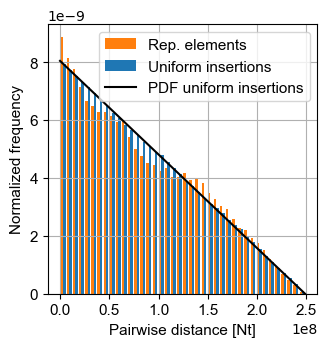

chr2
Mean dist:  81517425.88349704
Std dist:  57797223.850317836
Median dist:  71643817.0
Min dist:  61.0 Max dist:  242832144.5


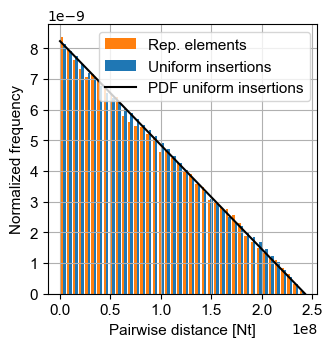

chr3
Mean dist:  66273347.855609275
Std dist:  47046317.7151757
Median dist:  58251699.5
Min dist:  71.0 Max dist:  197441565.5


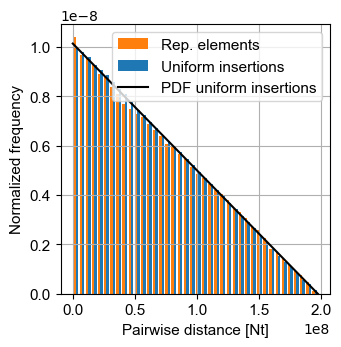

chr4
Mean dist:  65148164.2259174
Std dist:  46114634.452991754
Median dist:  57599107.5
Min dist:  45.0 Max dist:  190442011.5


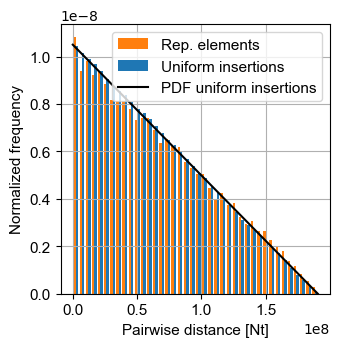

chr5
Mean dist:  60907009.57992001
Std dist:  43260961.076613516
Median dist:  53469723.75
Min dist:  81.0 Max dist:  180834458.0


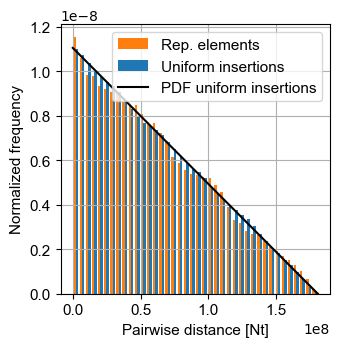

chr6
Mean dist:  58797738.29372217
Std dist:  41818930.011315614
Median dist:  51773868.0
Min dist:  48.0 Max dist:  170593769.5


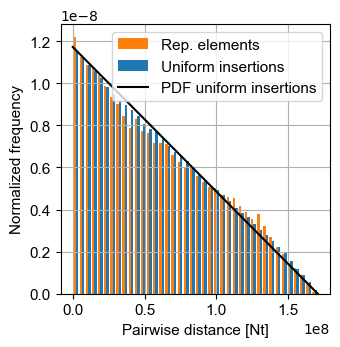

chr7
Mean dist:  53213606.09422209
Std dist:  37696005.551004514
Median dist:  46371230.25
Min dist:  31.5 Max dist:  158927709.5


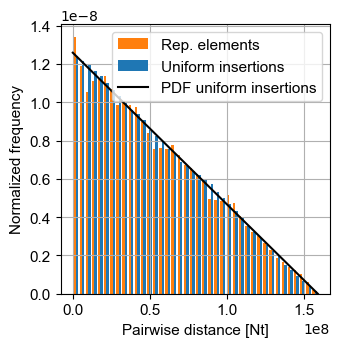

chr8
Mean dist:  47878436.94832093
Std dist:  33883704.76974756
Median dist:  42157053.5
Min dist:  65.5 Max dist:  146094127.5


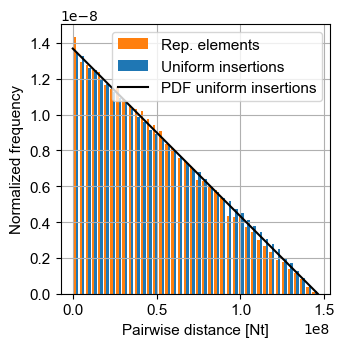

chr9
Mean dist:  48895742.76212948
Std dist:  35878063.55172956
Median dist:  42264351.5
Min dist:  81.5 Max dist:  140812540.5


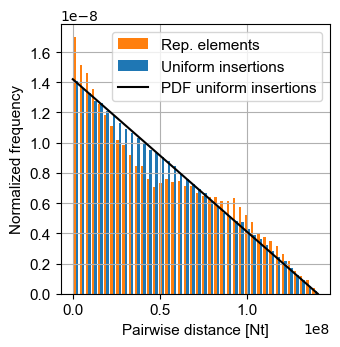

chr10
Mean dist:  46454906.589991294
Std dist:  32956450.726937942
Median dist:  41297915.0
Min dist:  69.0 Max dist:  135171313.5


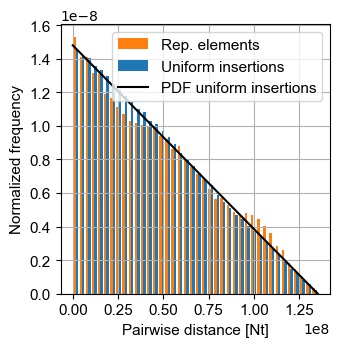

chr11
Mean dist:  47226140.57910699
Std dist:  33607667.40790475
Median dist:  41624203.0
Min dist:  30.5 Max dist:  134430984.0


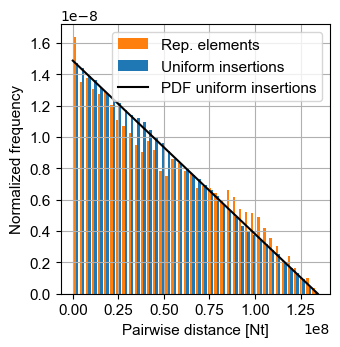

chr12
Mean dist:  45427470.55937938
Std dist:  32132233.99652228
Median dist:  40132007.75
Min dist:  59.5 Max dist:  133631433.5


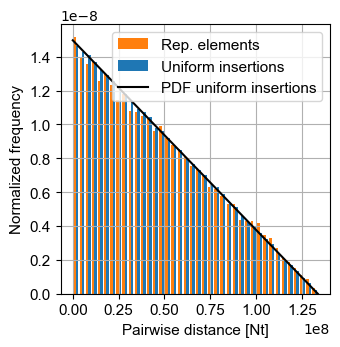

chr13
Mean dist:  32230486.240290657
Std dist:  23006274.048903234
Median dist:  28095868.5
Min dist:  94.5 Max dist:  95091533.0


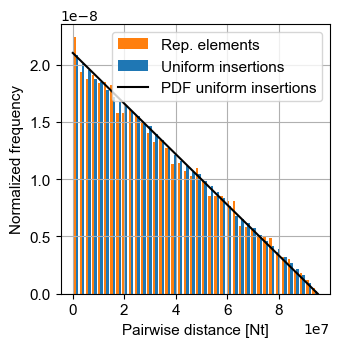

chr14
Mean dist:  28453146.510577876
Std dist:  20226861.61256493
Median dist:  25228991.0
Min dist:  39.5 Max dist:  88160718.5


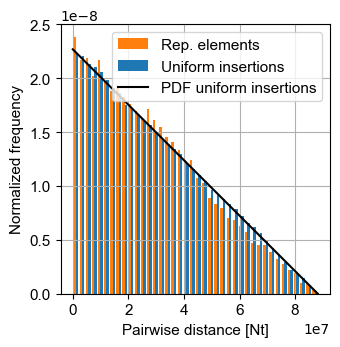

chr15
Mean dist:  28484742.930720564
Std dist:  20182999.1553835
Median dist:  25236563.25
Min dist:  129.5 Max dist:  82204974.5


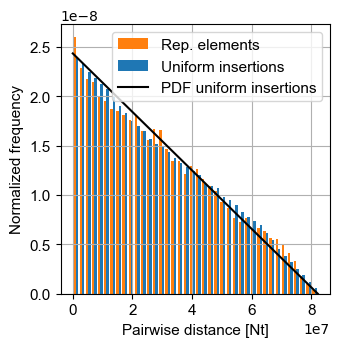

chr16
Mean dist:  30557665.9226468
Std dist:  22227904.62224659
Median dist:  26637579.5
Min dist:  58.0 Max dist:  89542869.5


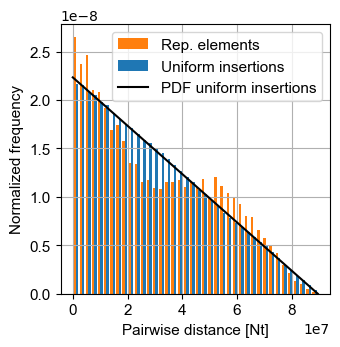

chr17
Mean dist:  29186913.098863635
Std dist:  20766771.20895117
Median dist:  25736725.5
Min dist:  50.0 Max dist:  81155876.0


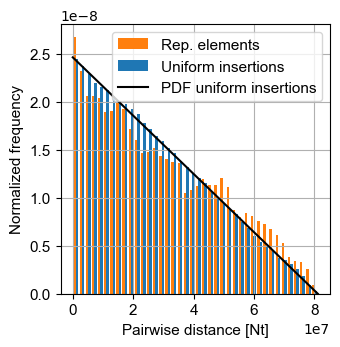

chr18
Mean dist:  25919839.096728023
Std dist:  18404479.53300394
Median dist:  22925086.0
Min dist:  78.0 Max dist:  77530807.0


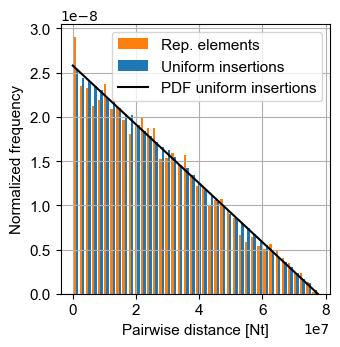

chr19
Mean dist:  17710625.348620676
Std dist:  13036830.384229535
Median dist:  15535861.0
Min dist:  65.0 Max dist:  56029556.0


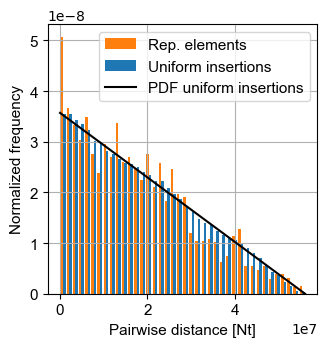

chr20
Mean dist:  22103046.430606965
Std dist:  15660015.454075374
Median dist:  19398492.0
Min dist:  44.0 Max dist:  62841066.5


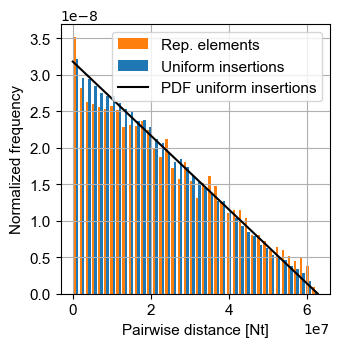

chr21
Mean dist:  13063702.736255411
Std dist:  9328651.944594104
Median dist:  11574754.0
Min dist:  82.0 Max dist:  38372599.0


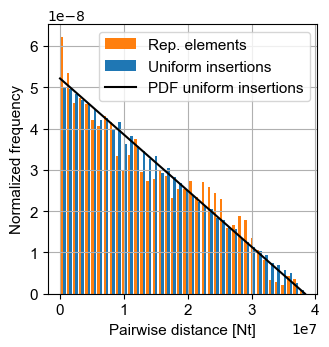

chr22
Mean dist:  12256943.934216468
Std dist:  8888895.416722188
Median dist:  10770016.0
Min dist:  135.0 Max dist:  34978023.0


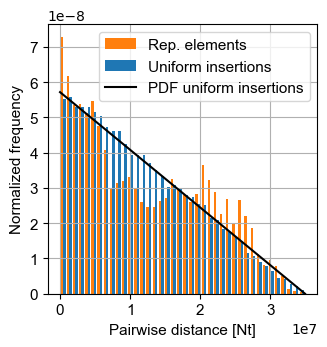

chrX
Mean dist:  51834341.26831347
Std dist:  36785872.235962644
Median dist:  45108311.75
Min dist:  49.0 Max dist:  154812205.5


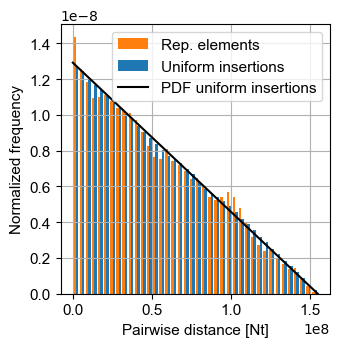

In [16]:
#pairwise distances in histogram compared to random insertions and pdf
pairwise_dist_hist_1(chr_list=chr_list_3,dist_x_list=dist_x_list_3,dist_rd_x_list=dist_rd_x_list_3)

chr1


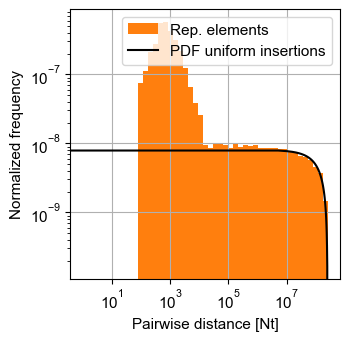

chr2


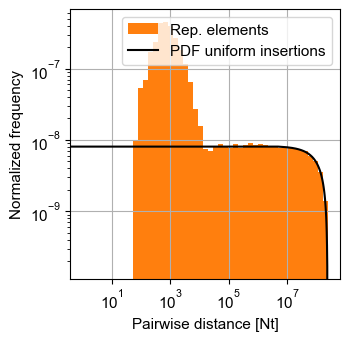

chr3


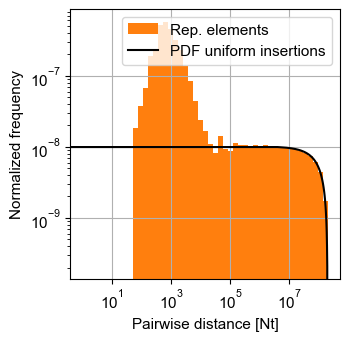

chr4


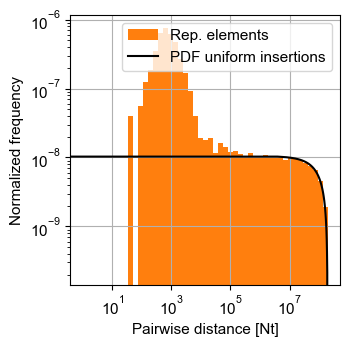

chr5


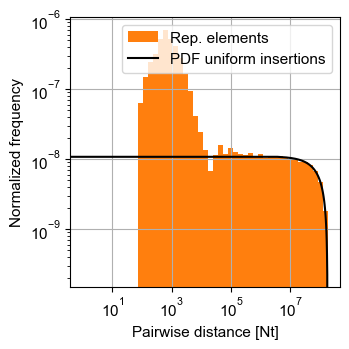

chr6


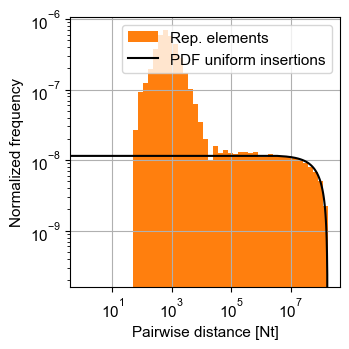

chr7


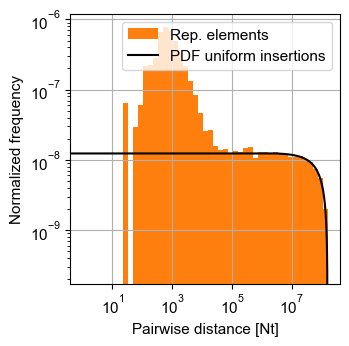

chr8


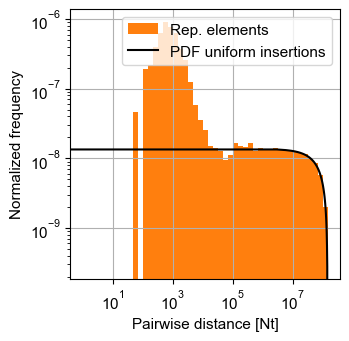

chr9


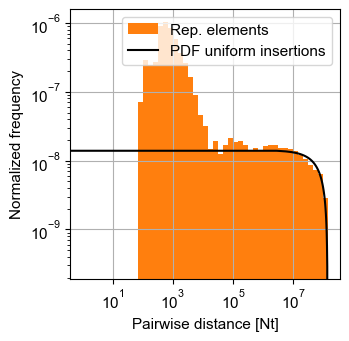

chr10


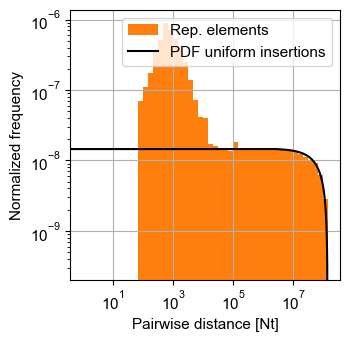

chr11


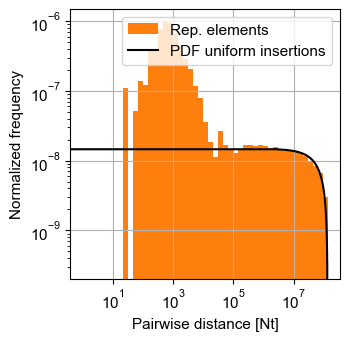

chr12


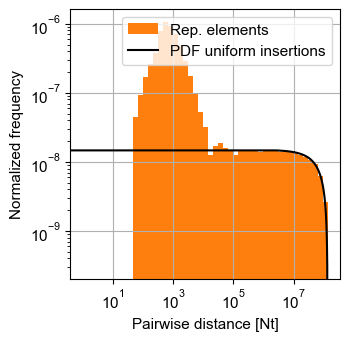

chr13


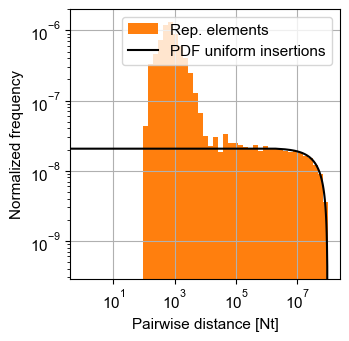

chr14


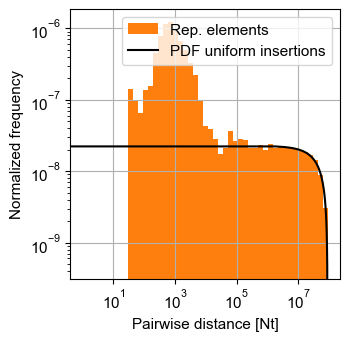

chr15


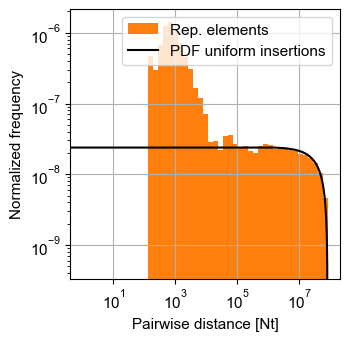

chr16


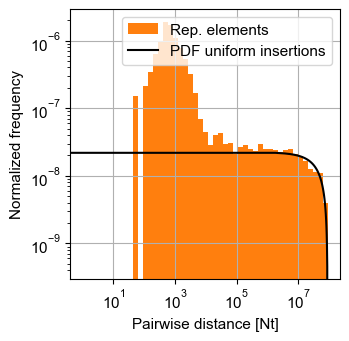

chr17


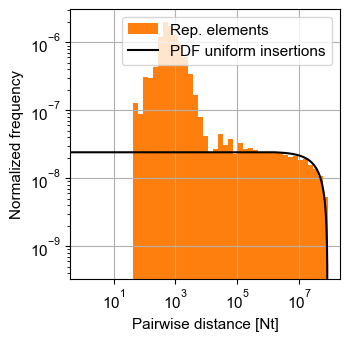

chr18


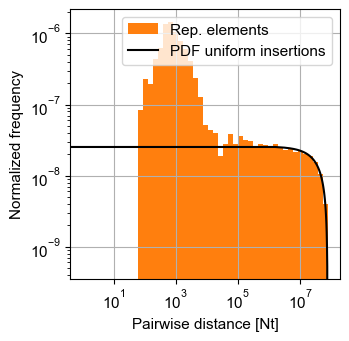

chr19


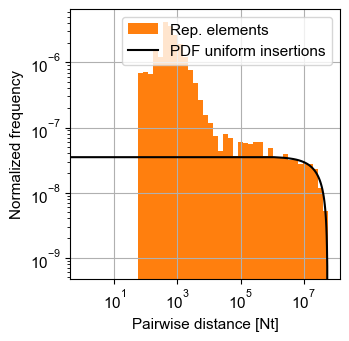

chr20


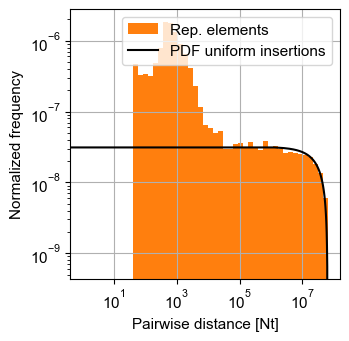

chr21


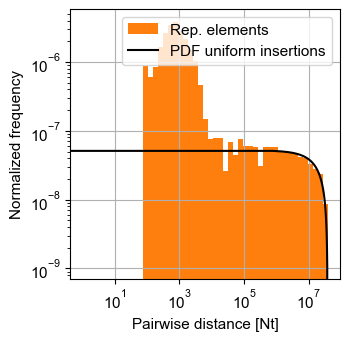

chr22


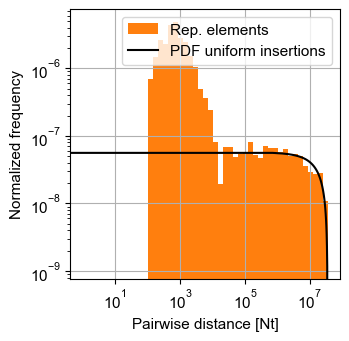

chrX


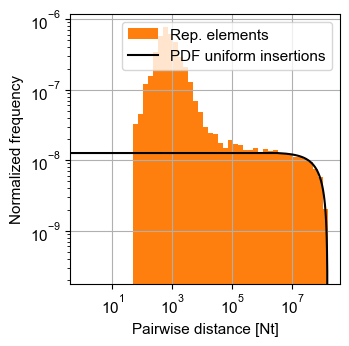

In [17]:
#pariwise distances and pdf using log scale
pairwise_dist_hist_2(chr_list=chr_list_3,dist_x_list=dist_x_list_3,dist_rd_x_list=dist_rd_x_list_3)

In [18]:
#pairwise distances for all chromosomes
dist_x_list_all_no_norm_3=all_normalized_dist(chr_list=chr_list_3,dist_x_list=dist_x_list_3,norm=False)

pdfs_3,pdfs_3_x=list_of_pdfs_hom_distr(chr_list=chr_list_3,dist_x_list=dist_x_list_3)

In [19]:
print("Mean dist: ", np.mean(dist_x_list_all_no_norm_3))
print("Std dist: ", np.std(dist_x_list_all_no_norm_3))
print("Median dist: ", np.median(dist_x_list_all_no_norm_3))
print("Min dist: ", np.min(dist_x_list_all_no_norm_3),"Max dist: ",np.max(dist_x_list_all_no_norm_3))

Mean dist:  59659166.26123063
Std dist:  47849055.58542286
Median dist:  48288875.0
Min dist:  30.5 Max dist:  248684521.5


1.0000462371506225


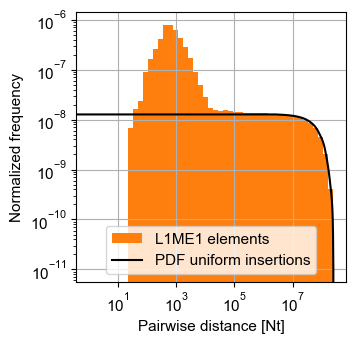

In [20]:
#averaged, normalizes pairwise distances and pdf using log scale
#name_save="Transposon_analysis_1/figures/h_hist_L1MB3_all_chr_2.pdf"
name_save=None

pairwise_dist_hist_all_3(dist_x_list=dist_x_list_3,dist_x_list_all_norm=dist_x_list_all_no_norm_3,pdfs_1_x=pdfs_3_x,pdfs_1=pdfs_3,norm=False,label_rep="L1ME1 elements",label_hom="PDF uniform insertions",save=name_save)



# DB Scan cluster detection

## Functions

In [21]:
#DBSCAN algorithm
#! crashes for high number of points due to memory 
def DB_scan_1(eps,min_samples,input_):

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(input_)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    #print(n_clusters_)

    #get particles per cluster 
    counter_labels=Counter(labels)
    

    counter_labels=dict(counter_labels)

    counter_numbers=[]

    for key, value in counter_labels.items():
        #en=counter_labels{i}
        if key !=-1:
            counter_numbers.append(value)
    counter_numbers=np.asarray(counter_numbers)
    
    #percentage of points in clusters:
    try: #if noise present
        perc_in_cluster=1-counter_labels[-1]/len(input_)
    except: #if no noise present, all points part of clusters
        perc_in_cluster=1

    #get mean particle number, get mean only if clusters detected, else append 0    
    if n_clusters_>0:
        mean_cluster_number=np.mean(counter_numbers)
    else:    
        mean_cluster_number=0

    return n_clusters_,mean_cluster_number,perc_in_cluster

#apply DBSCAN to dataset split by chromosomes
#get number of clusters, fraction of elements in clusters for transposons and random insertions
def DB_scan_appl_1(eps_1,min_samples_1,chr_list,pos_x_list,pos_rd_x_list): 
    n_clusters_1=[]
    n_clusters_rd_1=[]

    mean_cluster_number_1=[]
    mean_cluster_number_rd_1=[]

    perc_in_cluster_1=[]
    perc_in_cluster_rd_1=[]

    #eps_1=10000
    #min_samples_1=2

    for i in range(len(chr_list[:])):
        n_clusters_1_e,mean_cluster_number_1_e,perc_in_cluster_1_e=DB_scan_1(eps=eps_1,min_samples=min_samples_1,input_=pos_x_list[i].reshape(-1,1))

        n_clusters_1.append(n_clusters_1_e)
        perc_in_cluster_1.append(perc_in_cluster_1_e)

        #if no cluster detected, dont append zero average particle number in cluster
        #if mean_cluster_number_1_e>0:
         #   mean_cluster_number_1.append(mean_cluster_number_1_e)
        #append even for zero average particle number
        mean_cluster_number_1.append(mean_cluster_number_1_e)


        ########################################

        n_clusters_rd_1_e,mean_cluster_number_rd_1_e,perc_in_cluster_rd_1_e=DB_scan_1(eps=eps_1,min_samples=min_samples_1,input_=pos_rd_x_list[i].reshape(-1,1))

        n_clusters_rd_1.append(n_clusters_rd_1_e)
        perc_in_cluster_rd_1.append(perc_in_cluster_rd_1_e)

        #if no cluster detected, dont append zero average particle number in cluster
        #if mean_cluster_number_rd_1_e>0:
         #   mean_cluster_number_rd_1.append(mean_cluster_number_rd_1_e)    
        #append even for zero average particle number
        mean_cluster_number_rd_1.append(mean_cluster_number_rd_1_e)

    n_clusters_1=np.asarray(n_clusters_1)
    n_clusters_rd_1=np.asarray(n_clusters_rd_1)

    mean_cluster_number_1=np.asarray(mean_cluster_number_1)
    mean_cluster_number_rd_1=np.asarray(mean_cluster_number_rd_1)

    perc_in_cluster_1=np.asarray(perc_in_cluster_1)
    perc_in_cluster_rd_1=np.asarray(perc_in_cluster_rd_1)


    #non zero entries
    mean_cluster_number_1_nz=mean_cluster_number_1[np.nonzero(mean_cluster_number_1)]
    mean_cluster_number_rd_1_nz=mean_cluster_number_rd_1[np.nonzero(mean_cluster_number_rd_1)]
    
    return n_clusters_1, n_clusters_rd_1, mean_cluster_number_1, mean_cluster_number_rd_1, mean_cluster_number_1_nz, mean_cluster_number_rd_1_nz,perc_in_cluster_1,perc_in_cluster_rd_1

#apply DBSCAN to dataset split by chromosomes
#calculate centres of mass and extend of cluster coordinates
def DB_scan_appl_2(eps,min_samples,chr_list,pos_x_list,pos_rd_x_list): 
    n_clusters_1=[]
    n_clusters_rd_1=[]

    mean_cluster_number_1=[]
    mean_cluster_number_rd_1=[]

    perc_in_cluster_1=[]
    perc_in_cluster_rd_1=[]

    #eps_1=10000
    #min_samples_1=2
    cluster_centers_all=[]
    cluster_ext_all=[]
    for i in range(len(chr_list[:])):
        
        input_=pos_x_list[i].reshape(-1,1)
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(input_)
        
        # Get cluster labels
        cluster_labels = db.labels_

        # Get core sample indices
        core_indices = db.core_sample_indices_

        # Calculate cluster centers (mean of core samples)
        cluster_centers=[]
        m_d_max=[]
        for l in np.unique(cluster_labels): #select indices for clusters that are not noise
            if l !=-1:
                centre_e=input_[cluster_labels==l].mean(axis=0)
                cluster_centers.append(centre_e[0])
                m_d=scipy.spatial.distance.pdist(input_[cluster_labels==l].reshape(-1,1),metric='euclidean')
                m_d_max.append(np.max(m_d))

        
        cluster_centers_all.append(cluster_centers)
        cluster_ext_all.append(m_d_max)
                               
                               
    return cluster_centers_all,  cluster_ext_all

#############
#############

#apply DBSCAN to dataset split by chromosomes
#apply DB scan, get data points not in clusters (noise) and centres of data points with different ranges of points in them
#get extension of clusters from start of first element to end of last element
def DB_scan_appl_7b(dataset, point_sizes, eps, min_samples,points_in_clusters):
    
    
    ####
    ###
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(dataset)

    #Get labels and number of occurences (= number of points in cluster), including noise points with label = 0
    unique_labels2, counts2 = np.unique(labels, return_counts=True)
    unique_labels=[]
    counts=[]
    #print(unique_labels2,counts2)
    #filter out counts and label for noise points 
    for i in range(len(unique_labels2)):
        if unique_labels2[i]!=-1:
            unique_labels.append(unique_labels2[i])
            counts.append(counts2[i])
            
    #get centres of cluster masked by label (each cluster has unique label)
    #cluster_centers = [dataset[labels == label].mean(axis=0)[0] for label in unique_labels]
    #get sizes of clusters
    #get end points of all points in cluster (i.e. middle plus extension/2) and then get max value
    cluster_max=[ np.asarray([dataset[labels == label]+point_sizes[labels == label]/2])[0].max(axis=0)[0] for label in unique_labels]
    #print(cluster_max)
    #print(np.asarray([dataset[labels == label]+point_sizes[labels == label]/2 for label in unique_labels])[0] )
    #same for middle minus extension/2
    cluster_min=[ np.asarray([dataset[labels == label]-point_sizes[labels == label]/2])[0].min(axis=0)[0] for label in unique_labels]
        
    cluster_sizes = np.asarray(cluster_max)-np.asarray(cluster_min)
    
    cluster_centers= cluster_sizes/2 + np.asarray(cluster_min)
    
    #get subset of cluster centres wich have cluster number in specific range
    centres_clusters_by_range=[]
    sizes_clusters_by_range=[]
    for i in range(len(points_in_clusters)):
        
        centers = [center for center, count in zip(cluster_centers, counts) if points_in_clusters[i][0]<=count<points_in_clusters[i][1]]
        #print(centers)
        centres_clusters_by_range.append(centers)
        
        ####
        sizes = [ size for size, count in zip(cluster_sizes,counts) if points_in_clusters[i][0]<=count<points_in_clusters[i][1]]
        sizes_clusters_by_range.append(sizes)
    #get noise points
    outliers = dataset[labels == -1]
    outlier_sizes=point_sizes[labels == -1]

    return outliers, outlier_sizes,centres_clusters_by_range, sizes_clusters_by_range


#apply DB_scan_appl_7b to data partitioned by chromosomes
def DB_scan_appl_8(eps,min_samples,chr_list,pos_x_list,pos_rd_x_list,len_x_list,points_in_clusters):
    centres_clusters_by_range_all_chr=[]
    sizes_clusters_by_range_all_chr=[]
    centres_clusters_by_range_rd_all_chr=[]
    sizes_clusters_by_range_rd_all_chr=[]
    
    noise_all_chr=[]
    noise_size_all_chr=[]
    noise_all_chr_rd=[]
    noise_size_chr_rd=[]
    for i in range(len(chr_list)):
        #both positions and random positions use same point lengths
        outliers,outlier_sizes, centres_clusters_by_range, sizes_clusters_by_range=DB_scan_appl_7b(dataset=pos_x_list[i].reshape(-1,1),point_sizes=len_x_list[i].reshape(-1,1), eps=eps, min_samples=min_samples,points_in_clusters=points_in_clusters)
        outliers_rd,outlier_rd_sizes, centres_clusters_by_range_rd, sizes_clusters_by_range_rd=DB_scan_appl_7b(dataset=pos_rd_x_list[i].reshape(-1,1),point_sizes=len_x_list[i].reshape(-1,1), eps=eps, min_samples=min_samples,points_in_clusters=points_in_clusters)

        centres_clusters_by_range_all_chr.append(centres_clusters_by_range)
        sizes_clusters_by_range_all_chr.append(sizes_clusters_by_range)
        noise_all_chr.append(outliers)
        noise_size_all_chr.append(outlier_sizes)
        
        centres_clusters_by_range_rd_all_chr.append(centres_clusters_by_range_rd)
        sizes_clusters_by_range_rd_all_chr.append(sizes_clusters_by_range_rd)
        noise_all_chr_rd.append(outliers_rd)
        noise_size_chr_rd.append(outlier_rd_sizes)
        
    return centres_clusters_by_range_all_chr,sizes_clusters_by_range_all_chr,noise_all_chr,noise_size_all_chr,centres_clusters_by_range_rd_all_chr,sizes_clusters_by_range_rd_all_chr,noise_all_chr_rd,noise_size_chr_rd



In [22]:
#test DB scan
outliers, outlier_sizes,centres_clusters_by_range, sizes_clusters_by_range=DB_scan_appl_7b(dataset=np.asarray([5,6,200,300,302,303]).reshape(-1, 1), point_sizes=np.asarray([1,4,100,1,2,4]).reshape(-1, 1), eps=3, min_samples=2,points_in_clusters=[[2,3],[3,5]])

print("###")
print(outliers)
print(outlier_sizes)
print(centres_clusters_by_range)
print(sizes_clusters_by_range)

###
[[200]]
[[100]]
[[6.0], [302.25]]
[[4.0], [5.5]]


# Cluster detection 

In [23]:
#DB scan paramters, eps_3 captures peak in L1ME1 pariwise distances, min_samples_3: typically >= Dim+1  
eps_3=10**4
min_samples_3=2

n_clusters_3, n_clusters_rd_3, mean_cluster_number_3, mean_cluster_number_rd_3, mean_cluster_number_3_nz, mean_cluster_number_rd_3_nz,perc_in_cluster_3,perc_in_cluster_rd_3=DB_scan_appl_1(eps_1=eps_3,min_samples_1=2,chr_list=chr_list_3,pos_x_list=pos_x_list_3,pos_rd_x_list=pos_rd_x_list_3)

In [24]:
cluster_centers_all_3,  cluster_ext_all_3=DB_scan_appl_2(eps=eps_3,min_samples=min_samples_3,chr_list=chr_list_3,pos_x_list=pos_x_list_3,pos_rd_x_list=pos_rd_x_list_3)

print("max cluster extension:",np.max([item for sublist in cluster_ext_all_3 for item in sublist]))
print("mmin cluster extension:",np.min([item for sublist in cluster_ext_all_3 for item in sublist]))

print("mean cluster extension:",np.mean([item for sublist in cluster_ext_all_3 for item in sublist]))


max cluster extension: 31420.5
mmin cluster extension: 71.0
mean cluster extension: 3085.570990237099


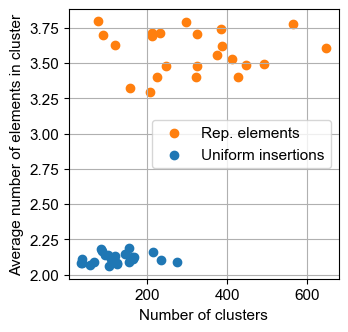

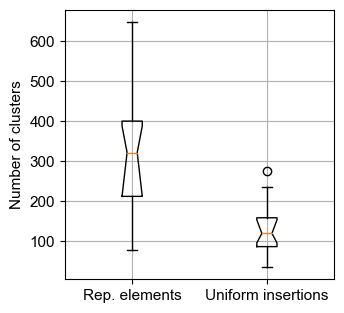

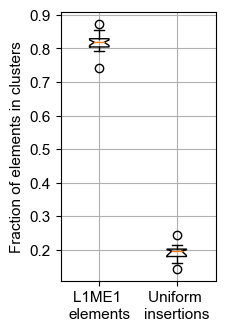

mean cluster number: 3.5787975446014237
mean rd cluster number: 2.1150287335564086


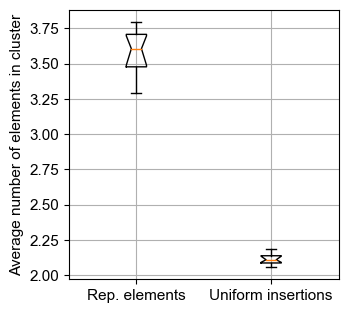

In [25]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)

ax1.scatter(n_clusters_3,mean_cluster_number_3,label="Rep. elements",color="tab:orange")
ax1.scatter(n_clusters_rd_3,mean_cluster_number_rd_3,label="Uniform insertions",color="tab:blue")

plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
plt.ylabel("Average number of elements in cluster",fontname = "Arial",fontsize=11)
plt.xlabel("Number of clusters",fontname = "Arial",fontsize=11)
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())
plt.show()


######################
######################
fliers=True

fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)

ax1.boxplot([n_clusters_3,n_clusters_rd_3],labels=["Rep. elements","Uniform insertions"],showfliers=fliers,notch=True,bootstrap=10000)

plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
plt.ylabel("Number of clusters",fontname = "Arial",fontsize=11)
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())
#plt.savefig("Transposon_analysis_3/figures/num_clusters_e4_3_3.pdf",format="pdf",bbox_inches="tight")
plt.show()

####################
####################


#fig=plt.figure(figsize=(3.5,3.5))
fig=plt.figure(figsize=(2,3.5))
ax1 = fig.add_subplot(111)

ax1.boxplot([perc_in_cluster_3,perc_in_cluster_rd_3],labels=["L1ME1 \nelements","Uniform \ninsertions"],showfliers=fliers,notch=True,widths=0.25,bootstrap=10000)

plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
plt.ylabel("Fraction of elements in clusters",fontname = "Arial",fontsize=11)
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
#ax1.set_aspect(1./ax1.get_data_ratio())
#plt.savefig("Transposon_analysis_1/figures/h_AluSq2_frac_in_clusters_e4_2_2.pdf",format="pdf",bbox_inches="tight")

plt.show()

###################
###################
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)

ax1.boxplot([mean_cluster_number_3,mean_cluster_number_rd_3],labels=["Rep. elements","Uniform insertions"],showfliers=fliers,notch=True,bootstrap=10000)
print("mean cluster number:",np.mean(mean_cluster_number_3))
print("mean rd cluster number:",np.mean(mean_cluster_number_rd_3))
#print("max cluster number:",np.max(mean_cluster_number_3))
#print("max rd cluster number:",np.max(mean_cluster_number_rd_3))

plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
plt.ylabel("Average number of elements in cluster",fontname = "Arial",fontsize=11)
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())
#plt.savefig("Transposon_analysis_3/figures/avg_num_in_clusters_e4_3_3.pdf",format="pdf",bbox_inches="tight")

plt.show()

In [26]:
#stat sign. for clusters 2-4 elem.
t_frac, p_value_frac=scipy.stats.mannwhitneyu(x=perc_in_cluster_3,y=perc_in_cluster_rd_3,alternative="two-sided")
print("Fraction of elements in clusters:",p_value_frac)

Fraction of elements in clusters: 6.6368856429973785e-09


# Chromatin accessibility using ENCODE/openChrom data
### https://www.encodeproject.org/annotations/ENCSR236YNV/



### http://genome.ucsc.edu/cgi-bin/hgTrackUi?db=hg19&g=wgEncodeOpenChromSynth
validated, OC Code = 1:

        Black: Regions identified as peaks by both the DNaseI HS assay and FAIRE assay. Peaks for DNaseI HS have DNase peak calling p-values < 0.05 (-log10(p-value) > 1.3) and peaks for FAIRE have FAIRE peak calling p-values < 0.1 (-log10(p-value) > 1.0). 


Open Chromatin, OC Code = 2 or 3:

        Blue (high significance): Regions not identified as peaks in both DNaseI HS and FAIRE, but for which the combination of peak calling p-values from these assays using Fisher's combined probability test results in a p-value < 0.01 (-log10(p-value) > 2).


DNase, OC Code = 2:

        Green (low significance): Regions identified by DNaseI HS as peaks (DNase peak calling p-value < 0.05 (-log10(p-value) > 1.3)) and not identified by FAIRE as peaks (FAIRE peak calling p-value < 0.1 (-log10(p-value) > 1.0)), and with a Fisher's combined DNaseI HS and FAIRE p-value >= 0.01 (-log10(p-value) <= 2).
        Blue (high significance): see Open Chromatin above.


FAIRE, OC Code = 3:

        Dark Red (low significance): Regions identified by FAIRE as peaks (FAIRE peak calling p-value < 0.1 (-log10(p-value) > 1.0)) and not identified by DNaseI HS as peaks (DNase peak calling p-value < 0.05 (-log10(p-value) > 1.3)), and with a Fisher's combined DNaseI HS and FAIRE p-value >= 0.01 (-log10(p-value) <= 2).
        Blue (high significance): see Open Chromatin above.


ChIP-seq, OC Code = 4:

        Pink: Regions identified by ChIP-seq as peaks (at least one of the peak calling p-values for the three ChIP experiments are < 0.05 (-log10(p-value) > 1.3)) indicating binding sites for one or more of RNA Pol II, CTCF, and c-Myc described here and not identified by DNaseI HS or FAIRE as peaks. Peaks for ChIP-seq have p-values < 0.05 (-log10(p-value) > 1.3). For RNA Pol II, only sites that overlap annotated transcription start sites by the UCSC Genes track are considered. 

All signal values, -log10(p-values), and the OC Code are displayed on the detail page for each element and are available in the corresponding bed file. 

# Functions

In [27]:
#get centre position from dataframe
def positions_elements_3(peak_input,chr_sel_name,chr_sel,chr_start,chr_stop):
    #peak_input: narrow peak file with positions from only one chr
    #get position middle of element on chr:
    pos=[]
    input_=peak_input[peak_input[chr_sel_name]==chr_sel]
    for i in range(len(input_)):
        pos_1=input_[i:i+1][chr_start].to_numpy()[0] + 0.5*(input_[i:i+1][chr_stop].to_numpy()[0]-input_[i:i+1][chr_start].to_numpy()[0])
        
        pos.append(pos_1)
    return np.asarray(pos)

#check if position in pos_1_input has position in pos_2_input within a distance dist
def check_if_pos_1_in_range_pos_2_V1(chr_input,pos_1_input,pos_2_input,dist):
    fraction_in_range=[]
    for i in range(len(chr_input)): #select chr
        fraction_in_range_e=[]
        for j in range(len(pos_1_input[i])): #select point on chr
            #k=0
            #s=0
            
            if np.min( np.abs(pos_1_input[i][j]-pos_2_input[i]) ) <=dist: #get all distances from point on chr to all points on same chr in pos_2
                fraction_in_range_e.append(1)
            else:
                fraction_in_range_e.append(0)
        fraction_in_range.append(fraction_in_range_e)

        
    return fraction_in_range

# Read in open chromatin data

In [28]:
#read in open chromatin dataset
Chr_acc_peaks=pd.read_csv("Transposon_analysis_1/DNAse_I_ENCFF001UZS/HelaS3_OC.bed",sep="\t",header = None)

Chr_acc_peaks.columns = ["chrom","chromStart","chromEnd","name","score","strand","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20"]

In [29]:
Chr_acc_peaks[:]

chrom  chromStart  chromEnd             name  score strand         6  \
0        chr1       10066     10205      FAIREOnly_1   1000      .     10066   
1        chr1       91424     91492       ChIPOnly_1   1000      .     91424   
2        chr1      104923    105070       ChIPOnly_2   1000      .    104923   
3        chr1      237670    237859       ChIPOnly_3   1000      .    237670   
4        chr1      251235    251368       ChIPOnly_4   1000      .    251235   
...       ...         ...       ...              ...    ...    ...       ...   
258213  chr21    48081488  48081897  OpenChrom_11606   1000      .  48081488   
258214  chr21    48082398  48082558  DNaseOnly_77095   1000      .  48082398   
258215  chr21    48082935  48083351  DNaseOnly_77096   1000      .  48082935   
258216  chr21    48087873  48088015  DNaseOnly_77097   1000      .  48087873   
258217  chr21    48088111  48088281  DNaseOnly_77098   1000      .  48088111   

               7          8     9  ...    11      12    13      14   15  \
0          10205    153,0,0  1.34  ...  0.00  0.0176  2.11  0.0000  0.0   
1          91492  255,0,255  0.00  ...  0.00  0.0005  0.00  0.0000  0.0   
2         105070  255,0,255  0.00  ...  0.00  0.0017  0.00  0.0000  0.0   
3         237859  255,0,255  0.00  ...  0.00  0.0017  0.00  0.0000  0.0   
4         251368  255,0,255  0.00  ...  0.00  0.0011  0.00  0.0029  0.0   
...          ...        ...   ...  ...   ...     ...   ...     ...  ...   
258213  48081897    0,0,255  2.15  ...  3.05  0.0053  0.00  0.0078  0.0   
258214  48082558    0,153,0  0.82  ...  1.46  0.0024  0.00  0.0064  0.0   
258215  48083351    0,153,0  0.97  ...  1.65  0.0080  0.00  0.0146  0.0   
258216  48088015    0,153,0  0.74  ...  1.35  0.0057  0.00  0.0129  0.0   
258217  48088281    0,153,0  0.74  ...  1.36  0.0050  0.00  0.0038  0.0   

            16    17      18   19  20  
0       0.0175  0.00  0.0140  0.0   3  
1       0.0958  1.60  0.0013  0.0   4  
2       0.3310  4.55  0.0000  0.0   4  
3       0.3424  4.68  0.0042  0.0   4  
4       0.2762  3.88  0.0000  0.0   4  
...        ...   ...     ...  ...  ..  
258213  0.0064  0.00  0.0000  0.0   2  
258214  0.0064  0.00  0.0137  0.0   2  
258215  0.0619  1.14  0.0102  0.0   2  
258216  0.0056  0.00  0.0079  0.0   2  
258217  0.0025  0.00  0.0139  0.0   2  

[258218 rows x 21 columns]

In [30]:
#select which regions to include

#Chr_acc_peaks_sel1=Chr_acc_peaks[Chr_acc_peaks["name"].str.startswith("Valid")]
#Chr_acc_peaks_sel1=Chr_acc_peaks[Chr_acc_peaks["name"].str.startswith("OpenChrom")]
#Chr_acc_peaks_sel1=Chr_acc_peaks

Chr_acc_peaks_sel1_p1=Chr_acc_peaks[Chr_acc_peaks["name"].str.startswith("Valid")]
Chr_acc_peaks_sel1_p2=Chr_acc_peaks[Chr_acc_peaks["name"].str.startswith("OpenChrom")]
Chr_acc_peaks_sel1=pd.concat([Chr_acc_peaks_sel1_p1,Chr_acc_peaks_sel1_p2])

In [31]:
Chr_acc_peaks_sel1

chrom  chromStart  chromEnd             name  score strand         6  \
7        chr1      713850    714460          Valid_1   1000      .    713850   
13       chr1      761903    763244          Valid_2   1000      .    761903   
30       chr1      841391    842575          Valid_3   1000      .    841391   
32       chr1      845956    847166          Valid_4   1000      .    845956   
37       chr1      853094    853481          Valid_5   1000      .    853094   
...       ...         ...       ...              ...    ...    ...       ...   
258047  chr21    47415122  47416071  OpenChrom_11602   1000      .  47415122   
258115  chr21    47604142  47605091  OpenChrom_11603   1000      .  47604142   
258118  chr21    47611090  47611527  OpenChrom_11604   1000      .  47611090   
258203  chr21    48023077  48023411  OpenChrom_11605   1000      .  48023077   
258213  chr21    48081488  48081897  OpenChrom_11606   1000      .  48081488   

               7        8      9  ...     11      12    13      14     15  \
7         714460    0,0,0   8.19  ...   8.29  0.0126  1.26  0.1502   7.06   
13        763244    0,0,0  15.95  ...  16.00  0.0142  1.52  0.2604  12.10   
30        842575    0,0,0   9.85  ...   9.42  0.0162  1.86  0.0530   2.61   
32        847166    0,0,0   4.64  ...   4.16  0.0149  1.64  0.0171   0.00   
37        853481    0,0,0   1.76  ...   1.59  0.0110  1.01  0.0284   1.46   
...          ...      ...    ...  ...    ...     ...   ...     ...    ...   
258047  47416071  0,0,255   2.77  ...   3.75  0.0078  0.00  0.0040   0.00   
258115  47605091  0,0,255   4.32  ...   4.51  0.0105  0.94  0.0225   0.00   
258118  47611527  0,0,255   2.59  ...   3.55  0.0069  0.00  0.0097   0.00   
258203  48023411  0,0,255   2.20  ...   3.11  0.0104  0.00  0.0111   0.00   
258213  48081897  0,0,255   2.15  ...   3.05  0.0053  0.00  0.0078   0.00   

            16    17      18    19  20  
7       0.1080  1.76  0.0274  0.00   1  
13      0.1122  1.82  0.0704  2.93   1  
30      0.0155  0.00  0.0523  0.00   1  
32      0.0546  0.00  0.0249  0.00   1  
37      0.0239  0.00  0.0101  0.00   1  
...        ...   ...     ...   ...  ..  
258047  0.0116  0.00  0.0068  0.00   2  
258115  0.0108  0.00  0.0092  0.00   2  
258118  0.0184  0.00  0.0362  0.00   2  
258203  0.0385  0.00  0.0013  0.00   2  
258213  0.0064  0.00  0.0000  0.00   2  

[65564 rows x 21 columns]

mean peak length: 683.2452260386798
median peak length: 491.0
min peak length: 30
max peak length: 13988


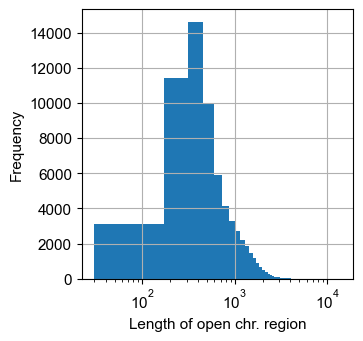

In [32]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)
peak_len_1=Chr_acc_peaks_sel1[:]["chromEnd"] -Chr_acc_peaks_sel1[:]["chromStart"]
plt.hist(peak_len_1,bins=100)
plt.grid()
plt.xscale("log")
plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
plt.ylabel("Frequency",fontname = "Arial",fontsize=11)
plt.xlabel("Length of open chr. region",fontname = "Arial",fontsize=11)

print("mean peak length:",np.mean(peak_len_1))
print("median peak length:",np.median(peak_len_1))

print("min peak length:",np.min(peak_len_1))
print("max peak length:",np.max(peak_len_1))

# Check if clusters or elements are in proximity to open chr regions

## This method does not take the length of the clusters or elements into account, but the centre positions

In [33]:
#get centres of open chr regions, split by chrom.
Chr_acc_peaks_all_chrs=[]
for i in range(len(chr_list_3)):
    Chr_acc_peaks_all_chrs.append(positions_elements_3(peak_input=Chr_acc_peaks_sel1,chr_sel_name="chrom",chr_sel=chr_list_3[i],chr_start="chromStart",chr_stop="chromEnd"))
    
    

In [34]:
#check proximity for elements

#elements
#fraction of input_1 elements in proximity to input_2 elements
#fraction_in_range_2=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_1_input=Chr_acc_peaks_all_chrs,pos_2_input=pos_x_list_3,dist=10000)

#fraction of input_2 elements in proximity to input_1 elements  #cluster_centers_all_3, pos_x_list_3
fraction_in_range_2=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_2_input=Chr_acc_peaks_all_chrs,pos_1_input=pos_x_list_3,dist=1000)

In [35]:
#check proximity for clusters


#use cluster centres

#fraction of input_1 elements in proximity to input_2 elements
#fraction_in_range_2=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_1_input=Chr_acc_peaks_all_chrs,pos_2_input=pos_x_list_3,dist=10000)

#fraction of input_2 elements in proximity to input_1 elements  #cluster_centers_all_3, pos_x_list_3
fraction_in_range_cluster_2=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_2_input=Chr_acc_peaks_all_chrs,pos_1_input=cluster_centers_all_3,dist=1000)

In [36]:
#check proximity for uniformly distributed elements

#rd position
#fraction of input_1 elements in proximity to input_2 elements
#fraction_in_range_2_rd=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_1_input=Chr_acc_peaks_all_chrs,pos_2_input=pos_rd_x_list_3,dist=10000)

#fraction of input_2 elements in proximity to input_1 elements
fraction_in_range_2_rd=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_2_input=Chr_acc_peaks_all_chrs,pos_1_input=pos_rd_x_list_3,dist=1000)

In [37]:
#get mean of proximity from all chroms.

fraction_in_range_2_mean=[]
for i in range(len(fraction_in_range_2)):
    fraction_in_range_2_mean.append(np.mean(fraction_in_range_2[i]))
    
    
fraction_in_range_cluster_2_mean=[]
for i in range(len(fraction_in_range_cluster_2)):
    fraction_in_range_cluster_2_mean.append(np.mean(fraction_in_range_cluster_2[i]))
    
fraction_in_range_2_rd_mean=[]
for i in range(len(fraction_in_range_2_rd)):
    fraction_in_range_2_rd_mean.append(np.mean(fraction_in_range_2_rd[i]))
    


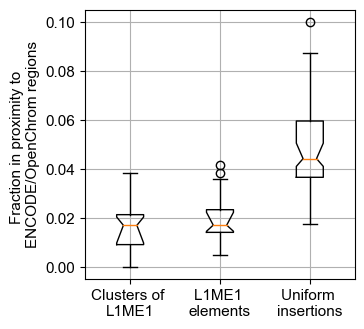

In [38]:
###################
###################
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)

#ax1.boxplot([fraction_in_range_2_mean,fraction_in_range_2_rd_mean],labels=["Rep. elements","Hom. positions"],showfliers=True,notch=True,bootstrap=1000)


ax1.boxplot([fraction_in_range_cluster_2_mean,fraction_in_range_2_mean,fraction_in_range_2_rd_mean],labels=["Clusters of \nL1ME1","L1ME1 \nelements","Uniform \ninsertions"],showfliers=True,notch=True,bootstrap=10000)


plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())
#plt.savefig("Transposon_analysis_1/figures/h_L1ME1_in_prox_ENCODE_1.pdf",format="pdf",bbox_inches="tight")
#plt.show()

In [39]:
#verify that same number of transposons and random elements are used
print(len(pos_rd_x_list_3[10]))
print(len(pos_x_list_3[10]))

1354
1354


# Check proximity of TE clusters to open chrom by number of cluster elements

## i.e: are clusters with more elements more/less often in proximity to open chrom?

In [40]:
#DBSCAN parameters
eps_3b=1e4
min_samples_3b=2

#clusters are split into classes that contain a number of points given in the following list:
points_in_clusters_3b=[[2,5],[5,10000000]]


centres_clusters_by_range_all_chr_3,sizes_clusters_by_range_all_chr_3,noise_all_chr_3,noise_size_all_chr_3,centres_clusters_by_range_rd_all_chr_3,sizes_clusters_by_range_rd_all_chr_3,noise_all_chr_rd_3,noise_size_chr_rd_3=DB_scan_appl_8(eps=eps_3b,min_samples=min_samples_3b,chr_list=chr_list_3,pos_x_list=pos_x_list_3,pos_rd_x_list=pos_rd_x_list_3,len_x_list=len_x_list_3,points_in_clusters=points_in_clusters_3b)



In [41]:
#select range interval and split data by chromosomes

dist_for_prox=1000
range_sel_u=0
clusters_in_range_cluster_element_range_1=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_2_input=Chr_acc_peaks_all_chrs,pos_1_input=[sublist[range_sel_u] for sublist in centres_clusters_by_range_all_chr_3],dist=dist_for_prox)



range_sel_u=1
clusters_in_range_cluster_element_range_2=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_2_input=Chr_acc_peaks_all_chrs,pos_1_input=[sublist[range_sel_u] for sublist in centres_clusters_by_range_all_chr_3],dist=dist_for_prox)


noise_in_range_1=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_2_input=Chr_acc_peaks_all_chrs,pos_1_input=noise_all_chr_3,dist=dist_for_prox)

In [42]:
#get mean of proximity from all chroms.

clusters_in_range_cluster_element_range_1_mean=[]
for i in range(len(clusters_in_range_cluster_element_range_1)):
    #only append fraction in prox. to open chr. if any elements/clusters on chr detected:
    if len(clusters_in_range_cluster_element_range_1[i])>0:
        clusters_in_range_cluster_element_range_1_mean.append(np.mean(clusters_in_range_cluster_element_range_1[i]))
    
    
clusters_in_range_cluster_element_range_2_mean=[]
for i in range(len(clusters_in_range_cluster_element_range_2)):
    if len(clusters_in_range_cluster_element_range_2[i])>0:
        clusters_in_range_cluster_element_range_2_mean.append(np.mean(clusters_in_range_cluster_element_range_2[i]))
    
noise_in_range_1_mean=[]
for i in range(len(noise_in_range_1)):
    if len(noise_in_range_1[i])>0:
        noise_in_range_1_mean.append(np.mean(noise_in_range_1[i]))    

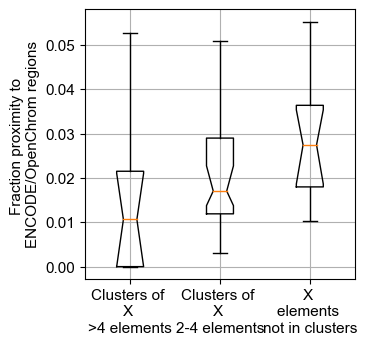

In [43]:
###################
###################
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)



ax1.boxplot([clusters_in_range_cluster_element_range_2_mean,clusters_in_range_cluster_element_range_1_mean,noise_in_range_1_mean],labels=["Clusters of \nX \n>4 elements","Clusters of \nX \n2-4 elements","X \nelements \nnot in clusters"],showfliers=True,notch=True,bootstrap=10000)




plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())
#plt.savefig("Transposon_analysis_1/figures/h_L1ME1_in_prox_ENCODE_1.pdf",format="pdf",bbox_inches="tight")
#plt.show()

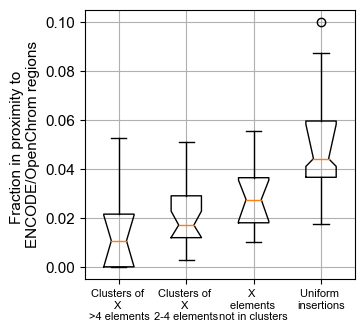

In [44]:
###################
###################
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)



ax1.boxplot([clusters_in_range_cluster_element_range_2_mean,clusters_in_range_cluster_element_range_1_mean,noise_in_range_1_mean,fraction_in_range_2_rd_mean],labels=["Clusters of \nX \n>4 elements","Clusters of \nX \n2-4 elements","X \nelements \nnot in clusters","Uniform \ninsertions"],showfliers=True,notch=True,bootstrap=10000)




plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=8) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())
#plt.savefig("Transposon_analysis_1/figures/h_L1ME1_in_prox_ENCODE_2.pdf",format="pdf",bbox_inches="tight")
#plt.show()

In [45]:
#print number of clusters on each chrom. for all cluster sizes 
cl_num=[clusters_in_range_cluster_element_range_2,clusters_in_range_cluster_element_range_1,noise_in_range_1,fraction_in_range_2_rd]

for i in range(len(cl_num)):
    print("############")
    print("cluster size",i)
    
    for j in range(len(cl_num[i])):
        print("elements in",chr_list_3[j],":",len(cl_num[i][j]))
        
    print(np.sum(np.sum(cl_num[i])))

############
cluster size 0
elements in chr1 : 146
elements in chr2 : 159
elements in chr3 : 102
elements in chr4 : 90
elements in chr5 : 94
elements in chr6 : 95
elements in chr7 : 95
elements in chr8 : 75
elements in chr9 : 68
elements in chr10 : 92
elements in chr11 : 78
elements in chr12 : 86
elements in chr13 : 61
elements in chr14 : 65
elements in chr15 : 47
elements in chr16 : 37
elements in chr17 : 53
elements in chr18 : 55
elements in chr19 : 30
elements in chr20 : 33
elements in chr21 : 23
elements in chr22 : 19
elements in chrX : 87
19
############
cluster size 1
elements in chr1 : 418
elements in chr2 : 488
elements in chr3 : 390
elements in chr4 : 337
elements in chr5 : 352
elements in chr6 : 317
elements in chr7 : 290
elements in chr8 : 248
elements in chr9 : 253
elements in chr10 : 295
elements in chr11 : 218
elements in chr12 : 238
elements in chr13 : 186
elements in chr14 : 167
elements in chr15 : 176
elements in chr16 : 169
elements in chr17 : 158
elements in chr18 : 

/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


# Check for overlap with full legth of transposons/clusters and open chromatin regions

## This method takes the length of clusters or elements into account when calculating overlap with open chromatin

## Functions

In [46]:

#create df from chr_list, pos_list and len_list with id, chrom, start, stop, columns
def df_for_rd_positions_V1(chr_list, pos_rd_x_list, len_x_list):
    #create df for random elements with same length on same chr as elements on chr 
    col_create=["REGION_ID","CHROM","START","STOP"]
    df_rd_list=[]

    for i in range(len(chr_list)):
        #get chr
        chr_sel_list=[]
        rd_start_list=[]
        rd_stop_list=[]
        rd_id_list=[]
        count_1=0
    
        chr_sel=chr_list[i]
        for j in range(len(pos_rd_x_list[i])):
            #get pos
            start_sel=int(np.round(pos_rd_x_list[i][j]-len_x_list[i][j]/2 ,0))
            stop_sel=int(np.round(pos_rd_x_list[i][j]+len_x_list[i][j]/2 ,0))
            
            chr_sel_list.append(chr_sel)
            rd_start_list.append(start_sel)
            rd_stop_list.append(stop_sel)
            rd_id_list.append(count_1)
            count_1=count_1+1
            
        all_data={col_create[0]:rd_id_list,
             col_create[1]:chr_sel_list,
             col_create[2]:rd_start_list,
             col_create[3]:rd_stop_list}  
    
        df_rd=pd.DataFrame(all_data)
        df_rd_list.append(df_rd)
    return df_rd_list


#create df with cluster id, chrom, start and stop
#for chromosome and each detected cluster list for specified range of points (e.g. all cluster with 2-4 and all with >4 points) 
def df_for_cluster_positions_V1(chr_list,centres_clusters_by_range_all_chr,sizes_clusters_by_range_all_chr):
    #create df for random elements with same length on same chr as elements on chr 
    col_create=["REGION_ID","CHROM","START","STOP"]
    df_rd_list=[]

    for i in range(len(chr_list)): #chromosomes
        #get chr
 
        
    
        chr_sel=chr_list[i]
        df_rd_cluster_list=[]
        for j in range(len(centres_clusters_by_range_all_chr[i])): #cluster sizes
            count_1=0
            chr_sel_list=[]
            rd_start_list=[]
            rd_stop_list=[]
            rd_id_list=[]
            all_data={}
            for k in range(len(centres_clusters_by_range_all_chr[i][j])): #entries for each cluster size
                
                start_sel=int(np.round(centres_clusters_by_range_all_chr[i][j][k]-sizes_clusters_by_range_all_chr[i][j][k]/2 ,0))
                stop_sel=int(np.round(centres_clusters_by_range_all_chr[i][j][k]+sizes_clusters_by_range_all_chr[i][j][k]/2 ,0))

                chr_sel_list.append(chr_sel)
                rd_start_list.append(start_sel)
                rd_stop_list.append(stop_sel)
                rd_id_list.append(count_1)
                count_1=count_1+1

                all_data={col_create[0]:rd_id_list,
                     col_create[1]:chr_sel_list,
                     col_create[2]:rd_start_list,
                     col_create[3]:rd_stop_list}  
    
            df_rd=pd.DataFrame(all_data)
            df_rd_cluster_list.append(df_rd)
        df_rd_list.append(df_rd_cluster_list)
    return df_rd_list 
    
    
#https://stackoverflow.com/questions/16691524/calculating-the-overlap-distance-of-two-1d-line-segments
def calc_overlap(min1, max1, min2, max2):
    return max(0, min(max1, max2) - max(min1, min2))

#overlap for arrays
def calc_overlap_V2(max1, max2, min1, min2):
    result = np.maximum(0, np.minimum(max1, max2) - np.maximum(min1, min2))
    return result
#overlap for arrays, with distance separation if no overlap
def calc_overlap_V3(max1, max2, min1, min2):
    result = np.minimum(max1, max2) - np.maximum(min1, min2)
    return result

#check for each element in df1 if at least on element in df2 overlaps it (on the same chr)
def check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1, df2, chr_name_1,start_name_1,stop_name_1, chr_name_2,start_name_2,stop_name_2,min_dist=0):
    
    bool_overlap_entries=[] #if at least one element in df2 overlaps element i in df1
    
    for i in range(len(df1)):
        #get chr, start and stop of entry in df1
        chr_sel=df1.iloc[i][chr_name_1]
        start_sel=df1.iloc[i][start_name_1]
        stop_sel=df1.iloc[i][stop_name_1]
        
        #select sub dataframe on df2 with same chr
        df2_sel_chr=df2[df2[chr_name_2]==chr_sel]
        
        
        ###
        #get arrays of all start and stop points on chr
        start_sel_df2=df2_sel_chr.iloc[:][start_name_2].to_numpy()
        stop_sel_df2=df2_sel_chr.iloc[:][stop_name_2].to_numpy()
        
        overlap_array=calc_overlap_V3(min1=start_sel,max1=stop_sel,min2=start_sel_df2,max2=stop_sel_df2)
        ###
        bool_overlap_e=0
        if any(x > min_dist for x in overlap_array):
            bool_overlap_e=1
        
        
        '''#check if element in df2 on same chr overlaps selected element in df1
        bool_overlap_e=0
        for j in range(len(df2_sel_chr)):
            start_sel_df2=df2_sel_chr.iloc[j][start_name_2]
            stop_sel_df2=df2_sel_chr.iloc[j][stop_name_2]
            #print(start_sel,stop_sel,"#",start_sel_df2,stop_sel_df2)
            
            overlap=calc_overlap(min1=start_sel,max1=stop_sel,min2=start_sel_df2,max2=stop_sel_df2)
            if overlap>0:
                bool_overlap_e=1
                break'''

        bool_overlap_entries.append(bool_overlap_e) 
        print(i,"/",len(df1)-1)
    return bool_overlap_entries

## Prepare data for overlap analysis

In [47]:
#create a data frame with random, hom. distr. points (have same lengths as transposons)
df_rd_pos_3=df_for_rd_positions_V1(chr_list=chr_list_3, pos_rd_x_list=pos_rd_x_list_3, len_x_list=len_x_list_3)

print("mean length of rd insertions:",np.mean([i for j in len_x_list_3 for i in j]))

#create a data frame for cluster positions split by chr and by number of points in cluster
df_cluster_pos_3=df_for_cluster_positions_V1(chr_list=chr_list_3,centres_clusters_by_range_all_chr=centres_clusters_by_range_all_chr_3,sizes_clusters_by_range_all_chr=sizes_clusters_by_range_all_chr_3)

#create a data frame for points not in clusters (same funtion as for rd points)
df_no_cluster_pos_3=df_for_rd_positions_V1(chr_list=chr_list_3, pos_rd_x_list=noise_all_chr_3, len_x_list=noise_size_all_chr_3)

print("mean length of transposons def. as noise points:",np.mean([i for j in noise_size_all_chr_3 for i in j]))

#create a data frame for random cluster positions split by chr and by number of points in cluster
df_cluster_pos_rd_3=df_for_cluster_positions_V1(chr_list=chr_list_3,centres_clusters_by_range_all_chr=centres_clusters_by_range_rd_all_chr_3,sizes_clusters_by_range_all_chr=sizes_clusters_by_range_rd_all_chr_3)


#create a data frame for random points not in clusters
df_no_cluster_pos_rd_3=df_for_rd_positions_V1(chr_list=chr_list_3, pos_rd_x_list=noise_all_chr_rd_3, len_x_list=noise_size_chr_rd_3)

print("mean length of random insertions def. as noise points:",np.mean([i for j in noise_size_chr_rd_3 for i in j]))

mean length of rd insertions: 480.5730630716767
mean length of transposons def. as noise points: 463.0964927586809
mean length of random insertions def. as noise points: 479.11666272002526


In [48]:
#lengths of transposon clusters
length_cluster_1=[]
for i in range(len(sizes_clusters_by_range_all_chr_3)):
    for j in range(len(sizes_clusters_by_range_all_chr_3[i][0])):
        length_cluster_1.append(sizes_clusters_by_range_all_chr_3[i][0][j])
 
print("mean length clusters 2-4:",np.mean(length_cluster_1))

length_cluster_2=[]
for i in range(len(sizes_clusters_by_range_all_chr_3)):
    for j in range(len(sizes_clusters_by_range_all_chr_3[i][1])):
        length_cluster_2.append(sizes_clusters_by_range_all_chr_3[i][1][j])
 
print("mean length clusters >4:",np.mean(length_cluster_2))

length_cluster_all=np.concatenate((length_cluster_1,length_cluster_2))
print("mean+std length all clusters:",np.mean(length_cluster_all),",",np.std(length_cluster_all))
print("max, min length all clusters:",np.max(length_cluster_all),",",np.min(length_cluster_all))

mean length clusters 2-4: 2492.9958029197082
mean length clusters >4: 7102.226035502958
mean+std length all clusters: 3579.41129707113 , 3461.7441694688323
max, min length all clusters: 31645.0 , 117.0


In [49]:
#lengths of clusters of hom. distr. points
length_rd_cluster_1=[]
for i in range(len(sizes_clusters_by_range_rd_all_chr_3)):
    for j in range(len(sizes_clusters_by_range_rd_all_chr_3[i][0])):
        length_rd_cluster_1.append(sizes_clusters_by_range_rd_all_chr_3[i][0][j])
 
print("mean length clusters 2-4:",np.mean(length_rd_cluster_1))

length_rd_cluster_2=[]
for i in range(len(sizes_clusters_by_range_rd_all_chr_3)):
    for j in range(len(sizes_clusters_by_range_rd_all_chr_3[i][1])):
        length_rd_cluster_2.append(sizes_clusters_by_range_rd_all_chr_3[i][1][j])
 
print("mean length clusters >4:",np.mean(length_rd_cluster_2))

length_rd_cluster_all=np.concatenate((length_rd_cluster_1,length_rd_cluster_2))
print("mean+std length all clusters:",np.mean(length_rd_cluster_all),",",np.std(length_rd_cluster_all))
print("max, min length all clusters:",np.max(length_rd_cluster_all),",",np.min(length_rd_cluster_all))

mean length clusters 2-4: 6065.0875438596495
mean length clusters >4: 21011.5
mean+std length all clusters: 6075.5688990182325 , 3597.4358866210528
max, min length all clusters: 23657.5 , 84.5


# Calculate overlap

In [50]:
#maximum separation between closet points of regions
max_sep_regions=0 #-1000

In [51]:
%%time
#overlap of clusters with open chromatin
mean_overlap_clusters=[]
for i in range(len(chr_list_3)):
    mean_overlap_clusters_e=[]
    for j in range(len(df_cluster_pos_3[i])):
        overlap_clusters_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_cluster_pos_3[i][j], df2=Chr_acc_peaks_sel1, chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
        mean_overlap_clusters_e.append(overlap_clusters_open_chr_e)
    mean_overlap_clusters.append(mean_overlap_clusters_e)

0 / 417
1 / 417
2 / 417
3 / 417
4 / 417
5 / 417
6 / 417
7 / 417
8 / 417
9 / 417
10 / 417
11 / 417
12 / 417
13 / 417
14 / 417
15 / 417
16 / 417
17 / 417
18 / 417
19 / 417
20 / 417
21 / 417
22 / 417
23 / 417
24 / 417
25 / 417
26 / 417
27 / 417
28 / 417
29 / 417
30 / 417
31 / 417
32 / 417
33 / 417
34 / 417
35 / 417
36 / 417
37 / 417
38 / 417
39 / 417
40 / 417
41 / 417
42 / 417
43 / 417
44 / 417
45 / 417
46 / 417
47 / 417
48 / 417
49 / 417
50 / 417
51 / 417
52 / 417
53 / 417
54 / 417
55 / 417
56 / 417
57 / 417
58 / 417
59 / 417
60 / 417
61 / 417
62 / 417
63 / 417
64 / 417
65 / 417
66 / 417
67 / 417
68 / 417
69 / 417
70 / 417
71 / 417
72 / 417
73 / 417
74 / 417
75 / 417
76 / 417
77 / 417
78 / 417
79 / 417
80 / 417
81 / 417
82 / 417
83 / 417
84 / 417
85 / 417
86 / 417
87 / 417
88 / 417
89 / 417
90 / 417
91 / 417
92 / 417
93 / 417
94 / 417
95 / 417
96 / 417
97 / 417
98 / 417
99 / 417
100 / 417
101 / 417
102 / 417
103 / 417
104 / 417
105 / 417
106 / 417
107 / 417
108 / 417
109 / 417
110 / 417


358 / 487
359 / 487
360 / 487
361 / 487
362 / 487
363 / 487
364 / 487
365 / 487
366 / 487
367 / 487
368 / 487
369 / 487
370 / 487
371 / 487
372 / 487
373 / 487
374 / 487
375 / 487
376 / 487
377 / 487
378 / 487
379 / 487
380 / 487
381 / 487
382 / 487
383 / 487
384 / 487
385 / 487
386 / 487
387 / 487
388 / 487
389 / 487
390 / 487
391 / 487
392 / 487
393 / 487
394 / 487
395 / 487
396 / 487
397 / 487
398 / 487
399 / 487
400 / 487
401 / 487
402 / 487
403 / 487
404 / 487
405 / 487
406 / 487
407 / 487
408 / 487
409 / 487
410 / 487
411 / 487
412 / 487
413 / 487
414 / 487
415 / 487
416 / 487
417 / 487
418 / 487
419 / 487
420 / 487
421 / 487
422 / 487
423 / 487
424 / 487
425 / 487
426 / 487
427 / 487
428 / 487
429 / 487
430 / 487
431 / 487
432 / 487
433 / 487
434 / 487
435 / 487
436 / 487
437 / 487
438 / 487
439 / 487
440 / 487
441 / 487
442 / 487
443 / 487
444 / 487
445 / 487
446 / 487
447 / 487
448 / 487
449 / 487
450 / 487
451 / 487
452 / 487
453 / 487
454 / 487
455 / 487
456 / 487
457 / 487


127 / 336
128 / 336
129 / 336
130 / 336
131 / 336
132 / 336
133 / 336
134 / 336
135 / 336
136 / 336
137 / 336
138 / 336
139 / 336
140 / 336
141 / 336
142 / 336
143 / 336
144 / 336
145 / 336
146 / 336
147 / 336
148 / 336
149 / 336
150 / 336
151 / 336
152 / 336
153 / 336
154 / 336
155 / 336
156 / 336
157 / 336
158 / 336
159 / 336
160 / 336
161 / 336
162 / 336
163 / 336
164 / 336
165 / 336
166 / 336
167 / 336
168 / 336
169 / 336
170 / 336
171 / 336
172 / 336
173 / 336
174 / 336
175 / 336
176 / 336
177 / 336
178 / 336
179 / 336
180 / 336
181 / 336
182 / 336
183 / 336
184 / 336
185 / 336
186 / 336
187 / 336
188 / 336
189 / 336
190 / 336
191 / 336
192 / 336
193 / 336
194 / 336
195 / 336
196 / 336
197 / 336
198 / 336
199 / 336
200 / 336
201 / 336
202 / 336
203 / 336
204 / 336
205 / 336
206 / 336
207 / 336
208 / 336
209 / 336
210 / 336
211 / 336
212 / 336
213 / 336
214 / 336
215 / 336
216 / 336
217 / 336
218 / 336
219 / 336
220 / 336
221 / 336
222 / 336
223 / 336
224 / 336
225 / 336
226 / 336


183 / 316
184 / 316
185 / 316
186 / 316
187 / 316
188 / 316
189 / 316
190 / 316
191 / 316
192 / 316
193 / 316
194 / 316
195 / 316
196 / 316
197 / 316
198 / 316
199 / 316
200 / 316
201 / 316
202 / 316
203 / 316
204 / 316
205 / 316
206 / 316
207 / 316
208 / 316
209 / 316
210 / 316
211 / 316
212 / 316
213 / 316
214 / 316
215 / 316
216 / 316
217 / 316
218 / 316
219 / 316
220 / 316
221 / 316
222 / 316
223 / 316
224 / 316
225 / 316
226 / 316
227 / 316
228 / 316
229 / 316
230 / 316
231 / 316
232 / 316
233 / 316
234 / 316
235 / 316
236 / 316
237 / 316
238 / 316
239 / 316
240 / 316
241 / 316
242 / 316
243 / 316
244 / 316
245 / 316
246 / 316
247 / 316
248 / 316
249 / 316
250 / 316
251 / 316
252 / 316
253 / 316
254 / 316
255 / 316
256 / 316
257 / 316
258 / 316
259 / 316
260 / 316
261 / 316
262 / 316
263 / 316
264 / 316
265 / 316
266 / 316
267 / 316
268 / 316
269 / 316
270 / 316
271 / 316
272 / 316
273 / 316
274 / 316
275 / 316
276 / 316
277 / 316
278 / 316
279 / 316
280 / 316
281 / 316
282 / 316


56 / 74
57 / 74
58 / 74
59 / 74
60 / 74
61 / 74
62 / 74
63 / 74
64 / 74
65 / 74
66 / 74
67 / 74
68 / 74
69 / 74
70 / 74
71 / 74
72 / 74
73 / 74
74 / 74
0 / 252
1 / 252
2 / 252
3 / 252
4 / 252
5 / 252
6 / 252
7 / 252
8 / 252
9 / 252
10 / 252
11 / 252
12 / 252
13 / 252
14 / 252
15 / 252
16 / 252
17 / 252
18 / 252
19 / 252
20 / 252
21 / 252
22 / 252
23 / 252
24 / 252
25 / 252
26 / 252
27 / 252
28 / 252
29 / 252
30 / 252
31 / 252
32 / 252
33 / 252
34 / 252
35 / 252
36 / 252
37 / 252
38 / 252
39 / 252
40 / 252
41 / 252
42 / 252
43 / 252
44 / 252
45 / 252
46 / 252
47 / 252
48 / 252
49 / 252
50 / 252
51 / 252
52 / 252
53 / 252
54 / 252
55 / 252
56 / 252
57 / 252
58 / 252
59 / 252
60 / 252
61 / 252
62 / 252
63 / 252
64 / 252
65 / 252
66 / 252
67 / 252
68 / 252
69 / 252
70 / 252
71 / 252
72 / 252
73 / 252
74 / 252
75 / 252
76 / 252
77 / 252
78 / 252
79 / 252
80 / 252
81 / 252
82 / 252
83 / 252
84 / 252
85 / 252
86 / 252
87 / 252
88 / 252
89 / 252
90 / 252
91 / 252
92 / 252
93 / 252
94 / 252
95 

203 / 217
204 / 217
205 / 217
206 / 217
207 / 217
208 / 217
209 / 217
210 / 217
211 / 217
212 / 217
213 / 217
214 / 217
215 / 217
216 / 217
217 / 217
0 / 77
1 / 77
2 / 77
3 / 77
4 / 77
5 / 77
6 / 77
7 / 77
8 / 77
9 / 77
10 / 77
11 / 77
12 / 77
13 / 77
14 / 77
15 / 77
16 / 77
17 / 77
18 / 77
19 / 77
20 / 77
21 / 77
22 / 77
23 / 77
24 / 77
25 / 77
26 / 77
27 / 77
28 / 77
29 / 77
30 / 77
31 / 77
32 / 77
33 / 77
34 / 77
35 / 77
36 / 77
37 / 77
38 / 77
39 / 77
40 / 77
41 / 77
42 / 77
43 / 77
44 / 77
45 / 77
46 / 77
47 / 77
48 / 77
49 / 77
50 / 77
51 / 77
52 / 77
53 / 77
54 / 77
55 / 77
56 / 77
57 / 77
58 / 77
59 / 77
60 / 77
61 / 77
62 / 77
63 / 77
64 / 77
65 / 77
66 / 77
67 / 77
68 / 77
69 / 77
70 / 77
71 / 77
72 / 77
73 / 77
74 / 77
75 / 77
76 / 77
77 / 77
0 / 237
1 / 237
2 / 237
3 / 237
4 / 237
5 / 237
6 / 237
7 / 237
8 / 237
9 / 237
10 / 237
11 / 237
12 / 237
13 / 237
14 / 237
15 / 237
16 / 237
17 / 237
18 / 237
19 / 237
20 / 237
21 / 237
22 / 237
23 / 237
24 / 237
25 / 237
26 / 237
27 

91 / 175
92 / 175
93 / 175
94 / 175
95 / 175
96 / 175
97 / 175
98 / 175
99 / 175
100 / 175
101 / 175
102 / 175
103 / 175
104 / 175
105 / 175
106 / 175
107 / 175
108 / 175
109 / 175
110 / 175
111 / 175
112 / 175
113 / 175
114 / 175
115 / 175
116 / 175
117 / 175
118 / 175
119 / 175
120 / 175
121 / 175
122 / 175
123 / 175
124 / 175
125 / 175
126 / 175
127 / 175
128 / 175
129 / 175
130 / 175
131 / 175
132 / 175
133 / 175
134 / 175
135 / 175
136 / 175
137 / 175
138 / 175
139 / 175
140 / 175
141 / 175
142 / 175
143 / 175
144 / 175
145 / 175
146 / 175
147 / 175
148 / 175
149 / 175
150 / 175
151 / 175
152 / 175
153 / 175
154 / 175
155 / 175
156 / 175
157 / 175
158 / 175
159 / 175
160 / 175
161 / 175
162 / 175
163 / 175
164 / 175
165 / 175
166 / 175
167 / 175
168 / 175
169 / 175
170 / 175
171 / 175
172 / 175
173 / 175
174 / 175
175 / 175
0 / 46
1 / 46
2 / 46
3 / 46
4 / 46
5 / 46
6 / 46
7 / 46
8 / 46
9 / 46
10 / 46
11 / 46
12 / 46
13 / 46
14 / 46
15 / 46
16 / 46
17 / 46
18 / 46
19 / 46
20 / 46
2

105 / 122
106 / 122
107 / 122
108 / 122
109 / 122
110 / 122
111 / 122
112 / 122
113 / 122
114 / 122
115 / 122
116 / 122
117 / 122
118 / 122
119 / 122
120 / 122
121 / 122
122 / 122
0 / 32
1 / 32
2 / 32
3 / 32
4 / 32
5 / 32
6 / 32
7 / 32
8 / 32
9 / 32
10 / 32
11 / 32
12 / 32
13 / 32
14 / 32
15 / 32
16 / 32
17 / 32
18 / 32
19 / 32
20 / 32
21 / 32
22 / 32
23 / 32
24 / 32
25 / 32
26 / 32
27 / 32
28 / 32
29 / 32
30 / 32
31 / 32
32 / 32
0 / 65
1 / 65
2 / 65
3 / 65
4 / 65
5 / 65
6 / 65
7 / 65
8 / 65
9 / 65
10 / 65
11 / 65
12 / 65
13 / 65
14 / 65
15 / 65
16 / 65
17 / 65
18 / 65
19 / 65
20 / 65
21 / 65
22 / 65
23 / 65
24 / 65
25 / 65
26 / 65
27 / 65
28 / 65
29 / 65
30 / 65
31 / 65
32 / 65
33 / 65
34 / 65
35 / 65
36 / 65
37 / 65
38 / 65
39 / 65
40 / 65
41 / 65
42 / 65
43 / 65
44 / 65
45 / 65
46 / 65
47 / 65
48 / 65
49 / 65
50 / 65
51 / 65
52 / 65
53 / 65
54 / 65
55 / 65
56 / 65
57 / 65
58 / 65
59 / 65
60 / 65
61 / 65
62 / 65
63 / 65
64 / 65
65 / 65
0 / 22
1 / 22
2 / 22
3 / 22
4 / 22
5 / 22
6 / 22

In [52]:
%%time
#overlap of random clusters with open chromatin
mean_overlap_rd_clusters=[]
for i in range(len(chr_list_3)):
    mean_overlap_rd_clusters_e=[]
    for j in range(len(df_cluster_pos_rd_3[i])):
        overlap_clusters_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_cluster_pos_rd_3[i][j], df2=Chr_acc_peaks_sel1, chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
        mean_overlap_rd_clusters_e.append(overlap_clusters_open_chr_e)
    mean_overlap_rd_clusters.append(mean_overlap_rd_clusters_e)

0 / 234
1 / 234
2 / 234
3 / 234
4 / 234
5 / 234
6 / 234
7 / 234
8 / 234
9 / 234
10 / 234
11 / 234
12 / 234
13 / 234
14 / 234
15 / 234
16 / 234
17 / 234
18 / 234
19 / 234
20 / 234
21 / 234
22 / 234
23 / 234
24 / 234
25 / 234
26 / 234
27 / 234
28 / 234
29 / 234
30 / 234
31 / 234
32 / 234
33 / 234
34 / 234
35 / 234
36 / 234
37 / 234
38 / 234
39 / 234
40 / 234
41 / 234
42 / 234
43 / 234
44 / 234
45 / 234
46 / 234
47 / 234
48 / 234
49 / 234
50 / 234
51 / 234
52 / 234
53 / 234
54 / 234
55 / 234
56 / 234
57 / 234
58 / 234
59 / 234
60 / 234
61 / 234
62 / 234
63 / 234
64 / 234
65 / 234
66 / 234
67 / 234
68 / 234
69 / 234
70 / 234
71 / 234
72 / 234
73 / 234
74 / 234
75 / 234
76 / 234
77 / 234
78 / 234
79 / 234
80 / 234
81 / 234
82 / 234
83 / 234
84 / 234
85 / 234
86 / 234
87 / 234
88 / 234
89 / 234
90 / 234
91 / 234
92 / 234
93 / 234
94 / 234
95 / 234
96 / 234
97 / 234
98 / 234
99 / 234
100 / 234
101 / 234
102 / 234
103 / 234
104 / 234
105 / 234
106 / 234
107 / 234
108 / 234
109 / 234
110 / 234


32 / 166
33 / 166
34 / 166
35 / 166
36 / 166
37 / 166
38 / 166
39 / 166
40 / 166
41 / 166
42 / 166
43 / 166
44 / 166
45 / 166
46 / 166
47 / 166
48 / 166
49 / 166
50 / 166
51 / 166
52 / 166
53 / 166
54 / 166
55 / 166
56 / 166
57 / 166
58 / 166
59 / 166
60 / 166
61 / 166
62 / 166
63 / 166
64 / 166
65 / 166
66 / 166
67 / 166
68 / 166
69 / 166
70 / 166
71 / 166
72 / 166
73 / 166
74 / 166
75 / 166
76 / 166
77 / 166
78 / 166
79 / 166
80 / 166
81 / 166
82 / 166
83 / 166
84 / 166
85 / 166
86 / 166
87 / 166
88 / 166
89 / 166
90 / 166
91 / 166
92 / 166
93 / 166
94 / 166
95 / 166
96 / 166
97 / 166
98 / 166
99 / 166
100 / 166
101 / 166
102 / 166
103 / 166
104 / 166
105 / 166
106 / 166
107 / 166
108 / 166
109 / 166
110 / 166
111 / 166
112 / 166
113 / 166
114 / 166
115 / 166
116 / 166
117 / 166
118 / 166
119 / 166
120 / 166
121 / 166
122 / 166
123 / 166
124 / 166
125 / 166
126 / 166
127 / 166
128 / 166
129 / 166
130 / 166
131 / 166
132 / 166
133 / 166
134 / 166
135 / 166
136 / 166
137 / 166
138 / 16

37 / 123
38 / 123
39 / 123
40 / 123
41 / 123
42 / 123
43 / 123
44 / 123
45 / 123
46 / 123
47 / 123
48 / 123
49 / 123
50 / 123
51 / 123
52 / 123
53 / 123
54 / 123
55 / 123
56 / 123
57 / 123
58 / 123
59 / 123
60 / 123
61 / 123
62 / 123
63 / 123
64 / 123
65 / 123
66 / 123
67 / 123
68 / 123
69 / 123
70 / 123
71 / 123
72 / 123
73 / 123
74 / 123
75 / 123
76 / 123
77 / 123
78 / 123
79 / 123
80 / 123
81 / 123
82 / 123
83 / 123
84 / 123
85 / 123
86 / 123
87 / 123
88 / 123
89 / 123
90 / 123
91 / 123
92 / 123
93 / 123
94 / 123
95 / 123
96 / 123
97 / 123
98 / 123
99 / 123
100 / 123
101 / 123
102 / 123
103 / 123
104 / 123
105 / 123
106 / 123
107 / 123
108 / 123
109 / 123
110 / 123
111 / 123
112 / 123
113 / 123
114 / 123
115 / 123
116 / 123
117 / 123
118 / 123
119 / 123
120 / 123
121 / 123
122 / 123
123 / 123
0 / 103
1 / 103
2 / 103
3 / 103
4 / 103
5 / 103
6 / 103
7 / 103
8 / 103
9 / 103
10 / 103
11 / 103
12 / 103
13 / 103
14 / 103
15 / 103
16 / 103
17 / 103
18 / 103
19 / 103
20 / 103
21 / 103
22 / 

In [53]:
#get mean overlap percentages in each chromosome for 2-4 points and >4 points in clusters

min_num_points_cond=10
mean_overlap_clusters_range_1_mean=[]
for i in range(len(mean_overlap_clusters)):
    #only append fraction in prox. to open chr. if any elements/clusters on chr detected:
    if len(mean_overlap_clusters[i][0])>min_num_points_cond:
        mean_overlap_clusters_range_1_mean.append(np.mean(mean_overlap_clusters[i][0]))
    
mean_overlap_clusters_range_2_mean=[]
for i in range(len(mean_overlap_clusters)):
    #only append fraction in prox. to open chr. if any elements/clusters on chr detected:
    if len(mean_overlap_clusters[i][1])>min_num_points_cond:
        mean_overlap_clusters_range_2_mean.append(np.mean(mean_overlap_clusters[i][1]))
        
mean_overlap_cluster_range_all_mean=[]
for i in range(len(mean_overlap_clusters)):
    concat_overlap=np.concatenate((mean_overlap_clusters[i][0],mean_overlap_clusters[i][1]))
    if len(concat_overlap)>min_num_points_cond:
        mean_overlap_cluster_range_all_mean.append(np.mean(concat_overlap))
    
 
mean_overlap_rd_clusters_range_1_mean=[]
for i in range(len(mean_overlap_rd_clusters)):
    #only append fraction in prox. to open chr. if any elements/clusters on chr detected:
    if len(mean_overlap_rd_clusters[i][0])>min_num_points_cond:
        mean_overlap_rd_clusters_range_1_mean.append(np.mean(mean_overlap_rd_clusters[i][0]))
    
mean_overlap_rd_clusters_range_2_mean=[]
for i in range(len(mean_overlap_rd_clusters)):
    #only append fraction in prox. to open chr. if any elements/clusters on chr detected:
    if len(mean_overlap_rd_clusters[i][1])>min_num_points_cond:
        mean_overlap_rd_clusters_range_2_mean.append(np.mean(mean_overlap_rd_clusters[i][1]))

        
mean_overlap_rd_cluster_range_all_mean=[]
for i in range(len(mean_overlap_rd_clusters)):
    concat_overlap=np.concatenate((mean_overlap_rd_clusters[i][0],mean_overlap_rd_clusters[i][1]))
    if len(concat_overlap)>min_num_points_cond:
        mean_overlap_rd_cluster_range_all_mean.append(np.mean(concat_overlap))

In [54]:
%%time
#overlap all transposon positions or random positions with open chr
mean_overlap_tr_1=[]
mean_overlap_rd_1=[]
for i in range(len(chr_list_3)):
    overlap_tr_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=rmd_list_3[i], df2=Chr_acc_peaks_sel1, chr_name_1="genoName",start_name_1="genoStart",stop_name_1="genoEnd", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
    overlap_rd_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_rd_pos_3[i], df2=Chr_acc_peaks_sel1, chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
    
    mean_overlap_tr_1.append(overlap_tr_open_chr_e)
    mean_overlap_rd_1.append(overlap_rd_open_chr_e)
    

0 / 2526
1 / 2526
2 / 2526
3 / 2526
4 / 2526
5 / 2526
6 / 2526
7 / 2526
8 / 2526
9 / 2526
10 / 2526
11 / 2526
12 / 2526
13 / 2526
14 / 2526
15 / 2526
16 / 2526
17 / 2526
18 / 2526
19 / 2526
20 / 2526
21 / 2526
22 / 2526
23 / 2526
24 / 2526
25 / 2526
26 / 2526
27 / 2526
28 / 2526
29 / 2526
30 / 2526
31 / 2526
32 / 2526
33 / 2526
34 / 2526
35 / 2526
36 / 2526
37 / 2526
38 / 2526
39 / 2526
40 / 2526
41 / 2526
42 / 2526
43 / 2526
44 / 2526
45 / 2526
46 / 2526
47 / 2526
48 / 2526
49 / 2526
50 / 2526
51 / 2526
52 / 2526
53 / 2526
54 / 2526
55 / 2526
56 / 2526
57 / 2526
58 / 2526
59 / 2526
60 / 2526
61 / 2526
62 / 2526
63 / 2526
64 / 2526
65 / 2526
66 / 2526
67 / 2526
68 / 2526
69 / 2526
70 / 2526
71 / 2526
72 / 2526
73 / 2526
74 / 2526
75 / 2526
76 / 2526
77 / 2526
78 / 2526
79 / 2526
80 / 2526
81 / 2526
82 / 2526
83 / 2526
84 / 2526
85 / 2526
86 / 2526
87 / 2526
88 / 2526
89 / 2526
90 / 2526
91 / 2526
92 / 2526
93 / 2526
94 / 2526
95 / 2526
96 / 2526
97 / 2526
98 / 2526
99 / 2526
100 / 2526

785 / 2526
786 / 2526
787 / 2526
788 / 2526
789 / 2526
790 / 2526
791 / 2526
792 / 2526
793 / 2526
794 / 2526
795 / 2526
796 / 2526
797 / 2526
798 / 2526
799 / 2526
800 / 2526
801 / 2526
802 / 2526
803 / 2526
804 / 2526
805 / 2526
806 / 2526
807 / 2526
808 / 2526
809 / 2526
810 / 2526
811 / 2526
812 / 2526
813 / 2526
814 / 2526
815 / 2526
816 / 2526
817 / 2526
818 / 2526
819 / 2526
820 / 2526
821 / 2526
822 / 2526
823 / 2526
824 / 2526
825 / 2526
826 / 2526
827 / 2526
828 / 2526
829 / 2526
830 / 2526
831 / 2526
832 / 2526
833 / 2526
834 / 2526
835 / 2526
836 / 2526
837 / 2526
838 / 2526
839 / 2526
840 / 2526
841 / 2526
842 / 2526
843 / 2526
844 / 2526
845 / 2526
846 / 2526
847 / 2526
848 / 2526
849 / 2526
850 / 2526
851 / 2526
852 / 2526
853 / 2526
854 / 2526
855 / 2526
856 / 2526
857 / 2526
858 / 2526
859 / 2526
860 / 2526
861 / 2526
862 / 2526
863 / 2526
864 / 2526
865 / 2526
866 / 2526
867 / 2526
868 / 2526
869 / 2526
870 / 2526
871 / 2526
872 / 2526
873 / 2526
874 / 2526
875 / 2526

1491 / 2526
1492 / 2526
1493 / 2526
1494 / 2526
1495 / 2526
1496 / 2526
1497 / 2526
1498 / 2526
1499 / 2526
1500 / 2526
1501 / 2526
1502 / 2526
1503 / 2526
1504 / 2526
1505 / 2526
1506 / 2526
1507 / 2526
1508 / 2526
1509 / 2526
1510 / 2526
1511 / 2526
1512 / 2526
1513 / 2526
1514 / 2526
1515 / 2526
1516 / 2526
1517 / 2526
1518 / 2526
1519 / 2526
1520 / 2526
1521 / 2526
1522 / 2526
1523 / 2526
1524 / 2526
1525 / 2526
1526 / 2526
1527 / 2526
1528 / 2526
1529 / 2526
1530 / 2526
1531 / 2526
1532 / 2526
1533 / 2526
1534 / 2526
1535 / 2526
1536 / 2526
1537 / 2526
1538 / 2526
1539 / 2526
1540 / 2526
1541 / 2526
1542 / 2526
1543 / 2526
1544 / 2526
1545 / 2526
1546 / 2526
1547 / 2526
1548 / 2526
1549 / 2526
1550 / 2526
1551 / 2526
1552 / 2526
1553 / 2526
1554 / 2526
1555 / 2526
1556 / 2526
1557 / 2526
1558 / 2526
1559 / 2526
1560 / 2526
1561 / 2526
1562 / 2526
1563 / 2526
1564 / 2526
1565 / 2526
1566 / 2526
1567 / 2526
1568 / 2526
1569 / 2526
1570 / 2526
1571 / 2526
1572 / 2526
1573 / 2526
1574

2199 / 2526
2200 / 2526
2201 / 2526
2202 / 2526
2203 / 2526
2204 / 2526
2205 / 2526
2206 / 2526
2207 / 2526
2208 / 2526
2209 / 2526
2210 / 2526
2211 / 2526
2212 / 2526
2213 / 2526
2214 / 2526
2215 / 2526
2216 / 2526
2217 / 2526
2218 / 2526
2219 / 2526
2220 / 2526
2221 / 2526
2222 / 2526
2223 / 2526
2224 / 2526
2225 / 2526
2226 / 2526
2227 / 2526
2228 / 2526
2229 / 2526
2230 / 2526
2231 / 2526
2232 / 2526
2233 / 2526
2234 / 2526
2235 / 2526
2236 / 2526
2237 / 2526
2238 / 2526
2239 / 2526
2240 / 2526
2241 / 2526
2242 / 2526
2243 / 2526
2244 / 2526
2245 / 2526
2246 / 2526
2247 / 2526
2248 / 2526
2249 / 2526
2250 / 2526
2251 / 2526
2252 / 2526
2253 / 2526
2254 / 2526
2255 / 2526
2256 / 2526
2257 / 2526
2258 / 2526
2259 / 2526
2260 / 2526
2261 / 2526
2262 / 2526
2263 / 2526
2264 / 2526
2265 / 2526
2266 / 2526
2267 / 2526
2268 / 2526
2269 / 2526
2270 / 2526
2271 / 2526
2272 / 2526
2273 / 2526
2274 / 2526
2275 / 2526
2276 / 2526
2277 / 2526
2278 / 2526
2279 / 2526
2280 / 2526
2281 / 2526
2282

407 / 2526
408 / 2526
409 / 2526
410 / 2526
411 / 2526
412 / 2526
413 / 2526
414 / 2526
415 / 2526
416 / 2526
417 / 2526
418 / 2526
419 / 2526
420 / 2526
421 / 2526
422 / 2526
423 / 2526
424 / 2526
425 / 2526
426 / 2526
427 / 2526
428 / 2526
429 / 2526
430 / 2526
431 / 2526
432 / 2526
433 / 2526
434 / 2526
435 / 2526
436 / 2526
437 / 2526
438 / 2526
439 / 2526
440 / 2526
441 / 2526
442 / 2526
443 / 2526
444 / 2526
445 / 2526
446 / 2526
447 / 2526
448 / 2526
449 / 2526
450 / 2526
451 / 2526
452 / 2526
453 / 2526
454 / 2526
455 / 2526
456 / 2526
457 / 2526
458 / 2526
459 / 2526
460 / 2526
461 / 2526
462 / 2526
463 / 2526
464 / 2526
465 / 2526
466 / 2526
467 / 2526
468 / 2526
469 / 2526
470 / 2526
471 / 2526
472 / 2526
473 / 2526
474 / 2526
475 / 2526
476 / 2526
477 / 2526
478 / 2526
479 / 2526
480 / 2526
481 / 2526
482 / 2526
483 / 2526
484 / 2526
485 / 2526
486 / 2526
487 / 2526
488 / 2526
489 / 2526
490 / 2526
491 / 2526
492 / 2526
493 / 2526
494 / 2526
495 / 2526
496 / 2526
497 / 2526

1163 / 2526
1164 / 2526
1165 / 2526
1166 / 2526
1167 / 2526
1168 / 2526
1169 / 2526
1170 / 2526
1171 / 2526
1172 / 2526
1173 / 2526
1174 / 2526
1175 / 2526
1176 / 2526
1177 / 2526
1178 / 2526
1179 / 2526
1180 / 2526
1181 / 2526
1182 / 2526
1183 / 2526
1184 / 2526
1185 / 2526
1186 / 2526
1187 / 2526
1188 / 2526
1189 / 2526
1190 / 2526
1191 / 2526
1192 / 2526
1193 / 2526
1194 / 2526
1195 / 2526
1196 / 2526
1197 / 2526
1198 / 2526
1199 / 2526
1200 / 2526
1201 / 2526
1202 / 2526
1203 / 2526
1204 / 2526
1205 / 2526
1206 / 2526
1207 / 2526
1208 / 2526
1209 / 2526
1210 / 2526
1211 / 2526
1212 / 2526
1213 / 2526
1214 / 2526
1215 / 2526
1216 / 2526
1217 / 2526
1218 / 2526
1219 / 2526
1220 / 2526
1221 / 2526
1222 / 2526
1223 / 2526
1224 / 2526
1225 / 2526
1226 / 2526
1227 / 2526
1228 / 2526
1229 / 2526
1230 / 2526
1231 / 2526
1232 / 2526
1233 / 2526
1234 / 2526
1235 / 2526
1236 / 2526
1237 / 2526
1238 / 2526
1239 / 2526
1240 / 2526
1241 / 2526
1242 / 2526
1243 / 2526
1244 / 2526
1245 / 2526
1246

1861 / 2526
1862 / 2526
1863 / 2526
1864 / 2526
1865 / 2526
1866 / 2526
1867 / 2526
1868 / 2526
1869 / 2526
1870 / 2526
1871 / 2526
1872 / 2526
1873 / 2526
1874 / 2526
1875 / 2526
1876 / 2526
1877 / 2526
1878 / 2526
1879 / 2526
1880 / 2526
1881 / 2526
1882 / 2526
1883 / 2526
1884 / 2526
1885 / 2526
1886 / 2526
1887 / 2526
1888 / 2526
1889 / 2526
1890 / 2526
1891 / 2526
1892 / 2526
1893 / 2526
1894 / 2526
1895 / 2526
1896 / 2526
1897 / 2526
1898 / 2526
1899 / 2526
1900 / 2526
1901 / 2526
1902 / 2526
1903 / 2526
1904 / 2526
1905 / 2526
1906 / 2526
1907 / 2526
1908 / 2526
1909 / 2526
1910 / 2526
1911 / 2526
1912 / 2526
1913 / 2526
1914 / 2526
1915 / 2526
1916 / 2526
1917 / 2526
1918 / 2526
1919 / 2526
1920 / 2526
1921 / 2526
1922 / 2526
1923 / 2526
1924 / 2526
1925 / 2526
1926 / 2526
1927 / 2526
1928 / 2526
1929 / 2526
1930 / 2526
1931 / 2526
1932 / 2526
1933 / 2526
1934 / 2526
1935 / 2526
1936 / 2526
1937 / 2526
1938 / 2526
1939 / 2526
1940 / 2526
1941 / 2526
1942 / 2526
1943 / 2526
1944

27 / 2826
28 / 2826
29 / 2826
30 / 2826
31 / 2826
32 / 2826
33 / 2826
34 / 2826
35 / 2826
36 / 2826
37 / 2826
38 / 2826
39 / 2826
40 / 2826
41 / 2826
42 / 2826
43 / 2826
44 / 2826
45 / 2826
46 / 2826
47 / 2826
48 / 2826
49 / 2826
50 / 2826
51 / 2826
52 / 2826
53 / 2826
54 / 2826
55 / 2826
56 / 2826
57 / 2826
58 / 2826
59 / 2826
60 / 2826
61 / 2826
62 / 2826
63 / 2826
64 / 2826
65 / 2826
66 / 2826
67 / 2826
68 / 2826
69 / 2826
70 / 2826
71 / 2826
72 / 2826
73 / 2826
74 / 2826
75 / 2826
76 / 2826
77 / 2826
78 / 2826
79 / 2826
80 / 2826
81 / 2826
82 / 2826
83 / 2826
84 / 2826
85 / 2826
86 / 2826
87 / 2826
88 / 2826
89 / 2826
90 / 2826
91 / 2826
92 / 2826
93 / 2826
94 / 2826
95 / 2826
96 / 2826
97 / 2826
98 / 2826
99 / 2826
100 / 2826
101 / 2826
102 / 2826
103 / 2826
104 / 2826
105 / 2826
106 / 2826
107 / 2826
108 / 2826
109 / 2826
110 / 2826
111 / 2826
112 / 2826
113 / 2826
114 / 2826
115 / 2826
116 / 2826
117 / 2826
118 / 2826
119 / 2826
120 / 2826
121 / 2826
122 / 2826
123 / 2826
124 / 

791 / 2826
792 / 2826
793 / 2826
794 / 2826
795 / 2826
796 / 2826
797 / 2826
798 / 2826
799 / 2826
800 / 2826
801 / 2826
802 / 2826
803 / 2826
804 / 2826
805 / 2826
806 / 2826
807 / 2826
808 / 2826
809 / 2826
810 / 2826
811 / 2826
812 / 2826
813 / 2826
814 / 2826
815 / 2826
816 / 2826
817 / 2826
818 / 2826
819 / 2826
820 / 2826
821 / 2826
822 / 2826
823 / 2826
824 / 2826
825 / 2826
826 / 2826
827 / 2826
828 / 2826
829 / 2826
830 / 2826
831 / 2826
832 / 2826
833 / 2826
834 / 2826
835 / 2826
836 / 2826
837 / 2826
838 / 2826
839 / 2826
840 / 2826
841 / 2826
842 / 2826
843 / 2826
844 / 2826
845 / 2826
846 / 2826
847 / 2826
848 / 2826
849 / 2826
850 / 2826
851 / 2826
852 / 2826
853 / 2826
854 / 2826
855 / 2826
856 / 2826
857 / 2826
858 / 2826
859 / 2826
860 / 2826
861 / 2826
862 / 2826
863 / 2826
864 / 2826
865 / 2826
866 / 2826
867 / 2826
868 / 2826
869 / 2826
870 / 2826
871 / 2826
872 / 2826
873 / 2826
874 / 2826
875 / 2826
876 / 2826
877 / 2826
878 / 2826
879 / 2826
880 / 2826
881 / 2826

1513 / 2826
1514 / 2826
1515 / 2826
1516 / 2826
1517 / 2826
1518 / 2826
1519 / 2826
1520 / 2826
1521 / 2826
1522 / 2826
1523 / 2826
1524 / 2826
1525 / 2826
1526 / 2826
1527 / 2826
1528 / 2826
1529 / 2826
1530 / 2826
1531 / 2826
1532 / 2826
1533 / 2826
1534 / 2826
1535 / 2826
1536 / 2826
1537 / 2826
1538 / 2826
1539 / 2826
1540 / 2826
1541 / 2826
1542 / 2826
1543 / 2826
1544 / 2826
1545 / 2826
1546 / 2826
1547 / 2826
1548 / 2826
1549 / 2826
1550 / 2826
1551 / 2826
1552 / 2826
1553 / 2826
1554 / 2826
1555 / 2826
1556 / 2826
1557 / 2826
1558 / 2826
1559 / 2826
1560 / 2826
1561 / 2826
1562 / 2826
1563 / 2826
1564 / 2826
1565 / 2826
1566 / 2826
1567 / 2826
1568 / 2826
1569 / 2826
1570 / 2826
1571 / 2826
1572 / 2826
1573 / 2826
1574 / 2826
1575 / 2826
1576 / 2826
1577 / 2826
1578 / 2826
1579 / 2826
1580 / 2826
1581 / 2826
1582 / 2826
1583 / 2826
1584 / 2826
1585 / 2826
1586 / 2826
1587 / 2826
1588 / 2826
1589 / 2826
1590 / 2826
1591 / 2826
1592 / 2826
1593 / 2826
1594 / 2826
1595 / 2826
1596

2196 / 2826
2197 / 2826
2198 / 2826
2199 / 2826
2200 / 2826
2201 / 2826
2202 / 2826
2203 / 2826
2204 / 2826
2205 / 2826
2206 / 2826
2207 / 2826
2208 / 2826
2209 / 2826
2210 / 2826
2211 / 2826
2212 / 2826
2213 / 2826
2214 / 2826
2215 / 2826
2216 / 2826
2217 / 2826
2218 / 2826
2219 / 2826
2220 / 2826
2221 / 2826
2222 / 2826
2223 / 2826
2224 / 2826
2225 / 2826
2226 / 2826
2227 / 2826
2228 / 2826
2229 / 2826
2230 / 2826
2231 / 2826
2232 / 2826
2233 / 2826
2234 / 2826
2235 / 2826
2236 / 2826
2237 / 2826
2238 / 2826
2239 / 2826
2240 / 2826
2241 / 2826
2242 / 2826
2243 / 2826
2244 / 2826
2245 / 2826
2246 / 2826
2247 / 2826
2248 / 2826
2249 / 2826
2250 / 2826
2251 / 2826
2252 / 2826
2253 / 2826
2254 / 2826
2255 / 2826
2256 / 2826
2257 / 2826
2258 / 2826
2259 / 2826
2260 / 2826
2261 / 2826
2262 / 2826
2263 / 2826
2264 / 2826
2265 / 2826
2266 / 2826
2267 / 2826
2268 / 2826
2269 / 2826
2270 / 2826
2271 / 2826
2272 / 2826
2273 / 2826
2274 / 2826
2275 / 2826
2276 / 2826
2277 / 2826
2278 / 2826
2279

92 / 2826
93 / 2826
94 / 2826
95 / 2826
96 / 2826
97 / 2826
98 / 2826
99 / 2826
100 / 2826
101 / 2826
102 / 2826
103 / 2826
104 / 2826
105 / 2826
106 / 2826
107 / 2826
108 / 2826
109 / 2826
110 / 2826
111 / 2826
112 / 2826
113 / 2826
114 / 2826
115 / 2826
116 / 2826
117 / 2826
118 / 2826
119 / 2826
120 / 2826
121 / 2826
122 / 2826
123 / 2826
124 / 2826
125 / 2826
126 / 2826
127 / 2826
128 / 2826
129 / 2826
130 / 2826
131 / 2826
132 / 2826
133 / 2826
134 / 2826
135 / 2826
136 / 2826
137 / 2826
138 / 2826
139 / 2826
140 / 2826
141 / 2826
142 / 2826
143 / 2826
144 / 2826
145 / 2826
146 / 2826
147 / 2826
148 / 2826
149 / 2826
150 / 2826
151 / 2826
152 / 2826
153 / 2826
154 / 2826
155 / 2826
156 / 2826
157 / 2826
158 / 2826
159 / 2826
160 / 2826
161 / 2826
162 / 2826
163 / 2826
164 / 2826
165 / 2826
166 / 2826
167 / 2826
168 / 2826
169 / 2826
170 / 2826
171 / 2826
172 / 2826
173 / 2826
174 / 2826
175 / 2826
176 / 2826
177 / 2826
178 / 2826
179 / 2826
180 / 2826
181 / 2826
182 / 2826
183 / 2

870 / 2826
871 / 2826
872 / 2826
873 / 2826
874 / 2826
875 / 2826
876 / 2826
877 / 2826
878 / 2826
879 / 2826
880 / 2826
881 / 2826
882 / 2826
883 / 2826
884 / 2826
885 / 2826
886 / 2826
887 / 2826
888 / 2826
889 / 2826
890 / 2826
891 / 2826
892 / 2826
893 / 2826
894 / 2826
895 / 2826
896 / 2826
897 / 2826
898 / 2826
899 / 2826
900 / 2826
901 / 2826
902 / 2826
903 / 2826
904 / 2826
905 / 2826
906 / 2826
907 / 2826
908 / 2826
909 / 2826
910 / 2826
911 / 2826
912 / 2826
913 / 2826
914 / 2826
915 / 2826
916 / 2826
917 / 2826
918 / 2826
919 / 2826
920 / 2826
921 / 2826
922 / 2826
923 / 2826
924 / 2826
925 / 2826
926 / 2826
927 / 2826
928 / 2826
929 / 2826
930 / 2826
931 / 2826
932 / 2826
933 / 2826
934 / 2826
935 / 2826
936 / 2826
937 / 2826
938 / 2826
939 / 2826
940 / 2826
941 / 2826
942 / 2826
943 / 2826
944 / 2826
945 / 2826
946 / 2826
947 / 2826
948 / 2826
949 / 2826
950 / 2826
951 / 2826
952 / 2826
953 / 2826
954 / 2826
955 / 2826
956 / 2826
957 / 2826
958 / 2826
959 / 2826
960 / 2826

1588 / 2826
1589 / 2826
1590 / 2826
1591 / 2826
1592 / 2826
1593 / 2826
1594 / 2826
1595 / 2826
1596 / 2826
1597 / 2826
1598 / 2826
1599 / 2826
1600 / 2826
1601 / 2826
1602 / 2826
1603 / 2826
1604 / 2826
1605 / 2826
1606 / 2826
1607 / 2826
1608 / 2826
1609 / 2826
1610 / 2826
1611 / 2826
1612 / 2826
1613 / 2826
1614 / 2826
1615 / 2826
1616 / 2826
1617 / 2826
1618 / 2826
1619 / 2826
1620 / 2826
1621 / 2826
1622 / 2826
1623 / 2826
1624 / 2826
1625 / 2826
1626 / 2826
1627 / 2826
1628 / 2826
1629 / 2826
1630 / 2826
1631 / 2826
1632 / 2826
1633 / 2826
1634 / 2826
1635 / 2826
1636 / 2826
1637 / 2826
1638 / 2826
1639 / 2826
1640 / 2826
1641 / 2826
1642 / 2826
1643 / 2826
1644 / 2826
1645 / 2826
1646 / 2826
1647 / 2826
1648 / 2826
1649 / 2826
1650 / 2826
1651 / 2826
1652 / 2826
1653 / 2826
1654 / 2826
1655 / 2826
1656 / 2826
1657 / 2826
1658 / 2826
1659 / 2826
1660 / 2826
1661 / 2826
1662 / 2826
1663 / 2826
1664 / 2826
1665 / 2826
1666 / 2826
1667 / 2826
1668 / 2826
1669 / 2826
1670 / 2826
1671

2316 / 2826
2317 / 2826
2318 / 2826
2319 / 2826
2320 / 2826
2321 / 2826
2322 / 2826
2323 / 2826
2324 / 2826
2325 / 2826
2326 / 2826
2327 / 2826
2328 / 2826
2329 / 2826
2330 / 2826
2331 / 2826
2332 / 2826
2333 / 2826
2334 / 2826
2335 / 2826
2336 / 2826
2337 / 2826
2338 / 2826
2339 / 2826
2340 / 2826
2341 / 2826
2342 / 2826
2343 / 2826
2344 / 2826
2345 / 2826
2346 / 2826
2347 / 2826
2348 / 2826
2349 / 2826
2350 / 2826
2351 / 2826
2352 / 2826
2353 / 2826
2354 / 2826
2355 / 2826
2356 / 2826
2357 / 2826
2358 / 2826
2359 / 2826
2360 / 2826
2361 / 2826
2362 / 2826
2363 / 2826
2364 / 2826
2365 / 2826
2366 / 2826
2367 / 2826
2368 / 2826
2369 / 2826
2370 / 2826
2371 / 2826
2372 / 2826
2373 / 2826
2374 / 2826
2375 / 2826
2376 / 2826
2377 / 2826
2378 / 2826
2379 / 2826
2380 / 2826
2381 / 2826
2382 / 2826
2383 / 2826
2384 / 2826
2385 / 2826
2386 / 2826
2387 / 2826
2388 / 2826
2389 / 2826
2390 / 2826
2391 / 2826
2392 / 2826
2393 / 2826
2394 / 2826
2395 / 2826
2396 / 2826
2397 / 2826
2398 / 2826
2399

214 / 2158
215 / 2158
216 / 2158
217 / 2158
218 / 2158
219 / 2158
220 / 2158
221 / 2158
222 / 2158
223 / 2158
224 / 2158
225 / 2158
226 / 2158
227 / 2158
228 / 2158
229 / 2158
230 / 2158
231 / 2158
232 / 2158
233 / 2158
234 / 2158
235 / 2158
236 / 2158
237 / 2158
238 / 2158
239 / 2158
240 / 2158
241 / 2158
242 / 2158
243 / 2158
244 / 2158
245 / 2158
246 / 2158
247 / 2158
248 / 2158
249 / 2158
250 / 2158
251 / 2158
252 / 2158
253 / 2158
254 / 2158
255 / 2158
256 / 2158
257 / 2158
258 / 2158
259 / 2158
260 / 2158
261 / 2158
262 / 2158
263 / 2158
264 / 2158
265 / 2158
266 / 2158
267 / 2158
268 / 2158
269 / 2158
270 / 2158
271 / 2158
272 / 2158
273 / 2158
274 / 2158
275 / 2158
276 / 2158
277 / 2158
278 / 2158
279 / 2158
280 / 2158
281 / 2158
282 / 2158
283 / 2158
284 / 2158
285 / 2158
286 / 2158
287 / 2158
288 / 2158
289 / 2158
290 / 2158
291 / 2158
292 / 2158
293 / 2158
294 / 2158
295 / 2158
296 / 2158
297 / 2158
298 / 2158
299 / 2158
300 / 2158
301 / 2158
302 / 2158
303 / 2158
304 / 2158

997 / 2158
998 / 2158
999 / 2158
1000 / 2158
1001 / 2158
1002 / 2158
1003 / 2158
1004 / 2158
1005 / 2158
1006 / 2158
1007 / 2158
1008 / 2158
1009 / 2158
1010 / 2158
1011 / 2158
1012 / 2158
1013 / 2158
1014 / 2158
1015 / 2158
1016 / 2158
1017 / 2158
1018 / 2158
1019 / 2158
1020 / 2158
1021 / 2158
1022 / 2158
1023 / 2158
1024 / 2158
1025 / 2158
1026 / 2158
1027 / 2158
1028 / 2158
1029 / 2158
1030 / 2158
1031 / 2158
1032 / 2158
1033 / 2158
1034 / 2158
1035 / 2158
1036 / 2158
1037 / 2158
1038 / 2158
1039 / 2158
1040 / 2158
1041 / 2158
1042 / 2158
1043 / 2158
1044 / 2158
1045 / 2158
1046 / 2158
1047 / 2158
1048 / 2158
1049 / 2158
1050 / 2158
1051 / 2158
1052 / 2158
1053 / 2158
1054 / 2158
1055 / 2158
1056 / 2158
1057 / 2158
1058 / 2158
1059 / 2158
1060 / 2158
1061 / 2158
1062 / 2158
1063 / 2158
1064 / 2158
1065 / 2158
1066 / 2158
1067 / 2158
1068 / 2158
1069 / 2158
1070 / 2158
1071 / 2158
1072 / 2158
1073 / 2158
1074 / 2158
1075 / 2158
1076 / 2158
1077 / 2158
1078 / 2158
1079 / 2158
1080 / 

1691 / 2158
1692 / 2158
1693 / 2158
1694 / 2158
1695 / 2158
1696 / 2158
1697 / 2158
1698 / 2158
1699 / 2158
1700 / 2158
1701 / 2158
1702 / 2158
1703 / 2158
1704 / 2158
1705 / 2158
1706 / 2158
1707 / 2158
1708 / 2158
1709 / 2158
1710 / 2158
1711 / 2158
1712 / 2158
1713 / 2158
1714 / 2158
1715 / 2158
1716 / 2158
1717 / 2158
1718 / 2158
1719 / 2158
1720 / 2158
1721 / 2158
1722 / 2158
1723 / 2158
1724 / 2158
1725 / 2158
1726 / 2158
1727 / 2158
1728 / 2158
1729 / 2158
1730 / 2158
1731 / 2158
1732 / 2158
1733 / 2158
1734 / 2158
1735 / 2158
1736 / 2158
1737 / 2158
1738 / 2158
1739 / 2158
1740 / 2158
1741 / 2158
1742 / 2158
1743 / 2158
1744 / 2158
1745 / 2158
1746 / 2158
1747 / 2158
1748 / 2158
1749 / 2158
1750 / 2158
1751 / 2158
1752 / 2158
1753 / 2158
1754 / 2158
1755 / 2158
1756 / 2158
1757 / 2158
1758 / 2158
1759 / 2158
1760 / 2158
1761 / 2158
1762 / 2158
1763 / 2158
1764 / 2158
1765 / 2158
1766 / 2158
1767 / 2158
1768 / 2158
1769 / 2158
1770 / 2158
1771 / 2158
1772 / 2158
1773 / 2158
1774

255 / 2158
256 / 2158
257 / 2158
258 / 2158
259 / 2158
260 / 2158
261 / 2158
262 / 2158
263 / 2158
264 / 2158
265 / 2158
266 / 2158
267 / 2158
268 / 2158
269 / 2158
270 / 2158
271 / 2158
272 / 2158
273 / 2158
274 / 2158
275 / 2158
276 / 2158
277 / 2158
278 / 2158
279 / 2158
280 / 2158
281 / 2158
282 / 2158
283 / 2158
284 / 2158
285 / 2158
286 / 2158
287 / 2158
288 / 2158
289 / 2158
290 / 2158
291 / 2158
292 / 2158
293 / 2158
294 / 2158
295 / 2158
296 / 2158
297 / 2158
298 / 2158
299 / 2158
300 / 2158
301 / 2158
302 / 2158
303 / 2158
304 / 2158
305 / 2158
306 / 2158
307 / 2158
308 / 2158
309 / 2158
310 / 2158
311 / 2158
312 / 2158
313 / 2158
314 / 2158
315 / 2158
316 / 2158
317 / 2158
318 / 2158
319 / 2158
320 / 2158
321 / 2158
322 / 2158
323 / 2158
324 / 2158
325 / 2158
326 / 2158
327 / 2158
328 / 2158
329 / 2158
330 / 2158
331 / 2158
332 / 2158
333 / 2158
334 / 2158
335 / 2158
336 / 2158
337 / 2158
338 / 2158
339 / 2158
340 / 2158
341 / 2158
342 / 2158
343 / 2158
344 / 2158
345 / 2158

1074 / 2158
1075 / 2158
1076 / 2158
1077 / 2158
1078 / 2158
1079 / 2158
1080 / 2158
1081 / 2158
1082 / 2158
1083 / 2158
1084 / 2158
1085 / 2158
1086 / 2158
1087 / 2158
1088 / 2158
1089 / 2158
1090 / 2158
1091 / 2158
1092 / 2158
1093 / 2158
1094 / 2158
1095 / 2158
1096 / 2158
1097 / 2158
1098 / 2158
1099 / 2158
1100 / 2158
1101 / 2158
1102 / 2158
1103 / 2158
1104 / 2158
1105 / 2158
1106 / 2158
1107 / 2158
1108 / 2158
1109 / 2158
1110 / 2158
1111 / 2158
1112 / 2158
1113 / 2158
1114 / 2158
1115 / 2158
1116 / 2158
1117 / 2158
1118 / 2158
1119 / 2158
1120 / 2158
1121 / 2158
1122 / 2158
1123 / 2158
1124 / 2158
1125 / 2158
1126 / 2158
1127 / 2158
1128 / 2158
1129 / 2158
1130 / 2158
1131 / 2158
1132 / 2158
1133 / 2158
1134 / 2158
1135 / 2158
1136 / 2158
1137 / 2158
1138 / 2158
1139 / 2158
1140 / 2158
1141 / 2158
1142 / 2158
1143 / 2158
1144 / 2158
1145 / 2158
1146 / 2158
1147 / 2158
1148 / 2158
1149 / 2158
1150 / 2158
1151 / 2158
1152 / 2158
1153 / 2158
1154 / 2158
1155 / 2158
1156 / 2158
1157

1827 / 2158
1828 / 2158
1829 / 2158
1830 / 2158
1831 / 2158
1832 / 2158
1833 / 2158
1834 / 2158
1835 / 2158
1836 / 2158
1837 / 2158
1838 / 2158
1839 / 2158
1840 / 2158
1841 / 2158
1842 / 2158
1843 / 2158
1844 / 2158
1845 / 2158
1846 / 2158
1847 / 2158
1848 / 2158
1849 / 2158
1850 / 2158
1851 / 2158
1852 / 2158
1853 / 2158
1854 / 2158
1855 / 2158
1856 / 2158
1857 / 2158
1858 / 2158
1859 / 2158
1860 / 2158
1861 / 2158
1862 / 2158
1863 / 2158
1864 / 2158
1865 / 2158
1866 / 2158
1867 / 2158
1868 / 2158
1869 / 2158
1870 / 2158
1871 / 2158
1872 / 2158
1873 / 2158
1874 / 2158
1875 / 2158
1876 / 2158
1877 / 2158
1878 / 2158
1879 / 2158
1880 / 2158
1881 / 2158
1882 / 2158
1883 / 2158
1884 / 2158
1885 / 2158
1886 / 2158
1887 / 2158
1888 / 2158
1889 / 2158
1890 / 2158
1891 / 2158
1892 / 2158
1893 / 2158
1894 / 2158
1895 / 2158
1896 / 2158
1897 / 2158
1898 / 2158
1899 / 2158
1900 / 2158
1901 / 2158
1902 / 2158
1903 / 2158
1904 / 2158
1905 / 2158
1906 / 2158
1907 / 2158
1908 / 2158
1909 / 2158
1910

446 / 1774
447 / 1774
448 / 1774
449 / 1774
450 / 1774
451 / 1774
452 / 1774
453 / 1774
454 / 1774
455 / 1774
456 / 1774
457 / 1774
458 / 1774
459 / 1774
460 / 1774
461 / 1774
462 / 1774
463 / 1774
464 / 1774
465 / 1774
466 / 1774
467 / 1774
468 / 1774
469 / 1774
470 / 1774
471 / 1774
472 / 1774
473 / 1774
474 / 1774
475 / 1774
476 / 1774
477 / 1774
478 / 1774
479 / 1774
480 / 1774
481 / 1774
482 / 1774
483 / 1774
484 / 1774
485 / 1774
486 / 1774
487 / 1774
488 / 1774
489 / 1774
490 / 1774
491 / 1774
492 / 1774
493 / 1774
494 / 1774
495 / 1774
496 / 1774
497 / 1774
498 / 1774
499 / 1774
500 / 1774
501 / 1774
502 / 1774
503 / 1774
504 / 1774
505 / 1774
506 / 1774
507 / 1774
508 / 1774
509 / 1774
510 / 1774
511 / 1774
512 / 1774
513 / 1774
514 / 1774
515 / 1774
516 / 1774
517 / 1774
518 / 1774
519 / 1774
520 / 1774
521 / 1774
522 / 1774
523 / 1774
524 / 1774
525 / 1774
526 / 1774
527 / 1774
528 / 1774
529 / 1774
530 / 1774
531 / 1774
532 / 1774
533 / 1774
534 / 1774
535 / 1774
536 / 1774

1274 / 1774
1275 / 1774
1276 / 1774
1277 / 1774
1278 / 1774
1279 / 1774
1280 / 1774
1281 / 1774
1282 / 1774
1283 / 1774
1284 / 1774
1285 / 1774
1286 / 1774
1287 / 1774
1288 / 1774
1289 / 1774
1290 / 1774
1291 / 1774
1292 / 1774
1293 / 1774
1294 / 1774
1295 / 1774
1296 / 1774
1297 / 1774
1298 / 1774
1299 / 1774
1300 / 1774
1301 / 1774
1302 / 1774
1303 / 1774
1304 / 1774
1305 / 1774
1306 / 1774
1307 / 1774
1308 / 1774
1309 / 1774
1310 / 1774
1311 / 1774
1312 / 1774
1313 / 1774
1314 / 1774
1315 / 1774
1316 / 1774
1317 / 1774
1318 / 1774
1319 / 1774
1320 / 1774
1321 / 1774
1322 / 1774
1323 / 1774
1324 / 1774
1325 / 1774
1326 / 1774
1327 / 1774
1328 / 1774
1329 / 1774
1330 / 1774
1331 / 1774
1332 / 1774
1333 / 1774
1334 / 1774
1335 / 1774
1336 / 1774
1337 / 1774
1338 / 1774
1339 / 1774
1340 / 1774
1341 / 1774
1342 / 1774
1343 / 1774
1344 / 1774
1345 / 1774
1346 / 1774
1347 / 1774
1348 / 1774
1349 / 1774
1350 / 1774
1351 / 1774
1352 / 1774
1353 / 1774
1354 / 1774
1355 / 1774
1356 / 1774
1357

302 / 1774
303 / 1774
304 / 1774
305 / 1774
306 / 1774
307 / 1774
308 / 1774
309 / 1774
310 / 1774
311 / 1774
312 / 1774
313 / 1774
314 / 1774
315 / 1774
316 / 1774
317 / 1774
318 / 1774
319 / 1774
320 / 1774
321 / 1774
322 / 1774
323 / 1774
324 / 1774
325 / 1774
326 / 1774
327 / 1774
328 / 1774
329 / 1774
330 / 1774
331 / 1774
332 / 1774
333 / 1774
334 / 1774
335 / 1774
336 / 1774
337 / 1774
338 / 1774
339 / 1774
340 / 1774
341 / 1774
342 / 1774
343 / 1774
344 / 1774
345 / 1774
346 / 1774
347 / 1774
348 / 1774
349 / 1774
350 / 1774
351 / 1774
352 / 1774
353 / 1774
354 / 1774
355 / 1774
356 / 1774
357 / 1774
358 / 1774
359 / 1774
360 / 1774
361 / 1774
362 / 1774
363 / 1774
364 / 1774
365 / 1774
366 / 1774
367 / 1774
368 / 1774
369 / 1774
370 / 1774
371 / 1774
372 / 1774
373 / 1774
374 / 1774
375 / 1774
376 / 1774
377 / 1774
378 / 1774
379 / 1774
380 / 1774
381 / 1774
382 / 1774
383 / 1774
384 / 1774
385 / 1774
386 / 1774
387 / 1774
388 / 1774
389 / 1774
390 / 1774
391 / 1774
392 / 1774

1116 / 1774
1117 / 1774
1118 / 1774
1119 / 1774
1120 / 1774
1121 / 1774
1122 / 1774
1123 / 1774
1124 / 1774
1125 / 1774
1126 / 1774
1127 / 1774
1128 / 1774
1129 / 1774
1130 / 1774
1131 / 1774
1132 / 1774
1133 / 1774
1134 / 1774
1135 / 1774
1136 / 1774
1137 / 1774
1138 / 1774
1139 / 1774
1140 / 1774
1141 / 1774
1142 / 1774
1143 / 1774
1144 / 1774
1145 / 1774
1146 / 1774
1147 / 1774
1148 / 1774
1149 / 1774
1150 / 1774
1151 / 1774
1152 / 1774
1153 / 1774
1154 / 1774
1155 / 1774
1156 / 1774
1157 / 1774
1158 / 1774
1159 / 1774
1160 / 1774
1161 / 1774
1162 / 1774
1163 / 1774
1164 / 1774
1165 / 1774
1166 / 1774
1167 / 1774
1168 / 1774
1169 / 1774
1170 / 1774
1171 / 1774
1172 / 1774
1173 / 1774
1174 / 1774
1175 / 1774
1176 / 1774
1177 / 1774
1178 / 1774
1179 / 1774
1180 / 1774
1181 / 1774
1182 / 1774
1183 / 1774
1184 / 1774
1185 / 1774
1186 / 1774
1187 / 1774
1188 / 1774
1189 / 1774
1190 / 1774
1191 / 1774
1192 / 1774
1193 / 1774
1194 / 1774
1195 / 1774
1196 / 1774
1197 / 1774
1198 / 1774
1199

77 / 1940
78 / 1940
79 / 1940
80 / 1940
81 / 1940
82 / 1940
83 / 1940
84 / 1940
85 / 1940
86 / 1940
87 / 1940
88 / 1940
89 / 1940
90 / 1940
91 / 1940
92 / 1940
93 / 1940
94 / 1940
95 / 1940
96 / 1940
97 / 1940
98 / 1940
99 / 1940
100 / 1940
101 / 1940
102 / 1940
103 / 1940
104 / 1940
105 / 1940
106 / 1940
107 / 1940
108 / 1940
109 / 1940
110 / 1940
111 / 1940
112 / 1940
113 / 1940
114 / 1940
115 / 1940
116 / 1940
117 / 1940
118 / 1940
119 / 1940
120 / 1940
121 / 1940
122 / 1940
123 / 1940
124 / 1940
125 / 1940
126 / 1940
127 / 1940
128 / 1940
129 / 1940
130 / 1940
131 / 1940
132 / 1940
133 / 1940
134 / 1940
135 / 1940
136 / 1940
137 / 1940
138 / 1940
139 / 1940
140 / 1940
141 / 1940
142 / 1940
143 / 1940
144 / 1940
145 / 1940
146 / 1940
147 / 1940
148 / 1940
149 / 1940
150 / 1940
151 / 1940
152 / 1940
153 / 1940
154 / 1940
155 / 1940
156 / 1940
157 / 1940
158 / 1940
159 / 1940
160 / 1940
161 / 1940
162 / 1940
163 / 1940
164 / 1940
165 / 1940
166 / 1940
167 / 1940
168 / 1940
169 / 1940


845 / 1940
846 / 1940
847 / 1940
848 / 1940
849 / 1940
850 / 1940
851 / 1940
852 / 1940
853 / 1940
854 / 1940
855 / 1940
856 / 1940
857 / 1940
858 / 1940
859 / 1940
860 / 1940
861 / 1940
862 / 1940
863 / 1940
864 / 1940
865 / 1940
866 / 1940
867 / 1940
868 / 1940
869 / 1940
870 / 1940
871 / 1940
872 / 1940
873 / 1940
874 / 1940
875 / 1940
876 / 1940
877 / 1940
878 / 1940
879 / 1940
880 / 1940
881 / 1940
882 / 1940
883 / 1940
884 / 1940
885 / 1940
886 / 1940
887 / 1940
888 / 1940
889 / 1940
890 / 1940
891 / 1940
892 / 1940
893 / 1940
894 / 1940
895 / 1940
896 / 1940
897 / 1940
898 / 1940
899 / 1940
900 / 1940
901 / 1940
902 / 1940
903 / 1940
904 / 1940
905 / 1940
906 / 1940
907 / 1940
908 / 1940
909 / 1940
910 / 1940
911 / 1940
912 / 1940
913 / 1940
914 / 1940
915 / 1940
916 / 1940
917 / 1940
918 / 1940
919 / 1940
920 / 1940
921 / 1940
922 / 1940
923 / 1940
924 / 1940
925 / 1940
926 / 1940
927 / 1940
928 / 1940
929 / 1940
930 / 1940
931 / 1940
932 / 1940
933 / 1940
934 / 1940
935 / 1940

1612 / 1940
1613 / 1940
1614 / 1940
1615 / 1940
1616 / 1940
1617 / 1940
1618 / 1940
1619 / 1940
1620 / 1940
1621 / 1940
1622 / 1940
1623 / 1940
1624 / 1940
1625 / 1940
1626 / 1940
1627 / 1940
1628 / 1940
1629 / 1940
1630 / 1940
1631 / 1940
1632 / 1940
1633 / 1940
1634 / 1940
1635 / 1940
1636 / 1940
1637 / 1940
1638 / 1940
1639 / 1940
1640 / 1940
1641 / 1940
1642 / 1940
1643 / 1940
1644 / 1940
1645 / 1940
1646 / 1940
1647 / 1940
1648 / 1940
1649 / 1940
1650 / 1940
1651 / 1940
1652 / 1940
1653 / 1940
1654 / 1940
1655 / 1940
1656 / 1940
1657 / 1940
1658 / 1940
1659 / 1940
1660 / 1940
1661 / 1940
1662 / 1940
1663 / 1940
1664 / 1940
1665 / 1940
1666 / 1940
1667 / 1940
1668 / 1940
1669 / 1940
1670 / 1940
1671 / 1940
1672 / 1940
1673 / 1940
1674 / 1940
1675 / 1940
1676 / 1940
1677 / 1940
1678 / 1940
1679 / 1940
1680 / 1940
1681 / 1940
1682 / 1940
1683 / 1940
1684 / 1940
1685 / 1940
1686 / 1940
1687 / 1940
1688 / 1940
1689 / 1940
1690 / 1940
1691 / 1940
1692 / 1940
1693 / 1940
1694 / 1940
1695

433 / 1940
434 / 1940
435 / 1940
436 / 1940
437 / 1940
438 / 1940
439 / 1940
440 / 1940
441 / 1940
442 / 1940
443 / 1940
444 / 1940
445 / 1940
446 / 1940
447 / 1940
448 / 1940
449 / 1940
450 / 1940
451 / 1940
452 / 1940
453 / 1940
454 / 1940
455 / 1940
456 / 1940
457 / 1940
458 / 1940
459 / 1940
460 / 1940
461 / 1940
462 / 1940
463 / 1940
464 / 1940
465 / 1940
466 / 1940
467 / 1940
468 / 1940
469 / 1940
470 / 1940
471 / 1940
472 / 1940
473 / 1940
474 / 1940
475 / 1940
476 / 1940
477 / 1940
478 / 1940
479 / 1940
480 / 1940
481 / 1940
482 / 1940
483 / 1940
484 / 1940
485 / 1940
486 / 1940
487 / 1940
488 / 1940
489 / 1940
490 / 1940
491 / 1940
492 / 1940
493 / 1940
494 / 1940
495 / 1940
496 / 1940
497 / 1940
498 / 1940
499 / 1940
500 / 1940
501 / 1940
502 / 1940
503 / 1940
504 / 1940
505 / 1940
506 / 1940
507 / 1940
508 / 1940
509 / 1940
510 / 1940
511 / 1940
512 / 1940
513 / 1940
514 / 1940
515 / 1940
516 / 1940
517 / 1940
518 / 1940
519 / 1940
520 / 1940
521 / 1940
522 / 1940
523 / 1940

1198 / 1940
1199 / 1940
1200 / 1940
1201 / 1940
1202 / 1940
1203 / 1940
1204 / 1940
1205 / 1940
1206 / 1940
1207 / 1940
1208 / 1940
1209 / 1940
1210 / 1940
1211 / 1940
1212 / 1940
1213 / 1940
1214 / 1940
1215 / 1940
1216 / 1940
1217 / 1940
1218 / 1940
1219 / 1940
1220 / 1940
1221 / 1940
1222 / 1940
1223 / 1940
1224 / 1940
1225 / 1940
1226 / 1940
1227 / 1940
1228 / 1940
1229 / 1940
1230 / 1940
1231 / 1940
1232 / 1940
1233 / 1940
1234 / 1940
1235 / 1940
1236 / 1940
1237 / 1940
1238 / 1940
1239 / 1940
1240 / 1940
1241 / 1940
1242 / 1940
1243 / 1940
1244 / 1940
1245 / 1940
1246 / 1940
1247 / 1940
1248 / 1940
1249 / 1940
1250 / 1940
1251 / 1940
1252 / 1940
1253 / 1940
1254 / 1940
1255 / 1940
1256 / 1940
1257 / 1940
1258 / 1940
1259 / 1940
1260 / 1940
1261 / 1940
1262 / 1940
1263 / 1940
1264 / 1940
1265 / 1940
1266 / 1940
1267 / 1940
1268 / 1940
1269 / 1940
1270 / 1940
1271 / 1940
1272 / 1940
1273 / 1940
1274 / 1940
1275 / 1940
1276 / 1940
1277 / 1940
1278 / 1940
1279 / 1940
1280 / 1940
1281

21 / 1804
22 / 1804
23 / 1804
24 / 1804
25 / 1804
26 / 1804
27 / 1804
28 / 1804
29 / 1804
30 / 1804
31 / 1804
32 / 1804
33 / 1804
34 / 1804
35 / 1804
36 / 1804
37 / 1804
38 / 1804
39 / 1804
40 / 1804
41 / 1804
42 / 1804
43 / 1804
44 / 1804
45 / 1804
46 / 1804
47 / 1804
48 / 1804
49 / 1804
50 / 1804
51 / 1804
52 / 1804
53 / 1804
54 / 1804
55 / 1804
56 / 1804
57 / 1804
58 / 1804
59 / 1804
60 / 1804
61 / 1804
62 / 1804
63 / 1804
64 / 1804
65 / 1804
66 / 1804
67 / 1804
68 / 1804
69 / 1804
70 / 1804
71 / 1804
72 / 1804
73 / 1804
74 / 1804
75 / 1804
76 / 1804
77 / 1804
78 / 1804
79 / 1804
80 / 1804
81 / 1804
82 / 1804
83 / 1804
84 / 1804
85 / 1804
86 / 1804
87 / 1804
88 / 1804
89 / 1804
90 / 1804
91 / 1804
92 / 1804
93 / 1804
94 / 1804
95 / 1804
96 / 1804
97 / 1804
98 / 1804
99 / 1804
100 / 1804
101 / 1804
102 / 1804
103 / 1804
104 / 1804
105 / 1804
106 / 1804
107 / 1804
108 / 1804
109 / 1804
110 / 1804
111 / 1804
112 / 1804
113 / 1804
114 / 1804
115 / 1804
116 / 1804
117 / 1804
118 / 1804
1

776 / 1804
777 / 1804
778 / 1804
779 / 1804
780 / 1804
781 / 1804
782 / 1804
783 / 1804
784 / 1804
785 / 1804
786 / 1804
787 / 1804
788 / 1804
789 / 1804
790 / 1804
791 / 1804
792 / 1804
793 / 1804
794 / 1804
795 / 1804
796 / 1804
797 / 1804
798 / 1804
799 / 1804
800 / 1804
801 / 1804
802 / 1804
803 / 1804
804 / 1804
805 / 1804
806 / 1804
807 / 1804
808 / 1804
809 / 1804
810 / 1804
811 / 1804
812 / 1804
813 / 1804
814 / 1804
815 / 1804
816 / 1804
817 / 1804
818 / 1804
819 / 1804
820 / 1804
821 / 1804
822 / 1804
823 / 1804
824 / 1804
825 / 1804
826 / 1804
827 / 1804
828 / 1804
829 / 1804
830 / 1804
831 / 1804
832 / 1804
833 / 1804
834 / 1804
835 / 1804
836 / 1804
837 / 1804
838 / 1804
839 / 1804
840 / 1804
841 / 1804
842 / 1804
843 / 1804
844 / 1804
845 / 1804
846 / 1804
847 / 1804
848 / 1804
849 / 1804
850 / 1804
851 / 1804
852 / 1804
853 / 1804
854 / 1804
855 / 1804
856 / 1804
857 / 1804
858 / 1804
859 / 1804
860 / 1804
861 / 1804
862 / 1804
863 / 1804
864 / 1804
865 / 1804
866 / 1804

1561 / 1804
1562 / 1804
1563 / 1804
1564 / 1804
1565 / 1804
1566 / 1804
1567 / 1804
1568 / 1804
1569 / 1804
1570 / 1804
1571 / 1804
1572 / 1804
1573 / 1804
1574 / 1804
1575 / 1804
1576 / 1804
1577 / 1804
1578 / 1804
1579 / 1804
1580 / 1804
1581 / 1804
1582 / 1804
1583 / 1804
1584 / 1804
1585 / 1804
1586 / 1804
1587 / 1804
1588 / 1804
1589 / 1804
1590 / 1804
1591 / 1804
1592 / 1804
1593 / 1804
1594 / 1804
1595 / 1804
1596 / 1804
1597 / 1804
1598 / 1804
1599 / 1804
1600 / 1804
1601 / 1804
1602 / 1804
1603 / 1804
1604 / 1804
1605 / 1804
1606 / 1804
1607 / 1804
1608 / 1804
1609 / 1804
1610 / 1804
1611 / 1804
1612 / 1804
1613 / 1804
1614 / 1804
1615 / 1804
1616 / 1804
1617 / 1804
1618 / 1804
1619 / 1804
1620 / 1804
1621 / 1804
1622 / 1804
1623 / 1804
1624 / 1804
1625 / 1804
1626 / 1804
1627 / 1804
1628 / 1804
1629 / 1804
1630 / 1804
1631 / 1804
1632 / 1804
1633 / 1804
1634 / 1804
1635 / 1804
1636 / 1804
1637 / 1804
1638 / 1804
1639 / 1804
1640 / 1804
1641 / 1804
1642 / 1804
1643 / 1804
1644

528 / 1804
529 / 1804
530 / 1804
531 / 1804
532 / 1804
533 / 1804
534 / 1804
535 / 1804
536 / 1804
537 / 1804
538 / 1804
539 / 1804
540 / 1804
541 / 1804
542 / 1804
543 / 1804
544 / 1804
545 / 1804
546 / 1804
547 / 1804
548 / 1804
549 / 1804
550 / 1804
551 / 1804
552 / 1804
553 / 1804
554 / 1804
555 / 1804
556 / 1804
557 / 1804
558 / 1804
559 / 1804
560 / 1804
561 / 1804
562 / 1804
563 / 1804
564 / 1804
565 / 1804
566 / 1804
567 / 1804
568 / 1804
569 / 1804
570 / 1804
571 / 1804
572 / 1804
573 / 1804
574 / 1804
575 / 1804
576 / 1804
577 / 1804
578 / 1804
579 / 1804
580 / 1804
581 / 1804
582 / 1804
583 / 1804
584 / 1804
585 / 1804
586 / 1804
587 / 1804
588 / 1804
589 / 1804
590 / 1804
591 / 1804
592 / 1804
593 / 1804
594 / 1804
595 / 1804
596 / 1804
597 / 1804
598 / 1804
599 / 1804
600 / 1804
601 / 1804
602 / 1804
603 / 1804
604 / 1804
605 / 1804
606 / 1804
607 / 1804
608 / 1804
609 / 1804
610 / 1804
611 / 1804
612 / 1804
613 / 1804
614 / 1804
615 / 1804
616 / 1804
617 / 1804
618 / 1804

1281 / 1804
1282 / 1804
1283 / 1804
1284 / 1804
1285 / 1804
1286 / 1804
1287 / 1804
1288 / 1804
1289 / 1804
1290 / 1804
1291 / 1804
1292 / 1804
1293 / 1804
1294 / 1804
1295 / 1804
1296 / 1804
1297 / 1804
1298 / 1804
1299 / 1804
1300 / 1804
1301 / 1804
1302 / 1804
1303 / 1804
1304 / 1804
1305 / 1804
1306 / 1804
1307 / 1804
1308 / 1804
1309 / 1804
1310 / 1804
1311 / 1804
1312 / 1804
1313 / 1804
1314 / 1804
1315 / 1804
1316 / 1804
1317 / 1804
1318 / 1804
1319 / 1804
1320 / 1804
1321 / 1804
1322 / 1804
1323 / 1804
1324 / 1804
1325 / 1804
1326 / 1804
1327 / 1804
1328 / 1804
1329 / 1804
1330 / 1804
1331 / 1804
1332 / 1804
1333 / 1804
1334 / 1804
1335 / 1804
1336 / 1804
1337 / 1804
1338 / 1804
1339 / 1804
1340 / 1804
1341 / 1804
1342 / 1804
1343 / 1804
1344 / 1804
1345 / 1804
1346 / 1804
1347 / 1804
1348 / 1804
1349 / 1804
1350 / 1804
1351 / 1804
1352 / 1804
1353 / 1804
1354 / 1804
1355 / 1804
1356 / 1804
1357 / 1804
1358 / 1804
1359 / 1804
1360 / 1804
1361 / 1804
1362 / 1804
1363 / 1804
1364

240 / 1751
241 / 1751
242 / 1751
243 / 1751
244 / 1751
245 / 1751
246 / 1751
247 / 1751
248 / 1751
249 / 1751
250 / 1751
251 / 1751
252 / 1751
253 / 1751
254 / 1751
255 / 1751
256 / 1751
257 / 1751
258 / 1751
259 / 1751
260 / 1751
261 / 1751
262 / 1751
263 / 1751
264 / 1751
265 / 1751
266 / 1751
267 / 1751
268 / 1751
269 / 1751
270 / 1751
271 / 1751
272 / 1751
273 / 1751
274 / 1751
275 / 1751
276 / 1751
277 / 1751
278 / 1751
279 / 1751
280 / 1751
281 / 1751
282 / 1751
283 / 1751
284 / 1751
285 / 1751
286 / 1751
287 / 1751
288 / 1751
289 / 1751
290 / 1751
291 / 1751
292 / 1751
293 / 1751
294 / 1751
295 / 1751
296 / 1751
297 / 1751
298 / 1751
299 / 1751
300 / 1751
301 / 1751
302 / 1751
303 / 1751
304 / 1751
305 / 1751
306 / 1751
307 / 1751
308 / 1751
309 / 1751
310 / 1751
311 / 1751
312 / 1751
313 / 1751
314 / 1751
315 / 1751
316 / 1751
317 / 1751
318 / 1751
319 / 1751
320 / 1751
321 / 1751
322 / 1751
323 / 1751
324 / 1751
325 / 1751
326 / 1751
327 / 1751
328 / 1751
329 / 1751
330 / 1751

1003 / 1751
1004 / 1751
1005 / 1751
1006 / 1751
1007 / 1751
1008 / 1751
1009 / 1751
1010 / 1751
1011 / 1751
1012 / 1751
1013 / 1751
1014 / 1751
1015 / 1751
1016 / 1751
1017 / 1751
1018 / 1751
1019 / 1751
1020 / 1751
1021 / 1751
1022 / 1751
1023 / 1751
1024 / 1751
1025 / 1751
1026 / 1751
1027 / 1751
1028 / 1751
1029 / 1751
1030 / 1751
1031 / 1751
1032 / 1751
1033 / 1751
1034 / 1751
1035 / 1751
1036 / 1751
1037 / 1751
1038 / 1751
1039 / 1751
1040 / 1751
1041 / 1751
1042 / 1751
1043 / 1751
1044 / 1751
1045 / 1751
1046 / 1751
1047 / 1751
1048 / 1751
1049 / 1751
1050 / 1751
1051 / 1751
1052 / 1751
1053 / 1751
1054 / 1751
1055 / 1751
1056 / 1751
1057 / 1751
1058 / 1751
1059 / 1751
1060 / 1751
1061 / 1751
1062 / 1751
1063 / 1751
1064 / 1751
1065 / 1751
1066 / 1751
1067 / 1751
1068 / 1751
1069 / 1751
1070 / 1751
1071 / 1751
1072 / 1751
1073 / 1751
1074 / 1751
1075 / 1751
1076 / 1751
1077 / 1751
1078 / 1751
1079 / 1751
1080 / 1751
1081 / 1751
1082 / 1751
1083 / 1751
1084 / 1751
1085 / 1751
1086

16 / 1751
17 / 1751
18 / 1751
19 / 1751
20 / 1751
21 / 1751
22 / 1751
23 / 1751
24 / 1751
25 / 1751
26 / 1751
27 / 1751
28 / 1751
29 / 1751
30 / 1751
31 / 1751
32 / 1751
33 / 1751
34 / 1751
35 / 1751
36 / 1751
37 / 1751
38 / 1751
39 / 1751
40 / 1751
41 / 1751
42 / 1751
43 / 1751
44 / 1751
45 / 1751
46 / 1751
47 / 1751
48 / 1751
49 / 1751
50 / 1751
51 / 1751
52 / 1751
53 / 1751
54 / 1751
55 / 1751
56 / 1751
57 / 1751
58 / 1751
59 / 1751
60 / 1751
61 / 1751
62 / 1751
63 / 1751
64 / 1751
65 / 1751
66 / 1751
67 / 1751
68 / 1751
69 / 1751
70 / 1751
71 / 1751
72 / 1751
73 / 1751
74 / 1751
75 / 1751
76 / 1751
77 / 1751
78 / 1751
79 / 1751
80 / 1751
81 / 1751
82 / 1751
83 / 1751
84 / 1751
85 / 1751
86 / 1751
87 / 1751
88 / 1751
89 / 1751
90 / 1751
91 / 1751
92 / 1751
93 / 1751
94 / 1751
95 / 1751
96 / 1751
97 / 1751
98 / 1751
99 / 1751
100 / 1751
101 / 1751
102 / 1751
103 / 1751
104 / 1751
105 / 1751
106 / 1751
107 / 1751
108 / 1751
109 / 1751
110 / 1751
111 / 1751
112 / 1751
113 / 1751
114 / 

783 / 1751
784 / 1751
785 / 1751
786 / 1751
787 / 1751
788 / 1751
789 / 1751
790 / 1751
791 / 1751
792 / 1751
793 / 1751
794 / 1751
795 / 1751
796 / 1751
797 / 1751
798 / 1751
799 / 1751
800 / 1751
801 / 1751
802 / 1751
803 / 1751
804 / 1751
805 / 1751
806 / 1751
807 / 1751
808 / 1751
809 / 1751
810 / 1751
811 / 1751
812 / 1751
813 / 1751
814 / 1751
815 / 1751
816 / 1751
817 / 1751
818 / 1751
819 / 1751
820 / 1751
821 / 1751
822 / 1751
823 / 1751
824 / 1751
825 / 1751
826 / 1751
827 / 1751
828 / 1751
829 / 1751
830 / 1751
831 / 1751
832 / 1751
833 / 1751
834 / 1751
835 / 1751
836 / 1751
837 / 1751
838 / 1751
839 / 1751
840 / 1751
841 / 1751
842 / 1751
843 / 1751
844 / 1751
845 / 1751
846 / 1751
847 / 1751
848 / 1751
849 / 1751
850 / 1751
851 / 1751
852 / 1751
853 / 1751
854 / 1751
855 / 1751
856 / 1751
857 / 1751
858 / 1751
859 / 1751
860 / 1751
861 / 1751
862 / 1751
863 / 1751
864 / 1751
865 / 1751
866 / 1751
867 / 1751
868 / 1751
869 / 1751
870 / 1751
871 / 1751
872 / 1751
873 / 1751

1552 / 1751
1553 / 1751
1554 / 1751
1555 / 1751
1556 / 1751
1557 / 1751
1558 / 1751
1559 / 1751
1560 / 1751
1561 / 1751
1562 / 1751
1563 / 1751
1564 / 1751
1565 / 1751
1566 / 1751
1567 / 1751
1568 / 1751
1569 / 1751
1570 / 1751
1571 / 1751
1572 / 1751
1573 / 1751
1574 / 1751
1575 / 1751
1576 / 1751
1577 / 1751
1578 / 1751
1579 / 1751
1580 / 1751
1581 / 1751
1582 / 1751
1583 / 1751
1584 / 1751
1585 / 1751
1586 / 1751
1587 / 1751
1588 / 1751
1589 / 1751
1590 / 1751
1591 / 1751
1592 / 1751
1593 / 1751
1594 / 1751
1595 / 1751
1596 / 1751
1597 / 1751
1598 / 1751
1599 / 1751
1600 / 1751
1601 / 1751
1602 / 1751
1603 / 1751
1604 / 1751
1605 / 1751
1606 / 1751
1607 / 1751
1608 / 1751
1609 / 1751
1610 / 1751
1611 / 1751
1612 / 1751
1613 / 1751
1614 / 1751
1615 / 1751
1616 / 1751
1617 / 1751
1618 / 1751
1619 / 1751
1620 / 1751
1621 / 1751
1622 / 1751
1623 / 1751
1624 / 1751
1625 / 1751
1626 / 1751
1627 / 1751
1628 / 1751
1629 / 1751
1630 / 1751
1631 / 1751
1632 / 1751
1633 / 1751
1634 / 1751
1635

600 / 1414
601 / 1414
602 / 1414
603 / 1414
604 / 1414
605 / 1414
606 / 1414
607 / 1414
608 / 1414
609 / 1414
610 / 1414
611 / 1414
612 / 1414
613 / 1414
614 / 1414
615 / 1414
616 / 1414
617 / 1414
618 / 1414
619 / 1414
620 / 1414
621 / 1414
622 / 1414
623 / 1414
624 / 1414
625 / 1414
626 / 1414
627 / 1414
628 / 1414
629 / 1414
630 / 1414
631 / 1414
632 / 1414
633 / 1414
634 / 1414
635 / 1414
636 / 1414
637 / 1414
638 / 1414
639 / 1414
640 / 1414
641 / 1414
642 / 1414
643 / 1414
644 / 1414
645 / 1414
646 / 1414
647 / 1414
648 / 1414
649 / 1414
650 / 1414
651 / 1414
652 / 1414
653 / 1414
654 / 1414
655 / 1414
656 / 1414
657 / 1414
658 / 1414
659 / 1414
660 / 1414
661 / 1414
662 / 1414
663 / 1414
664 / 1414
665 / 1414
666 / 1414
667 / 1414
668 / 1414
669 / 1414
670 / 1414
671 / 1414
672 / 1414
673 / 1414
674 / 1414
675 / 1414
676 / 1414
677 / 1414
678 / 1414
679 / 1414
680 / 1414
681 / 1414
682 / 1414
683 / 1414
684 / 1414
685 / 1414
686 / 1414
687 / 1414
688 / 1414
689 / 1414
690 / 1414

1371 / 1414
1372 / 1414
1373 / 1414
1374 / 1414
1375 / 1414
1376 / 1414
1377 / 1414
1378 / 1414
1379 / 1414
1380 / 1414
1381 / 1414
1382 / 1414
1383 / 1414
1384 / 1414
1385 / 1414
1386 / 1414
1387 / 1414
1388 / 1414
1389 / 1414
1390 / 1414
1391 / 1414
1392 / 1414
1393 / 1414
1394 / 1414
1395 / 1414
1396 / 1414
1397 / 1414
1398 / 1414
1399 / 1414
1400 / 1414
1401 / 1414
1402 / 1414
1403 / 1414
1404 / 1414
1405 / 1414
1406 / 1414
1407 / 1414
1408 / 1414
1409 / 1414
1410 / 1414
1411 / 1414
1412 / 1414
1413 / 1414
1414 / 1414
0 / 1414
1 / 1414
2 / 1414
3 / 1414
4 / 1414
5 / 1414
6 / 1414
7 / 1414
8 / 1414
9 / 1414
10 / 1414
11 / 1414
12 / 1414
13 / 1414
14 / 1414
15 / 1414
16 / 1414
17 / 1414
18 / 1414
19 / 1414
20 / 1414
21 / 1414
22 / 1414
23 / 1414
24 / 1414
25 / 1414
26 / 1414
27 / 1414
28 / 1414
29 / 1414
30 / 1414
31 / 1414
32 / 1414
33 / 1414
34 / 1414
35 / 1414
36 / 1414
37 / 1414
38 / 1414
39 / 1414
40 / 1414
41 / 1414
42 / 1414
43 / 1414
44 / 1414
45 / 1414
46 / 1414
47 / 1414
48

786 / 1414
787 / 1414
788 / 1414
789 / 1414
790 / 1414
791 / 1414
792 / 1414
793 / 1414
794 / 1414
795 / 1414
796 / 1414
797 / 1414
798 / 1414
799 / 1414
800 / 1414
801 / 1414
802 / 1414
803 / 1414
804 / 1414
805 / 1414
806 / 1414
807 / 1414
808 / 1414
809 / 1414
810 / 1414
811 / 1414
812 / 1414
813 / 1414
814 / 1414
815 / 1414
816 / 1414
817 / 1414
818 / 1414
819 / 1414
820 / 1414
821 / 1414
822 / 1414
823 / 1414
824 / 1414
825 / 1414
826 / 1414
827 / 1414
828 / 1414
829 / 1414
830 / 1414
831 / 1414
832 / 1414
833 / 1414
834 / 1414
835 / 1414
836 / 1414
837 / 1414
838 / 1414
839 / 1414
840 / 1414
841 / 1414
842 / 1414
843 / 1414
844 / 1414
845 / 1414
846 / 1414
847 / 1414
848 / 1414
849 / 1414
850 / 1414
851 / 1414
852 / 1414
853 / 1414
854 / 1414
855 / 1414
856 / 1414
857 / 1414
858 / 1414
859 / 1414
860 / 1414
861 / 1414
862 / 1414
863 / 1414
864 / 1414
865 / 1414
866 / 1414
867 / 1414
868 / 1414
869 / 1414
870 / 1414
871 / 1414
872 / 1414
873 / 1414
874 / 1414
875 / 1414
876 / 1414

126 / 1346
127 / 1346
128 / 1346
129 / 1346
130 / 1346
131 / 1346
132 / 1346
133 / 1346
134 / 1346
135 / 1346
136 / 1346
137 / 1346
138 / 1346
139 / 1346
140 / 1346
141 / 1346
142 / 1346
143 / 1346
144 / 1346
145 / 1346
146 / 1346
147 / 1346
148 / 1346
149 / 1346
150 / 1346
151 / 1346
152 / 1346
153 / 1346
154 / 1346
155 / 1346
156 / 1346
157 / 1346
158 / 1346
159 / 1346
160 / 1346
161 / 1346
162 / 1346
163 / 1346
164 / 1346
165 / 1346
166 / 1346
167 / 1346
168 / 1346
169 / 1346
170 / 1346
171 / 1346
172 / 1346
173 / 1346
174 / 1346
175 / 1346
176 / 1346
177 / 1346
178 / 1346
179 / 1346
180 / 1346
181 / 1346
182 / 1346
183 / 1346
184 / 1346
185 / 1346
186 / 1346
187 / 1346
188 / 1346
189 / 1346
190 / 1346
191 / 1346
192 / 1346
193 / 1346
194 / 1346
195 / 1346
196 / 1346
197 / 1346
198 / 1346
199 / 1346
200 / 1346
201 / 1346
202 / 1346
203 / 1346
204 / 1346
205 / 1346
206 / 1346
207 / 1346
208 / 1346
209 / 1346
210 / 1346
211 / 1346
212 / 1346
213 / 1346
214 / 1346
215 / 1346
216 / 1346

878 / 1346
879 / 1346
880 / 1346
881 / 1346
882 / 1346
883 / 1346
884 / 1346
885 / 1346
886 / 1346
887 / 1346
888 / 1346
889 / 1346
890 / 1346
891 / 1346
892 / 1346
893 / 1346
894 / 1346
895 / 1346
896 / 1346
897 / 1346
898 / 1346
899 / 1346
900 / 1346
901 / 1346
902 / 1346
903 / 1346
904 / 1346
905 / 1346
906 / 1346
907 / 1346
908 / 1346
909 / 1346
910 / 1346
911 / 1346
912 / 1346
913 / 1346
914 / 1346
915 / 1346
916 / 1346
917 / 1346
918 / 1346
919 / 1346
920 / 1346
921 / 1346
922 / 1346
923 / 1346
924 / 1346
925 / 1346
926 / 1346
927 / 1346
928 / 1346
929 / 1346
930 / 1346
931 / 1346
932 / 1346
933 / 1346
934 / 1346
935 / 1346
936 / 1346
937 / 1346
938 / 1346
939 / 1346
940 / 1346
941 / 1346
942 / 1346
943 / 1346
944 / 1346
945 / 1346
946 / 1346
947 / 1346
948 / 1346
949 / 1346
950 / 1346
951 / 1346
952 / 1346
953 / 1346
954 / 1346
955 / 1346
956 / 1346
957 / 1346
958 / 1346
959 / 1346
960 / 1346
961 / 1346
962 / 1346
963 / 1346
964 / 1346
965 / 1346
966 / 1346
967 / 1346
968 / 1346

281 / 1346
282 / 1346
283 / 1346
284 / 1346
285 / 1346
286 / 1346
287 / 1346
288 / 1346
289 / 1346
290 / 1346
291 / 1346
292 / 1346
293 / 1346
294 / 1346
295 / 1346
296 / 1346
297 / 1346
298 / 1346
299 / 1346
300 / 1346
301 / 1346
302 / 1346
303 / 1346
304 / 1346
305 / 1346
306 / 1346
307 / 1346
308 / 1346
309 / 1346
310 / 1346
311 / 1346
312 / 1346
313 / 1346
314 / 1346
315 / 1346
316 / 1346
317 / 1346
318 / 1346
319 / 1346
320 / 1346
321 / 1346
322 / 1346
323 / 1346
324 / 1346
325 / 1346
326 / 1346
327 / 1346
328 / 1346
329 / 1346
330 / 1346
331 / 1346
332 / 1346
333 / 1346
334 / 1346
335 / 1346
336 / 1346
337 / 1346
338 / 1346
339 / 1346
340 / 1346
341 / 1346
342 / 1346
343 / 1346
344 / 1346
345 / 1346
346 / 1346
347 / 1346
348 / 1346
349 / 1346
350 / 1346
351 / 1346
352 / 1346
353 / 1346
354 / 1346
355 / 1346
356 / 1346
357 / 1346
358 / 1346
359 / 1346
360 / 1346
361 / 1346
362 / 1346
363 / 1346
364 / 1346
365 / 1346
366 / 1346
367 / 1346
368 / 1346
369 / 1346
370 / 1346
371 / 1346

1122 / 1346
1123 / 1346
1124 / 1346
1125 / 1346
1126 / 1346
1127 / 1346
1128 / 1346
1129 / 1346
1130 / 1346
1131 / 1346
1132 / 1346
1133 / 1346
1134 / 1346
1135 / 1346
1136 / 1346
1137 / 1346
1138 / 1346
1139 / 1346
1140 / 1346
1141 / 1346
1142 / 1346
1143 / 1346
1144 / 1346
1145 / 1346
1146 / 1346
1147 / 1346
1148 / 1346
1149 / 1346
1150 / 1346
1151 / 1346
1152 / 1346
1153 / 1346
1154 / 1346
1155 / 1346
1156 / 1346
1157 / 1346
1158 / 1346
1159 / 1346
1160 / 1346
1161 / 1346
1162 / 1346
1163 / 1346
1164 / 1346
1165 / 1346
1166 / 1346
1167 / 1346
1168 / 1346
1169 / 1346
1170 / 1346
1171 / 1346
1172 / 1346
1173 / 1346
1174 / 1346
1175 / 1346
1176 / 1346
1177 / 1346
1178 / 1346
1179 / 1346
1180 / 1346
1181 / 1346
1182 / 1346
1183 / 1346
1184 / 1346
1185 / 1346
1186 / 1346
1187 / 1346
1188 / 1346
1189 / 1346
1190 / 1346
1191 / 1346
1192 / 1346
1193 / 1346
1194 / 1346
1195 / 1346
1196 / 1346
1197 / 1346
1198 / 1346
1199 / 1346
1200 / 1346
1201 / 1346
1202 / 1346
1203 / 1346
1204 / 1346
1205

548 / 1670
549 / 1670
550 / 1670
551 / 1670
552 / 1670
553 / 1670
554 / 1670
555 / 1670
556 / 1670
557 / 1670
558 / 1670
559 / 1670
560 / 1670
561 / 1670
562 / 1670
563 / 1670
564 / 1670
565 / 1670
566 / 1670
567 / 1670
568 / 1670
569 / 1670
570 / 1670
571 / 1670
572 / 1670
573 / 1670
574 / 1670
575 / 1670
576 / 1670
577 / 1670
578 / 1670
579 / 1670
580 / 1670
581 / 1670
582 / 1670
583 / 1670
584 / 1670
585 / 1670
586 / 1670
587 / 1670
588 / 1670
589 / 1670
590 / 1670
591 / 1670
592 / 1670
593 / 1670
594 / 1670
595 / 1670
596 / 1670
597 / 1670
598 / 1670
599 / 1670
600 / 1670
601 / 1670
602 / 1670
603 / 1670
604 / 1670
605 / 1670
606 / 1670
607 / 1670
608 / 1670
609 / 1670
610 / 1670
611 / 1670
612 / 1670
613 / 1670
614 / 1670
615 / 1670
616 / 1670
617 / 1670
618 / 1670
619 / 1670
620 / 1670
621 / 1670
622 / 1670
623 / 1670
624 / 1670
625 / 1670
626 / 1670
627 / 1670
628 / 1670
629 / 1670
630 / 1670
631 / 1670
632 / 1670
633 / 1670
634 / 1670
635 / 1670
636 / 1670
637 / 1670
638 / 1670

1289 / 1670
1290 / 1670
1291 / 1670
1292 / 1670
1293 / 1670
1294 / 1670
1295 / 1670
1296 / 1670
1297 / 1670
1298 / 1670
1299 / 1670
1300 / 1670
1301 / 1670
1302 / 1670
1303 / 1670
1304 / 1670
1305 / 1670
1306 / 1670
1307 / 1670
1308 / 1670
1309 / 1670
1310 / 1670
1311 / 1670
1312 / 1670
1313 / 1670
1314 / 1670
1315 / 1670
1316 / 1670
1317 / 1670
1318 / 1670
1319 / 1670
1320 / 1670
1321 / 1670
1322 / 1670
1323 / 1670
1324 / 1670
1325 / 1670
1326 / 1670
1327 / 1670
1328 / 1670
1329 / 1670
1330 / 1670
1331 / 1670
1332 / 1670
1333 / 1670
1334 / 1670
1335 / 1670
1336 / 1670
1337 / 1670
1338 / 1670
1339 / 1670
1340 / 1670
1341 / 1670
1342 / 1670
1343 / 1670
1344 / 1670
1345 / 1670
1346 / 1670
1347 / 1670
1348 / 1670
1349 / 1670
1350 / 1670
1351 / 1670
1352 / 1670
1353 / 1670
1354 / 1670
1355 / 1670
1356 / 1670
1357 / 1670
1358 / 1670
1359 / 1670
1360 / 1670
1361 / 1670
1362 / 1670
1363 / 1670
1364 / 1670
1365 / 1670
1366 / 1670
1367 / 1670
1368 / 1670
1369 / 1670
1370 / 1670
1371 / 1670
1372

369 / 1670
370 / 1670
371 / 1670
372 / 1670
373 / 1670
374 / 1670
375 / 1670
376 / 1670
377 / 1670
378 / 1670
379 / 1670
380 / 1670
381 / 1670
382 / 1670
383 / 1670
384 / 1670
385 / 1670
386 / 1670
387 / 1670
388 / 1670
389 / 1670
390 / 1670
391 / 1670
392 / 1670
393 / 1670
394 / 1670
395 / 1670
396 / 1670
397 / 1670
398 / 1670
399 / 1670
400 / 1670
401 / 1670
402 / 1670
403 / 1670
404 / 1670
405 / 1670
406 / 1670
407 / 1670
408 / 1670
409 / 1670
410 / 1670
411 / 1670
412 / 1670
413 / 1670
414 / 1670
415 / 1670
416 / 1670
417 / 1670
418 / 1670
419 / 1670
420 / 1670
421 / 1670
422 / 1670
423 / 1670
424 / 1670
425 / 1670
426 / 1670
427 / 1670
428 / 1670
429 / 1670
430 / 1670
431 / 1670
432 / 1670
433 / 1670
434 / 1670
435 / 1670
436 / 1670
437 / 1670
438 / 1670
439 / 1670
440 / 1670
441 / 1670
442 / 1670
443 / 1670
444 / 1670
445 / 1670
446 / 1670
447 / 1670
448 / 1670
449 / 1670
450 / 1670
451 / 1670
452 / 1670
453 / 1670
454 / 1670
455 / 1670
456 / 1670
457 / 1670
458 / 1670
459 / 1670

1151 / 1670
1152 / 1670
1153 / 1670
1154 / 1670
1155 / 1670
1156 / 1670
1157 / 1670
1158 / 1670
1159 / 1670
1160 / 1670
1161 / 1670
1162 / 1670
1163 / 1670
1164 / 1670
1165 / 1670
1166 / 1670
1167 / 1670
1168 / 1670
1169 / 1670
1170 / 1670
1171 / 1670
1172 / 1670
1173 / 1670
1174 / 1670
1175 / 1670
1176 / 1670
1177 / 1670
1178 / 1670
1179 / 1670
1180 / 1670
1181 / 1670
1182 / 1670
1183 / 1670
1184 / 1670
1185 / 1670
1186 / 1670
1187 / 1670
1188 / 1670
1189 / 1670
1190 / 1670
1191 / 1670
1192 / 1670
1193 / 1670
1194 / 1670
1195 / 1670
1196 / 1670
1197 / 1670
1198 / 1670
1199 / 1670
1200 / 1670
1201 / 1670
1202 / 1670
1203 / 1670
1204 / 1670
1205 / 1670
1206 / 1670
1207 / 1670
1208 / 1670
1209 / 1670
1210 / 1670
1211 / 1670
1212 / 1670
1213 / 1670
1214 / 1670
1215 / 1670
1216 / 1670
1217 / 1670
1218 / 1670
1219 / 1670
1220 / 1670
1221 / 1670
1222 / 1670
1223 / 1670
1224 / 1670
1225 / 1670
1226 / 1670
1227 / 1670
1228 / 1670
1229 / 1670
1230 / 1670
1231 / 1670
1232 / 1670
1233 / 1670
1234

233 / 1353
234 / 1353
235 / 1353
236 / 1353
237 / 1353
238 / 1353
239 / 1353
240 / 1353
241 / 1353
242 / 1353
243 / 1353
244 / 1353
245 / 1353
246 / 1353
247 / 1353
248 / 1353
249 / 1353
250 / 1353
251 / 1353
252 / 1353
253 / 1353
254 / 1353
255 / 1353
256 / 1353
257 / 1353
258 / 1353
259 / 1353
260 / 1353
261 / 1353
262 / 1353
263 / 1353
264 / 1353
265 / 1353
266 / 1353
267 / 1353
268 / 1353
269 / 1353
270 / 1353
271 / 1353
272 / 1353
273 / 1353
274 / 1353
275 / 1353
276 / 1353
277 / 1353
278 / 1353
279 / 1353
280 / 1353
281 / 1353
282 / 1353
283 / 1353
284 / 1353
285 / 1353
286 / 1353
287 / 1353
288 / 1353
289 / 1353
290 / 1353
291 / 1353
292 / 1353
293 / 1353
294 / 1353
295 / 1353
296 / 1353
297 / 1353
298 / 1353
299 / 1353
300 / 1353
301 / 1353
302 / 1353
303 / 1353
304 / 1353
305 / 1353
306 / 1353
307 / 1353
308 / 1353
309 / 1353
310 / 1353
311 / 1353
312 / 1353
313 / 1353
314 / 1353
315 / 1353
316 / 1353
317 / 1353
318 / 1353
319 / 1353
320 / 1353
321 / 1353
322 / 1353
323 / 1353

990 / 1353
991 / 1353
992 / 1353
993 / 1353
994 / 1353
995 / 1353
996 / 1353
997 / 1353
998 / 1353
999 / 1353
1000 / 1353
1001 / 1353
1002 / 1353
1003 / 1353
1004 / 1353
1005 / 1353
1006 / 1353
1007 / 1353
1008 / 1353
1009 / 1353
1010 / 1353
1011 / 1353
1012 / 1353
1013 / 1353
1014 / 1353
1015 / 1353
1016 / 1353
1017 / 1353
1018 / 1353
1019 / 1353
1020 / 1353
1021 / 1353
1022 / 1353
1023 / 1353
1024 / 1353
1025 / 1353
1026 / 1353
1027 / 1353
1028 / 1353
1029 / 1353
1030 / 1353
1031 / 1353
1032 / 1353
1033 / 1353
1034 / 1353
1035 / 1353
1036 / 1353
1037 / 1353
1038 / 1353
1039 / 1353
1040 / 1353
1041 / 1353
1042 / 1353
1043 / 1353
1044 / 1353
1045 / 1353
1046 / 1353
1047 / 1353
1048 / 1353
1049 / 1353
1050 / 1353
1051 / 1353
1052 / 1353
1053 / 1353
1054 / 1353
1055 / 1353
1056 / 1353
1057 / 1353
1058 / 1353
1059 / 1353
1060 / 1353
1061 / 1353
1062 / 1353
1063 / 1353
1064 / 1353
1065 / 1353
1066 / 1353
1067 / 1353
1068 / 1353
1069 / 1353
1070 / 1353
1071 / 1353
1072 / 1353
1073 / 1353
10

446 / 1353
447 / 1353
448 / 1353
449 / 1353
450 / 1353
451 / 1353
452 / 1353
453 / 1353
454 / 1353
455 / 1353
456 / 1353
457 / 1353
458 / 1353
459 / 1353
460 / 1353
461 / 1353
462 / 1353
463 / 1353
464 / 1353
465 / 1353
466 / 1353
467 / 1353
468 / 1353
469 / 1353
470 / 1353
471 / 1353
472 / 1353
473 / 1353
474 / 1353
475 / 1353
476 / 1353
477 / 1353
478 / 1353
479 / 1353
480 / 1353
481 / 1353
482 / 1353
483 / 1353
484 / 1353
485 / 1353
486 / 1353
487 / 1353
488 / 1353
489 / 1353
490 / 1353
491 / 1353
492 / 1353
493 / 1353
494 / 1353
495 / 1353
496 / 1353
497 / 1353
498 / 1353
499 / 1353
500 / 1353
501 / 1353
502 / 1353
503 / 1353
504 / 1353
505 / 1353
506 / 1353
507 / 1353
508 / 1353
509 / 1353
510 / 1353
511 / 1353
512 / 1353
513 / 1353
514 / 1353
515 / 1353
516 / 1353
517 / 1353
518 / 1353
519 / 1353
520 / 1353
521 / 1353
522 / 1353
523 / 1353
524 / 1353
525 / 1353
526 / 1353
527 / 1353
528 / 1353
529 / 1353
530 / 1353
531 / 1353
532 / 1353
533 / 1353
534 / 1353
535 / 1353
536 / 1353

1183 / 1353
1184 / 1353
1185 / 1353
1186 / 1353
1187 / 1353
1188 / 1353
1189 / 1353
1190 / 1353
1191 / 1353
1192 / 1353
1193 / 1353
1194 / 1353
1195 / 1353
1196 / 1353
1197 / 1353
1198 / 1353
1199 / 1353
1200 / 1353
1201 / 1353
1202 / 1353
1203 / 1353
1204 / 1353
1205 / 1353
1206 / 1353
1207 / 1353
1208 / 1353
1209 / 1353
1210 / 1353
1211 / 1353
1212 / 1353
1213 / 1353
1214 / 1353
1215 / 1353
1216 / 1353
1217 / 1353
1218 / 1353
1219 / 1353
1220 / 1353
1221 / 1353
1222 / 1353
1223 / 1353
1224 / 1353
1225 / 1353
1226 / 1353
1227 / 1353
1228 / 1353
1229 / 1353
1230 / 1353
1231 / 1353
1232 / 1353
1233 / 1353
1234 / 1353
1235 / 1353
1236 / 1353
1237 / 1353
1238 / 1353
1239 / 1353
1240 / 1353
1241 / 1353
1242 / 1353
1243 / 1353
1244 / 1353
1245 / 1353
1246 / 1353
1247 / 1353
1248 / 1353
1249 / 1353
1250 / 1353
1251 / 1353
1252 / 1353
1253 / 1353
1254 / 1353
1255 / 1353
1256 / 1353
1257 / 1353
1258 / 1353
1259 / 1353
1260 / 1353
1261 / 1353
1262 / 1353
1263 / 1353
1264 / 1353
1265 / 1353
1266

571 / 1447
572 / 1447
573 / 1447
574 / 1447
575 / 1447
576 / 1447
577 / 1447
578 / 1447
579 / 1447
580 / 1447
581 / 1447
582 / 1447
583 / 1447
584 / 1447
585 / 1447
586 / 1447
587 / 1447
588 / 1447
589 / 1447
590 / 1447
591 / 1447
592 / 1447
593 / 1447
594 / 1447
595 / 1447
596 / 1447
597 / 1447
598 / 1447
599 / 1447
600 / 1447
601 / 1447
602 / 1447
603 / 1447
604 / 1447
605 / 1447
606 / 1447
607 / 1447
608 / 1447
609 / 1447
610 / 1447
611 / 1447
612 / 1447
613 / 1447
614 / 1447
615 / 1447
616 / 1447
617 / 1447
618 / 1447
619 / 1447
620 / 1447
621 / 1447
622 / 1447
623 / 1447
624 / 1447
625 / 1447
626 / 1447
627 / 1447
628 / 1447
629 / 1447
630 / 1447
631 / 1447
632 / 1447
633 / 1447
634 / 1447
635 / 1447
636 / 1447
637 / 1447
638 / 1447
639 / 1447
640 / 1447
641 / 1447
642 / 1447
643 / 1447
644 / 1447
645 / 1447
646 / 1447
647 / 1447
648 / 1447
649 / 1447
650 / 1447
651 / 1447
652 / 1447
653 / 1447
654 / 1447
655 / 1447
656 / 1447
657 / 1447
658 / 1447
659 / 1447
660 / 1447
661 / 1447

1315 / 1447
1316 / 1447
1317 / 1447
1318 / 1447
1319 / 1447
1320 / 1447
1321 / 1447
1322 / 1447
1323 / 1447
1324 / 1447
1325 / 1447
1326 / 1447
1327 / 1447
1328 / 1447
1329 / 1447
1330 / 1447
1331 / 1447
1332 / 1447
1333 / 1447
1334 / 1447
1335 / 1447
1336 / 1447
1337 / 1447
1338 / 1447
1339 / 1447
1340 / 1447
1341 / 1447
1342 / 1447
1343 / 1447
1344 / 1447
1345 / 1447
1346 / 1447
1347 / 1447
1348 / 1447
1349 / 1447
1350 / 1447
1351 / 1447
1352 / 1447
1353 / 1447
1354 / 1447
1355 / 1447
1356 / 1447
1357 / 1447
1358 / 1447
1359 / 1447
1360 / 1447
1361 / 1447
1362 / 1447
1363 / 1447
1364 / 1447
1365 / 1447
1366 / 1447
1367 / 1447
1368 / 1447
1369 / 1447
1370 / 1447
1371 / 1447
1372 / 1447
1373 / 1447
1374 / 1447
1375 / 1447
1376 / 1447
1377 / 1447
1378 / 1447
1379 / 1447
1380 / 1447
1381 / 1447
1382 / 1447
1383 / 1447
1384 / 1447
1385 / 1447
1386 / 1447
1387 / 1447
1388 / 1447
1389 / 1447
1390 / 1447
1391 / 1447
1392 / 1447
1393 / 1447
1394 / 1447
1395 / 1447
1396 / 1447
1397 / 1447
1398

676 / 1447
677 / 1447
678 / 1447
679 / 1447
680 / 1447
681 / 1447
682 / 1447
683 / 1447
684 / 1447
685 / 1447
686 / 1447
687 / 1447
688 / 1447
689 / 1447
690 / 1447
691 / 1447
692 / 1447
693 / 1447
694 / 1447
695 / 1447
696 / 1447
697 / 1447
698 / 1447
699 / 1447
700 / 1447
701 / 1447
702 / 1447
703 / 1447
704 / 1447
705 / 1447
706 / 1447
707 / 1447
708 / 1447
709 / 1447
710 / 1447
711 / 1447
712 / 1447
713 / 1447
714 / 1447
715 / 1447
716 / 1447
717 / 1447
718 / 1447
719 / 1447
720 / 1447
721 / 1447
722 / 1447
723 / 1447
724 / 1447
725 / 1447
726 / 1447
727 / 1447
728 / 1447
729 / 1447
730 / 1447
731 / 1447
732 / 1447
733 / 1447
734 / 1447
735 / 1447
736 / 1447
737 / 1447
738 / 1447
739 / 1447
740 / 1447
741 / 1447
742 / 1447
743 / 1447
744 / 1447
745 / 1447
746 / 1447
747 / 1447
748 / 1447
749 / 1447
750 / 1447
751 / 1447
752 / 1447
753 / 1447
754 / 1447
755 / 1447
756 / 1447
757 / 1447
758 / 1447
759 / 1447
760 / 1447
761 / 1447
762 / 1447
763 / 1447
764 / 1447
765 / 1447
766 / 1447

1414 / 1447
1415 / 1447
1416 / 1447
1417 / 1447
1418 / 1447
1419 / 1447
1420 / 1447
1421 / 1447
1422 / 1447
1423 / 1447
1424 / 1447
1425 / 1447
1426 / 1447
1427 / 1447
1428 / 1447
1429 / 1447
1430 / 1447
1431 / 1447
1432 / 1447
1433 / 1447
1434 / 1447
1435 / 1447
1436 / 1447
1437 / 1447
1438 / 1447
1439 / 1447
1440 / 1447
1441 / 1447
1442 / 1447
1443 / 1447
1444 / 1447
1445 / 1447
1446 / 1447
1447 / 1447
0 / 1054
1 / 1054
2 / 1054
3 / 1054
4 / 1054
5 / 1054
6 / 1054
7 / 1054
8 / 1054
9 / 1054
10 / 1054
11 / 1054
12 / 1054
13 / 1054
14 / 1054
15 / 1054
16 / 1054
17 / 1054
18 / 1054
19 / 1054
20 / 1054
21 / 1054
22 / 1054
23 / 1054
24 / 1054
25 / 1054
26 / 1054
27 / 1054
28 / 1054
29 / 1054
30 / 1054
31 / 1054
32 / 1054
33 / 1054
34 / 1054
35 / 1054
36 / 1054
37 / 1054
38 / 1054
39 / 1054
40 / 1054
41 / 1054
42 / 1054
43 / 1054
44 / 1054
45 / 1054
46 / 1054
47 / 1054
48 / 1054
49 / 1054
50 / 1054
51 / 1054
52 / 1054
53 / 1054
54 / 1054
55 / 1054
56 / 1054
57 / 1054
58 / 1054
59 / 1054
60

777 / 1054
778 / 1054
779 / 1054
780 / 1054
781 / 1054
782 / 1054
783 / 1054
784 / 1054
785 / 1054
786 / 1054
787 / 1054
788 / 1054
789 / 1054
790 / 1054
791 / 1054
792 / 1054
793 / 1054
794 / 1054
795 / 1054
796 / 1054
797 / 1054
798 / 1054
799 / 1054
800 / 1054
801 / 1054
802 / 1054
803 / 1054
804 / 1054
805 / 1054
806 / 1054
807 / 1054
808 / 1054
809 / 1054
810 / 1054
811 / 1054
812 / 1054
813 / 1054
814 / 1054
815 / 1054
816 / 1054
817 / 1054
818 / 1054
819 / 1054
820 / 1054
821 / 1054
822 / 1054
823 / 1054
824 / 1054
825 / 1054
826 / 1054
827 / 1054
828 / 1054
829 / 1054
830 / 1054
831 / 1054
832 / 1054
833 / 1054
834 / 1054
835 / 1054
836 / 1054
837 / 1054
838 / 1054
839 / 1054
840 / 1054
841 / 1054
842 / 1054
843 / 1054
844 / 1054
845 / 1054
846 / 1054
847 / 1054
848 / 1054
849 / 1054
850 / 1054
851 / 1054
852 / 1054
853 / 1054
854 / 1054
855 / 1054
856 / 1054
857 / 1054
858 / 1054
859 / 1054
860 / 1054
861 / 1054
862 / 1054
863 / 1054
864 / 1054
865 / 1054
866 / 1054
867 / 1054

507 / 1054
508 / 1054
509 / 1054
510 / 1054
511 / 1054
512 / 1054
513 / 1054
514 / 1054
515 / 1054
516 / 1054
517 / 1054
518 / 1054
519 / 1054
520 / 1054
521 / 1054
522 / 1054
523 / 1054
524 / 1054
525 / 1054
526 / 1054
527 / 1054
528 / 1054
529 / 1054
530 / 1054
531 / 1054
532 / 1054
533 / 1054
534 / 1054
535 / 1054
536 / 1054
537 / 1054
538 / 1054
539 / 1054
540 / 1054
541 / 1054
542 / 1054
543 / 1054
544 / 1054
545 / 1054
546 / 1054
547 / 1054
548 / 1054
549 / 1054
550 / 1054
551 / 1054
552 / 1054
553 / 1054
554 / 1054
555 / 1054
556 / 1054
557 / 1054
558 / 1054
559 / 1054
560 / 1054
561 / 1054
562 / 1054
563 / 1054
564 / 1054
565 / 1054
566 / 1054
567 / 1054
568 / 1054
569 / 1054
570 / 1054
571 / 1054
572 / 1054
573 / 1054
574 / 1054
575 / 1054
576 / 1054
577 / 1054
578 / 1054
579 / 1054
580 / 1054
581 / 1054
582 / 1054
583 / 1054
584 / 1054
585 / 1054
586 / 1054
587 / 1054
588 / 1054
589 / 1054
590 / 1054
591 / 1054
592 / 1054
593 / 1054
594 / 1054
595 / 1054
596 / 1054
597 / 1054

258 / 1049
259 / 1049
260 / 1049
261 / 1049
262 / 1049
263 / 1049
264 / 1049
265 / 1049
266 / 1049
267 / 1049
268 / 1049
269 / 1049
270 / 1049
271 / 1049
272 / 1049
273 / 1049
274 / 1049
275 / 1049
276 / 1049
277 / 1049
278 / 1049
279 / 1049
280 / 1049
281 / 1049
282 / 1049
283 / 1049
284 / 1049
285 / 1049
286 / 1049
287 / 1049
288 / 1049
289 / 1049
290 / 1049
291 / 1049
292 / 1049
293 / 1049
294 / 1049
295 / 1049
296 / 1049
297 / 1049
298 / 1049
299 / 1049
300 / 1049
301 / 1049
302 / 1049
303 / 1049
304 / 1049
305 / 1049
306 / 1049
307 / 1049
308 / 1049
309 / 1049
310 / 1049
311 / 1049
312 / 1049
313 / 1049
314 / 1049
315 / 1049
316 / 1049
317 / 1049
318 / 1049
319 / 1049
320 / 1049
321 / 1049
322 / 1049
323 / 1049
324 / 1049
325 / 1049
326 / 1049
327 / 1049
328 / 1049
329 / 1049
330 / 1049
331 / 1049
332 / 1049
333 / 1049
334 / 1049
335 / 1049
336 / 1049
337 / 1049
338 / 1049
339 / 1049
340 / 1049
341 / 1049
342 / 1049
343 / 1049
344 / 1049
345 / 1049
346 / 1049
347 / 1049
348 / 1049

1045 / 1049
1046 / 1049
1047 / 1049
1048 / 1049
1049 / 1049
0 / 1049
1 / 1049
2 / 1049
3 / 1049
4 / 1049
5 / 1049
6 / 1049
7 / 1049
8 / 1049
9 / 1049
10 / 1049
11 / 1049
12 / 1049
13 / 1049
14 / 1049
15 / 1049
16 / 1049
17 / 1049
18 / 1049
19 / 1049
20 / 1049
21 / 1049
22 / 1049
23 / 1049
24 / 1049
25 / 1049
26 / 1049
27 / 1049
28 / 1049
29 / 1049
30 / 1049
31 / 1049
32 / 1049
33 / 1049
34 / 1049
35 / 1049
36 / 1049
37 / 1049
38 / 1049
39 / 1049
40 / 1049
41 / 1049
42 / 1049
43 / 1049
44 / 1049
45 / 1049
46 / 1049
47 / 1049
48 / 1049
49 / 1049
50 / 1049
51 / 1049
52 / 1049
53 / 1049
54 / 1049
55 / 1049
56 / 1049
57 / 1049
58 / 1049
59 / 1049
60 / 1049
61 / 1049
62 / 1049
63 / 1049
64 / 1049
65 / 1049
66 / 1049
67 / 1049
68 / 1049
69 / 1049
70 / 1049
71 / 1049
72 / 1049
73 / 1049
74 / 1049
75 / 1049
76 / 1049
77 / 1049
78 / 1049
79 / 1049
80 / 1049
81 / 1049
82 / 1049
83 / 1049
84 / 1049
85 / 1049
86 / 1049
87 / 1049
88 / 1049
89 / 1049
90 / 1049
91 / 1049
92 / 1049
93 / 1049
94 / 1049


796 / 1049
797 / 1049
798 / 1049
799 / 1049
800 / 1049
801 / 1049
802 / 1049
803 / 1049
804 / 1049
805 / 1049
806 / 1049
807 / 1049
808 / 1049
809 / 1049
810 / 1049
811 / 1049
812 / 1049
813 / 1049
814 / 1049
815 / 1049
816 / 1049
817 / 1049
818 / 1049
819 / 1049
820 / 1049
821 / 1049
822 / 1049
823 / 1049
824 / 1049
825 / 1049
826 / 1049
827 / 1049
828 / 1049
829 / 1049
830 / 1049
831 / 1049
832 / 1049
833 / 1049
834 / 1049
835 / 1049
836 / 1049
837 / 1049
838 / 1049
839 / 1049
840 / 1049
841 / 1049
842 / 1049
843 / 1049
844 / 1049
845 / 1049
846 / 1049
847 / 1049
848 / 1049
849 / 1049
850 / 1049
851 / 1049
852 / 1049
853 / 1049
854 / 1049
855 / 1049
856 / 1049
857 / 1049
858 / 1049
859 / 1049
860 / 1049
861 / 1049
862 / 1049
863 / 1049
864 / 1049
865 / 1049
866 / 1049
867 / 1049
868 / 1049
869 / 1049
870 / 1049
871 / 1049
872 / 1049
873 / 1049
874 / 1049
875 / 1049
876 / 1049
877 / 1049
878 / 1049
879 / 1049
880 / 1049
881 / 1049
882 / 1049
883 / 1049
884 / 1049
885 / 1049
886 / 1049

618 / 943
619 / 943
620 / 943
621 / 943
622 / 943
623 / 943
624 / 943
625 / 943
626 / 943
627 / 943
628 / 943
629 / 943
630 / 943
631 / 943
632 / 943
633 / 943
634 / 943
635 / 943
636 / 943
637 / 943
638 / 943
639 / 943
640 / 943
641 / 943
642 / 943
643 / 943
644 / 943
645 / 943
646 / 943
647 / 943
648 / 943
649 / 943
650 / 943
651 / 943
652 / 943
653 / 943
654 / 943
655 / 943
656 / 943
657 / 943
658 / 943
659 / 943
660 / 943
661 / 943
662 / 943
663 / 943
664 / 943
665 / 943
666 / 943
667 / 943
668 / 943
669 / 943
670 / 943
671 / 943
672 / 943
673 / 943
674 / 943
675 / 943
676 / 943
677 / 943
678 / 943
679 / 943
680 / 943
681 / 943
682 / 943
683 / 943
684 / 943
685 / 943
686 / 943
687 / 943
688 / 943
689 / 943
690 / 943
691 / 943
692 / 943
693 / 943
694 / 943
695 / 943
696 / 943
697 / 943
698 / 943
699 / 943
700 / 943
701 / 943
702 / 943
703 / 943
704 / 943
705 / 943
706 / 943
707 / 943
708 / 943
709 / 943
710 / 943
711 / 943
712 / 943
713 / 943
714 / 943
715 / 943
716 / 943
717 / 943


576 / 943
577 / 943
578 / 943
579 / 943
580 / 943
581 / 943
582 / 943
583 / 943
584 / 943
585 / 943
586 / 943
587 / 943
588 / 943
589 / 943
590 / 943
591 / 943
592 / 943
593 / 943
594 / 943
595 / 943
596 / 943
597 / 943
598 / 943
599 / 943
600 / 943
601 / 943
602 / 943
603 / 943
604 / 943
605 / 943
606 / 943
607 / 943
608 / 943
609 / 943
610 / 943
611 / 943
612 / 943
613 / 943
614 / 943
615 / 943
616 / 943
617 / 943
618 / 943
619 / 943
620 / 943
621 / 943
622 / 943
623 / 943
624 / 943
625 / 943
626 / 943
627 / 943
628 / 943
629 / 943
630 / 943
631 / 943
632 / 943
633 / 943
634 / 943
635 / 943
636 / 943
637 / 943
638 / 943
639 / 943
640 / 943
641 / 943
642 / 943
643 / 943
644 / 943
645 / 943
646 / 943
647 / 943
648 / 943
649 / 943
650 / 943
651 / 943
652 / 943
653 / 943
654 / 943
655 / 943
656 / 943
657 / 943
658 / 943
659 / 943
660 / 943
661 / 943
662 / 943
663 / 943
664 / 943
665 / 943
666 / 943
667 / 943
668 / 943
669 / 943
670 / 943
671 / 943
672 / 943
673 / 943
674 / 943
675 / 943


493 / 837
494 / 837
495 / 837
496 / 837
497 / 837
498 / 837
499 / 837
500 / 837
501 / 837
502 / 837
503 / 837
504 / 837
505 / 837
506 / 837
507 / 837
508 / 837
509 / 837
510 / 837
511 / 837
512 / 837
513 / 837
514 / 837
515 / 837
516 / 837
517 / 837
518 / 837
519 / 837
520 / 837
521 / 837
522 / 837
523 / 837
524 / 837
525 / 837
526 / 837
527 / 837
528 / 837
529 / 837
530 / 837
531 / 837
532 / 837
533 / 837
534 / 837
535 / 837
536 / 837
537 / 837
538 / 837
539 / 837
540 / 837
541 / 837
542 / 837
543 / 837
544 / 837
545 / 837
546 / 837
547 / 837
548 / 837
549 / 837
550 / 837
551 / 837
552 / 837
553 / 837
554 / 837
555 / 837
556 / 837
557 / 837
558 / 837
559 / 837
560 / 837
561 / 837
562 / 837
563 / 837
564 / 837
565 / 837
566 / 837
567 / 837
568 / 837
569 / 837
570 / 837
571 / 837
572 / 837
573 / 837
574 / 837
575 / 837
576 / 837
577 / 837
578 / 837
579 / 837
580 / 837
581 / 837
582 / 837
583 / 837
584 / 837
585 / 837
586 / 837
587 / 837
588 / 837
589 / 837
590 / 837
591 / 837
592 / 837


540 / 837
541 / 837
542 / 837
543 / 837
544 / 837
545 / 837
546 / 837
547 / 837
548 / 837
549 / 837
550 / 837
551 / 837
552 / 837
553 / 837
554 / 837
555 / 837
556 / 837
557 / 837
558 / 837
559 / 837
560 / 837
561 / 837
562 / 837
563 / 837
564 / 837
565 / 837
566 / 837
567 / 837
568 / 837
569 / 837
570 / 837
571 / 837
572 / 837
573 / 837
574 / 837
575 / 837
576 / 837
577 / 837
578 / 837
579 / 837
580 / 837
581 / 837
582 / 837
583 / 837
584 / 837
585 / 837
586 / 837
587 / 837
588 / 837
589 / 837
590 / 837
591 / 837
592 / 837
593 / 837
594 / 837
595 / 837
596 / 837
597 / 837
598 / 837
599 / 837
600 / 837
601 / 837
602 / 837
603 / 837
604 / 837
605 / 837
606 / 837
607 / 837
608 / 837
609 / 837
610 / 837
611 / 837
612 / 837
613 / 837
614 / 837
615 / 837
616 / 837
617 / 837
618 / 837
619 / 837
620 / 837
621 / 837
622 / 837
623 / 837
624 / 837
625 / 837
626 / 837
627 / 837
628 / 837
629 / 837
630 / 837
631 / 837
632 / 837
633 / 837
634 / 837
635 / 837
636 / 837
637 / 837
638 / 837
639 / 837


582 / 917
583 / 917
584 / 917
585 / 917
586 / 917
587 / 917
588 / 917
589 / 917
590 / 917
591 / 917
592 / 917
593 / 917
594 / 917
595 / 917
596 / 917
597 / 917
598 / 917
599 / 917
600 / 917
601 / 917
602 / 917
603 / 917
604 / 917
605 / 917
606 / 917
607 / 917
608 / 917
609 / 917
610 / 917
611 / 917
612 / 917
613 / 917
614 / 917
615 / 917
616 / 917
617 / 917
618 / 917
619 / 917
620 / 917
621 / 917
622 / 917
623 / 917
624 / 917
625 / 917
626 / 917
627 / 917
628 / 917
629 / 917
630 / 917
631 / 917
632 / 917
633 / 917
634 / 917
635 / 917
636 / 917
637 / 917
638 / 917
639 / 917
640 / 917
641 / 917
642 / 917
643 / 917
644 / 917
645 / 917
646 / 917
647 / 917
648 / 917
649 / 917
650 / 917
651 / 917
652 / 917
653 / 917
654 / 917
655 / 917
656 / 917
657 / 917
658 / 917
659 / 917
660 / 917
661 / 917
662 / 917
663 / 917
664 / 917
665 / 917
666 / 917
667 / 917
668 / 917
669 / 917
670 / 917
671 / 917
672 / 917
673 / 917
674 / 917
675 / 917
676 / 917
677 / 917
678 / 917
679 / 917
680 / 917
681 / 917


525 / 917
526 / 917
527 / 917
528 / 917
529 / 917
530 / 917
531 / 917
532 / 917
533 / 917
534 / 917
535 / 917
536 / 917
537 / 917
538 / 917
539 / 917
540 / 917
541 / 917
542 / 917
543 / 917
544 / 917
545 / 917
546 / 917
547 / 917
548 / 917
549 / 917
550 / 917
551 / 917
552 / 917
553 / 917
554 / 917
555 / 917
556 / 917
557 / 917
558 / 917
559 / 917
560 / 917
561 / 917
562 / 917
563 / 917
564 / 917
565 / 917
566 / 917
567 / 917
568 / 917
569 / 917
570 / 917
571 / 917
572 / 917
573 / 917
574 / 917
575 / 917
576 / 917
577 / 917
578 / 917
579 / 917
580 / 917
581 / 917
582 / 917
583 / 917
584 / 917
585 / 917
586 / 917
587 / 917
588 / 917
589 / 917
590 / 917
591 / 917
592 / 917
593 / 917
594 / 917
595 / 917
596 / 917
597 / 917
598 / 917
599 / 917
600 / 917
601 / 917
602 / 917
603 / 917
604 / 917
605 / 917
606 / 917
607 / 917
608 / 917
609 / 917
610 / 917
611 / 917
612 / 917
613 / 917
614 / 917
615 / 917
616 / 917
617 / 917
618 / 917
619 / 917
620 / 917
621 / 917
622 / 917
623 / 917
624 / 917


466 / 954
467 / 954
468 / 954
469 / 954
470 / 954
471 / 954
472 / 954
473 / 954
474 / 954
475 / 954
476 / 954
477 / 954
478 / 954
479 / 954
480 / 954
481 / 954
482 / 954
483 / 954
484 / 954
485 / 954
486 / 954
487 / 954
488 / 954
489 / 954
490 / 954
491 / 954
492 / 954
493 / 954
494 / 954
495 / 954
496 / 954
497 / 954
498 / 954
499 / 954
500 / 954
501 / 954
502 / 954
503 / 954
504 / 954
505 / 954
506 / 954
507 / 954
508 / 954
509 / 954
510 / 954
511 / 954
512 / 954
513 / 954
514 / 954
515 / 954
516 / 954
517 / 954
518 / 954
519 / 954
520 / 954
521 / 954
522 / 954
523 / 954
524 / 954
525 / 954
526 / 954
527 / 954
528 / 954
529 / 954
530 / 954
531 / 954
532 / 954
533 / 954
534 / 954
535 / 954
536 / 954
537 / 954
538 / 954
539 / 954
540 / 954
541 / 954
542 / 954
543 / 954
544 / 954
545 / 954
546 / 954
547 / 954
548 / 954
549 / 954
550 / 954
551 / 954
552 / 954
553 / 954
554 / 954
555 / 954
556 / 954
557 / 954
558 / 954
559 / 954
560 / 954
561 / 954
562 / 954
563 / 954
564 / 954
565 / 954


439 / 954
440 / 954
441 / 954
442 / 954
443 / 954
444 / 954
445 / 954
446 / 954
447 / 954
448 / 954
449 / 954
450 / 954
451 / 954
452 / 954
453 / 954
454 / 954
455 / 954
456 / 954
457 / 954
458 / 954
459 / 954
460 / 954
461 / 954
462 / 954
463 / 954
464 / 954
465 / 954
466 / 954
467 / 954
468 / 954
469 / 954
470 / 954
471 / 954
472 / 954
473 / 954
474 / 954
475 / 954
476 / 954
477 / 954
478 / 954
479 / 954
480 / 954
481 / 954
482 / 954
483 / 954
484 / 954
485 / 954
486 / 954
487 / 954
488 / 954
489 / 954
490 / 954
491 / 954
492 / 954
493 / 954
494 / 954
495 / 954
496 / 954
497 / 954
498 / 954
499 / 954
500 / 954
501 / 954
502 / 954
503 / 954
504 / 954
505 / 954
506 / 954
507 / 954
508 / 954
509 / 954
510 / 954
511 / 954
512 / 954
513 / 954
514 / 954
515 / 954
516 / 954
517 / 954
518 / 954
519 / 954
520 / 954
521 / 954
522 / 954
523 / 954
524 / 954
525 / 954
526 / 954
527 / 954
528 / 954
529 / 954
530 / 954
531 / 954
532 / 954
533 / 954
534 / 954
535 / 954
536 / 954
537 / 954
538 / 954


399 / 489
400 / 489
401 / 489
402 / 489
403 / 489
404 / 489
405 / 489
406 / 489
407 / 489
408 / 489
409 / 489
410 / 489
411 / 489
412 / 489
413 / 489
414 / 489
415 / 489
416 / 489
417 / 489
418 / 489
419 / 489
420 / 489
421 / 489
422 / 489
423 / 489
424 / 489
425 / 489
426 / 489
427 / 489
428 / 489
429 / 489
430 / 489
431 / 489
432 / 489
433 / 489
434 / 489
435 / 489
436 / 489
437 / 489
438 / 489
439 / 489
440 / 489
441 / 489
442 / 489
443 / 489
444 / 489
445 / 489
446 / 489
447 / 489
448 / 489
449 / 489
450 / 489
451 / 489
452 / 489
453 / 489
454 / 489
455 / 489
456 / 489
457 / 489
458 / 489
459 / 489
460 / 489
461 / 489
462 / 489
463 / 489
464 / 489
465 / 489
466 / 489
467 / 489
468 / 489
469 / 489
470 / 489
471 / 489
472 / 489
473 / 489
474 / 489
475 / 489
476 / 489
477 / 489
478 / 489
479 / 489
480 / 489
481 / 489
482 / 489
483 / 489
484 / 489
485 / 489
486 / 489
487 / 489
488 / 489
489 / 489
0 / 489
1 / 489
2 / 489
3 / 489
4 / 489
5 / 489
6 / 489
7 / 489
8 / 489
9 / 489
10 / 489
1

322 / 698
323 / 698
324 / 698
325 / 698
326 / 698
327 / 698
328 / 698
329 / 698
330 / 698
331 / 698
332 / 698
333 / 698
334 / 698
335 / 698
336 / 698
337 / 698
338 / 698
339 / 698
340 / 698
341 / 698
342 / 698
343 / 698
344 / 698
345 / 698
346 / 698
347 / 698
348 / 698
349 / 698
350 / 698
351 / 698
352 / 698
353 / 698
354 / 698
355 / 698
356 / 698
357 / 698
358 / 698
359 / 698
360 / 698
361 / 698
362 / 698
363 / 698
364 / 698
365 / 698
366 / 698
367 / 698
368 / 698
369 / 698
370 / 698
371 / 698
372 / 698
373 / 698
374 / 698
375 / 698
376 / 698
377 / 698
378 / 698
379 / 698
380 / 698
381 / 698
382 / 698
383 / 698
384 / 698
385 / 698
386 / 698
387 / 698
388 / 698
389 / 698
390 / 698
391 / 698
392 / 698
393 / 698
394 / 698
395 / 698
396 / 698
397 / 698
398 / 698
399 / 698
400 / 698
401 / 698
402 / 698
403 / 698
404 / 698
405 / 698
406 / 698
407 / 698
408 / 698
409 / 698
410 / 698
411 / 698
412 / 698
413 / 698
414 / 698
415 / 698
416 / 698
417 / 698
418 / 698
419 / 698
420 / 698
421 / 698


518 / 698
519 / 698
520 / 698
521 / 698
522 / 698
523 / 698
524 / 698
525 / 698
526 / 698
527 / 698
528 / 698
529 / 698
530 / 698
531 / 698
532 / 698
533 / 698
534 / 698
535 / 698
536 / 698
537 / 698
538 / 698
539 / 698
540 / 698
541 / 698
542 / 698
543 / 698
544 / 698
545 / 698
546 / 698
547 / 698
548 / 698
549 / 698
550 / 698
551 / 698
552 / 698
553 / 698
554 / 698
555 / 698
556 / 698
557 / 698
558 / 698
559 / 698
560 / 698
561 / 698
562 / 698
563 / 698
564 / 698
565 / 698
566 / 698
567 / 698
568 / 698
569 / 698
570 / 698
571 / 698
572 / 698
573 / 698
574 / 698
575 / 698
576 / 698
577 / 698
578 / 698
579 / 698
580 / 698
581 / 698
582 / 698
583 / 698
584 / 698
585 / 698
586 / 698
587 / 698
588 / 698
589 / 698
590 / 698
591 / 698
592 / 698
593 / 698
594 / 698
595 / 698
596 / 698
597 / 698
598 / 698
599 / 698
600 / 698
601 / 698
602 / 698
603 / 698
604 / 698
605 / 698
606 / 698
607 / 698
608 / 698
609 / 698
610 / 698
611 / 698
612 / 698
613 / 698
614 / 698
615 / 698
616 / 698
617 / 698


305 / 384
306 / 384
307 / 384
308 / 384
309 / 384
310 / 384
311 / 384
312 / 384
313 / 384
314 / 384
315 / 384
316 / 384
317 / 384
318 / 384
319 / 384
320 / 384
321 / 384
322 / 384
323 / 384
324 / 384
325 / 384
326 / 384
327 / 384
328 / 384
329 / 384
330 / 384
331 / 384
332 / 384
333 / 384
334 / 384
335 / 384
336 / 384
337 / 384
338 / 384
339 / 384
340 / 384
341 / 384
342 / 384
343 / 384
344 / 384
345 / 384
346 / 384
347 / 384
348 / 384
349 / 384
350 / 384
351 / 384
352 / 384
353 / 384
354 / 384
355 / 384
356 / 384
357 / 384
358 / 384
359 / 384
360 / 384
361 / 384
362 / 384
363 / 384
364 / 384
365 / 384
366 / 384
367 / 384
368 / 384
369 / 384
370 / 384
371 / 384
372 / 384
373 / 384
374 / 384
375 / 384
376 / 384
377 / 384
378 / 384
379 / 384
380 / 384
381 / 384
382 / 384
383 / 384
384 / 384
0 / 364
1 / 364
2 / 364
3 / 364
4 / 364
5 / 364
6 / 364
7 / 364
8 / 364
9 / 364
10 / 364
11 / 364
12 / 364
13 / 364
14 / 364
15 / 364
16 / 364
17 / 364
18 / 364
19 / 364
20 / 364
21 / 364
22 / 364
23 

127 / 1656
128 / 1656
129 / 1656
130 / 1656
131 / 1656
132 / 1656
133 / 1656
134 / 1656
135 / 1656
136 / 1656
137 / 1656
138 / 1656
139 / 1656
140 / 1656
141 / 1656
142 / 1656
143 / 1656
144 / 1656
145 / 1656
146 / 1656
147 / 1656
148 / 1656
149 / 1656
150 / 1656
151 / 1656
152 / 1656
153 / 1656
154 / 1656
155 / 1656
156 / 1656
157 / 1656
158 / 1656
159 / 1656
160 / 1656
161 / 1656
162 / 1656
163 / 1656
164 / 1656
165 / 1656
166 / 1656
167 / 1656
168 / 1656
169 / 1656
170 / 1656
171 / 1656
172 / 1656
173 / 1656
174 / 1656
175 / 1656
176 / 1656
177 / 1656
178 / 1656
179 / 1656
180 / 1656
181 / 1656
182 / 1656
183 / 1656
184 / 1656
185 / 1656
186 / 1656
187 / 1656
188 / 1656
189 / 1656
190 / 1656
191 / 1656
192 / 1656
193 / 1656
194 / 1656
195 / 1656
196 / 1656
197 / 1656
198 / 1656
199 / 1656
200 / 1656
201 / 1656
202 / 1656
203 / 1656
204 / 1656
205 / 1656
206 / 1656
207 / 1656
208 / 1656
209 / 1656
210 / 1656
211 / 1656
212 / 1656
213 / 1656
214 / 1656
215 / 1656
216 / 1656
217 / 1656

944 / 1656
945 / 1656
946 / 1656
947 / 1656
948 / 1656
949 / 1656
950 / 1656
951 / 1656
952 / 1656
953 / 1656
954 / 1656
955 / 1656
956 / 1656
957 / 1656
958 / 1656
959 / 1656
960 / 1656
961 / 1656
962 / 1656
963 / 1656
964 / 1656
965 / 1656
966 / 1656
967 / 1656
968 / 1656
969 / 1656
970 / 1656
971 / 1656
972 / 1656
973 / 1656
974 / 1656
975 / 1656
976 / 1656
977 / 1656
978 / 1656
979 / 1656
980 / 1656
981 / 1656
982 / 1656
983 / 1656
984 / 1656
985 / 1656
986 / 1656
987 / 1656
988 / 1656
989 / 1656
990 / 1656
991 / 1656
992 / 1656
993 / 1656
994 / 1656
995 / 1656
996 / 1656
997 / 1656
998 / 1656
999 / 1656
1000 / 1656
1001 / 1656
1002 / 1656
1003 / 1656
1004 / 1656
1005 / 1656
1006 / 1656
1007 / 1656
1008 / 1656
1009 / 1656
1010 / 1656
1011 / 1656
1012 / 1656
1013 / 1656
1014 / 1656
1015 / 1656
1016 / 1656
1017 / 1656
1018 / 1656
1019 / 1656
1020 / 1656
1021 / 1656
1022 / 1656
1023 / 1656
1024 / 1656
1025 / 1656
1026 / 1656
1027 / 1656
1028 / 1656
1029 / 1656
1030 / 1656
1031 / 1656


6 / 1656
7 / 1656
8 / 1656
9 / 1656
10 / 1656
11 / 1656
12 / 1656
13 / 1656
14 / 1656
15 / 1656
16 / 1656
17 / 1656
18 / 1656
19 / 1656
20 / 1656
21 / 1656
22 / 1656
23 / 1656
24 / 1656
25 / 1656
26 / 1656
27 / 1656
28 / 1656
29 / 1656
30 / 1656
31 / 1656
32 / 1656
33 / 1656
34 / 1656
35 / 1656
36 / 1656
37 / 1656
38 / 1656
39 / 1656
40 / 1656
41 / 1656
42 / 1656
43 / 1656
44 / 1656
45 / 1656
46 / 1656
47 / 1656
48 / 1656
49 / 1656
50 / 1656
51 / 1656
52 / 1656
53 / 1656
54 / 1656
55 / 1656
56 / 1656
57 / 1656
58 / 1656
59 / 1656
60 / 1656
61 / 1656
62 / 1656
63 / 1656
64 / 1656
65 / 1656
66 / 1656
67 / 1656
68 / 1656
69 / 1656
70 / 1656
71 / 1656
72 / 1656
73 / 1656
74 / 1656
75 / 1656
76 / 1656
77 / 1656
78 / 1656
79 / 1656
80 / 1656
81 / 1656
82 / 1656
83 / 1656
84 / 1656
85 / 1656
86 / 1656
87 / 1656
88 / 1656
89 / 1656
90 / 1656
91 / 1656
92 / 1656
93 / 1656
94 / 1656
95 / 1656
96 / 1656
97 / 1656
98 / 1656
99 / 1656
100 / 1656
101 / 1656
102 / 1656
103 / 1656
104 / 1656
105 / 165

848 / 1656
849 / 1656
850 / 1656
851 / 1656
852 / 1656
853 / 1656
854 / 1656
855 / 1656
856 / 1656
857 / 1656
858 / 1656
859 / 1656
860 / 1656
861 / 1656
862 / 1656
863 / 1656
864 / 1656
865 / 1656
866 / 1656
867 / 1656
868 / 1656
869 / 1656
870 / 1656
871 / 1656
872 / 1656
873 / 1656
874 / 1656
875 / 1656
876 / 1656
877 / 1656
878 / 1656
879 / 1656
880 / 1656
881 / 1656
882 / 1656
883 / 1656
884 / 1656
885 / 1656
886 / 1656
887 / 1656
888 / 1656
889 / 1656
890 / 1656
891 / 1656
892 / 1656
893 / 1656
894 / 1656
895 / 1656
896 / 1656
897 / 1656
898 / 1656
899 / 1656
900 / 1656
901 / 1656
902 / 1656
903 / 1656
904 / 1656
905 / 1656
906 / 1656
907 / 1656
908 / 1656
909 / 1656
910 / 1656
911 / 1656
912 / 1656
913 / 1656
914 / 1656
915 / 1656
916 / 1656
917 / 1656
918 / 1656
919 / 1656
920 / 1656
921 / 1656
922 / 1656
923 / 1656
924 / 1656
925 / 1656
926 / 1656
927 / 1656
928 / 1656
929 / 1656
930 / 1656
931 / 1656
932 / 1656
933 / 1656
934 / 1656
935 / 1656
936 / 1656
937 / 1656
938 / 1656

1593 / 1656
1594 / 1656
1595 / 1656
1596 / 1656
1597 / 1656
1598 / 1656
1599 / 1656
1600 / 1656
1601 / 1656
1602 / 1656
1603 / 1656
1604 / 1656
1605 / 1656
1606 / 1656
1607 / 1656
1608 / 1656
1609 / 1656
1610 / 1656
1611 / 1656
1612 / 1656
1613 / 1656
1614 / 1656
1615 / 1656
1616 / 1656
1617 / 1656
1618 / 1656
1619 / 1656
1620 / 1656
1621 / 1656
1622 / 1656
1623 / 1656
1624 / 1656
1625 / 1656
1626 / 1656
1627 / 1656
1628 / 1656
1629 / 1656
1630 / 1656
1631 / 1656
1632 / 1656
1633 / 1656
1634 / 1656
1635 / 1656
1636 / 1656
1637 / 1656
1638 / 1656
1639 / 1656
1640 / 1656
1641 / 1656
1642 / 1656
1643 / 1656
1644 / 1656
1645 / 1656
1646 / 1656
1647 / 1656
1648 / 1656
1649 / 1656
1650 / 1656
1651 / 1656
1652 / 1656
1653 / 1656
1654 / 1656
1655 / 1656
1656 / 1656
CPU times: user 2min 21s, sys: 495 ms, total: 2min 21s
Wall time: 2min 21s


In [55]:
#mean overlap for each chromosome
mean_overlap_tr_1_mean=[]
mean_overlap_rd_1_mean=[]
for i in range(len(mean_overlap_tr_1)):
    mean_overlap_tr_1_mean.append(np.mean(mean_overlap_tr_1[i]))
    mean_overlap_rd_1_mean.append(np.mean(mean_overlap_rd_1[i]))

In [56]:
%%time
#overlap all transposons not in clusters positions or random positions not in clusters with open chr
mean_overlap_no_cluster_tr_1=[]
mean_overlap_no_cluster_rd_1=[]
for i in range(len(chr_list_3)):
    overlap_tr_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_no_cluster_pos_3[i], df2=Chr_acc_peaks_sel1, chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
    overlap_rd_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_no_cluster_pos_rd_3[i], df2=Chr_acc_peaks_sel1, chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
    
    mean_overlap_no_cluster_tr_1.append(overlap_tr_open_chr_e)
    mean_overlap_no_cluster_rd_1.append(overlap_rd_open_chr_e)
    
mean_overlap_no_cluster_tr_1_mean=[]
mean_overlap_no_cluster_rd_1_mean=[]
for i in range(len(mean_overlap_tr_1)):
    mean_overlap_no_cluster_tr_1_mean.append(np.mean(mean_overlap_no_cluster_tr_1[i]))
    mean_overlap_no_cluster_rd_1_mean.append(np.mean(mean_overlap_no_cluster_rd_1[i]))
    

0 / 395
1 / 395
2 / 395
3 / 395
4 / 395
5 / 395
6 / 395
7 / 395
8 / 395
9 / 395
10 / 395
11 / 395
12 / 395
13 / 395
14 / 395
15 / 395
16 / 395
17 / 395
18 / 395
19 / 395
20 / 395
21 / 395
22 / 395
23 / 395
24 / 395
25 / 395
26 / 395
27 / 395
28 / 395
29 / 395
30 / 395
31 / 395
32 / 395
33 / 395
34 / 395
35 / 395
36 / 395
37 / 395
38 / 395
39 / 395
40 / 395
41 / 395
42 / 395
43 / 395
44 / 395
45 / 395
46 / 395
47 / 395
48 / 395
49 / 395
50 / 395
51 / 395
52 / 395
53 / 395
54 / 395
55 / 395
56 / 395
57 / 395
58 / 395
59 / 395
60 / 395
61 / 395
62 / 395
63 / 395
64 / 395
65 / 395
66 / 395
67 / 395
68 / 395
69 / 395
70 / 395
71 / 395
72 / 395
73 / 395
74 / 395
75 / 395
76 / 395
77 / 395
78 / 395
79 / 395
80 / 395
81 / 395
82 / 395
83 / 395
84 / 395
85 / 395
86 / 395
87 / 395
88 / 395
89 / 395
90 / 395
91 / 395
92 / 395
93 / 395
94 / 395
95 / 395
96 / 395
97 / 395
98 / 395
99 / 395
100 / 395
101 / 395
102 / 395
103 / 395
104 / 395
105 / 395
106 / 395
107 / 395
108 / 395
109 / 395
110 / 395


435 / 2032
436 / 2032
437 / 2032
438 / 2032
439 / 2032
440 / 2032
441 / 2032
442 / 2032
443 / 2032
444 / 2032
445 / 2032
446 / 2032
447 / 2032
448 / 2032
449 / 2032
450 / 2032
451 / 2032
452 / 2032
453 / 2032
454 / 2032
455 / 2032
456 / 2032
457 / 2032
458 / 2032
459 / 2032
460 / 2032
461 / 2032
462 / 2032
463 / 2032
464 / 2032
465 / 2032
466 / 2032
467 / 2032
468 / 2032
469 / 2032
470 / 2032
471 / 2032
472 / 2032
473 / 2032
474 / 2032
475 / 2032
476 / 2032
477 / 2032
478 / 2032
479 / 2032
480 / 2032
481 / 2032
482 / 2032
483 / 2032
484 / 2032
485 / 2032
486 / 2032
487 / 2032
488 / 2032
489 / 2032
490 / 2032
491 / 2032
492 / 2032
493 / 2032
494 / 2032
495 / 2032
496 / 2032
497 / 2032
498 / 2032
499 / 2032
500 / 2032
501 / 2032
502 / 2032
503 / 2032
504 / 2032
505 / 2032
506 / 2032
507 / 2032
508 / 2032
509 / 2032
510 / 2032
511 / 2032
512 / 2032
513 / 2032
514 / 2032
515 / 2032
516 / 2032
517 / 2032
518 / 2032
519 / 2032
520 / 2032
521 / 2032
522 / 2032
523 / 2032
524 / 2032
525 / 2032

1242 / 2032
1243 / 2032
1244 / 2032
1245 / 2032
1246 / 2032
1247 / 2032
1248 / 2032
1249 / 2032
1250 / 2032
1251 / 2032
1252 / 2032
1253 / 2032
1254 / 2032
1255 / 2032
1256 / 2032
1257 / 2032
1258 / 2032
1259 / 2032
1260 / 2032
1261 / 2032
1262 / 2032
1263 / 2032
1264 / 2032
1265 / 2032
1266 / 2032
1267 / 2032
1268 / 2032
1269 / 2032
1270 / 2032
1271 / 2032
1272 / 2032
1273 / 2032
1274 / 2032
1275 / 2032
1276 / 2032
1277 / 2032
1278 / 2032
1279 / 2032
1280 / 2032
1281 / 2032
1282 / 2032
1283 / 2032
1284 / 2032
1285 / 2032
1286 / 2032
1287 / 2032
1288 / 2032
1289 / 2032
1290 / 2032
1291 / 2032
1292 / 2032
1293 / 2032
1294 / 2032
1295 / 2032
1296 / 2032
1297 / 2032
1298 / 2032
1299 / 2032
1300 / 2032
1301 / 2032
1302 / 2032
1303 / 2032
1304 / 2032
1305 / 2032
1306 / 2032
1307 / 2032
1308 / 2032
1309 / 2032
1310 / 2032
1311 / 2032
1312 / 2032
1313 / 2032
1314 / 2032
1315 / 2032
1316 / 2032
1317 / 2032
1318 / 2032
1319 / 2032
1320 / 2032
1321 / 2032
1322 / 2032
1323 / 2032
1324 / 2032
1325

1970 / 2032
1971 / 2032
1972 / 2032
1973 / 2032
1974 / 2032
1975 / 2032
1976 / 2032
1977 / 2032
1978 / 2032
1979 / 2032
1980 / 2032
1981 / 2032
1982 / 2032
1983 / 2032
1984 / 2032
1985 / 2032
1986 / 2032
1987 / 2032
1988 / 2032
1989 / 2032
1990 / 2032
1991 / 2032
1992 / 2032
1993 / 2032
1994 / 2032
1995 / 2032
1996 / 2032
1997 / 2032
1998 / 2032
1999 / 2032
2000 / 2032
2001 / 2032
2002 / 2032
2003 / 2032
2004 / 2032
2005 / 2032
2006 / 2032
2007 / 2032
2008 / 2032
2009 / 2032
2010 / 2032
2011 / 2032
2012 / 2032
2013 / 2032
2014 / 2032
2015 / 2032
2016 / 2032
2017 / 2032
2018 / 2032
2019 / 2032
2020 / 2032
2021 / 2032
2022 / 2032
2023 / 2032
2024 / 2032
2025 / 2032
2026 / 2032
2027 / 2032
2028 / 2032
2029 / 2032
2030 / 2032
2031 / 2032
2032 / 2032
0 / 493
1 / 493
2 / 493
3 / 493
4 / 493
5 / 493
6 / 493
7 / 493
8 / 493
9 / 493
10 / 493
11 / 493
12 / 493
13 / 493
14 / 493
15 / 493
16 / 493
17 / 493
18 / 493
19 / 493
20 / 493
21 / 493
22 / 493
23 / 493
24 / 493
25 / 493
26 / 493
27 / 493
28

294 / 2252
295 / 2252
296 / 2252
297 / 2252
298 / 2252
299 / 2252
300 / 2252
301 / 2252
302 / 2252
303 / 2252
304 / 2252
305 / 2252
306 / 2252
307 / 2252
308 / 2252
309 / 2252
310 / 2252
311 / 2252
312 / 2252
313 / 2252
314 / 2252
315 / 2252
316 / 2252
317 / 2252
318 / 2252
319 / 2252
320 / 2252
321 / 2252
322 / 2252
323 / 2252
324 / 2252
325 / 2252
326 / 2252
327 / 2252
328 / 2252
329 / 2252
330 / 2252
331 / 2252
332 / 2252
333 / 2252
334 / 2252
335 / 2252
336 / 2252
337 / 2252
338 / 2252
339 / 2252
340 / 2252
341 / 2252
342 / 2252
343 / 2252
344 / 2252
345 / 2252
346 / 2252
347 / 2252
348 / 2252
349 / 2252
350 / 2252
351 / 2252
352 / 2252
353 / 2252
354 / 2252
355 / 2252
356 / 2252
357 / 2252
358 / 2252
359 / 2252
360 / 2252
361 / 2252
362 / 2252
363 / 2252
364 / 2252
365 / 2252
366 / 2252
367 / 2252
368 / 2252
369 / 2252
370 / 2252
371 / 2252
372 / 2252
373 / 2252
374 / 2252
375 / 2252
376 / 2252
377 / 2252
378 / 2252
379 / 2252
380 / 2252
381 / 2252
382 / 2252
383 / 2252
384 / 2252

1072 / 2252
1073 / 2252
1074 / 2252
1075 / 2252
1076 / 2252
1077 / 2252
1078 / 2252
1079 / 2252
1080 / 2252
1081 / 2252
1082 / 2252
1083 / 2252
1084 / 2252
1085 / 2252
1086 / 2252
1087 / 2252
1088 / 2252
1089 / 2252
1090 / 2252
1091 / 2252
1092 / 2252
1093 / 2252
1094 / 2252
1095 / 2252
1096 / 2252
1097 / 2252
1098 / 2252
1099 / 2252
1100 / 2252
1101 / 2252
1102 / 2252
1103 / 2252
1104 / 2252
1105 / 2252
1106 / 2252
1107 / 2252
1108 / 2252
1109 / 2252
1110 / 2252
1111 / 2252
1112 / 2252
1113 / 2252
1114 / 2252
1115 / 2252
1116 / 2252
1117 / 2252
1118 / 2252
1119 / 2252
1120 / 2252
1121 / 2252
1122 / 2252
1123 / 2252
1124 / 2252
1125 / 2252
1126 / 2252
1127 / 2252
1128 / 2252
1129 / 2252
1130 / 2252
1131 / 2252
1132 / 2252
1133 / 2252
1134 / 2252
1135 / 2252
1136 / 2252
1137 / 2252
1138 / 2252
1139 / 2252
1140 / 2252
1141 / 2252
1142 / 2252
1143 / 2252
1144 / 2252
1145 / 2252
1146 / 2252
1147 / 2252
1148 / 2252
1149 / 2252
1150 / 2252
1151 / 2252
1152 / 2252
1153 / 2252
1154 / 2252
1155

1761 / 2252
1762 / 2252
1763 / 2252
1764 / 2252
1765 / 2252
1766 / 2252
1767 / 2252
1768 / 2252
1769 / 2252
1770 / 2252
1771 / 2252
1772 / 2252
1773 / 2252
1774 / 2252
1775 / 2252
1776 / 2252
1777 / 2252
1778 / 2252
1779 / 2252
1780 / 2252
1781 / 2252
1782 / 2252
1783 / 2252
1784 / 2252
1785 / 2252
1786 / 2252
1787 / 2252
1788 / 2252
1789 / 2252
1790 / 2252
1791 / 2252
1792 / 2252
1793 / 2252
1794 / 2252
1795 / 2252
1796 / 2252
1797 / 2252
1798 / 2252
1799 / 2252
1800 / 2252
1801 / 2252
1802 / 2252
1803 / 2252
1804 / 2252
1805 / 2252
1806 / 2252
1807 / 2252
1808 / 2252
1809 / 2252
1810 / 2252
1811 / 2252
1812 / 2252
1813 / 2252
1814 / 2252
1815 / 2252
1816 / 2252
1817 / 2252
1818 / 2252
1819 / 2252
1820 / 2252
1821 / 2252
1822 / 2252
1823 / 2252
1824 / 2252
1825 / 2252
1826 / 2252
1827 / 2252
1828 / 2252
1829 / 2252
1830 / 2252
1831 / 2252
1832 / 2252
1833 / 2252
1834 / 2252
1835 / 2252
1836 / 2252
1837 / 2252
1838 / 2252
1839 / 2252
1840 / 2252
1841 / 2252
1842 / 2252
1843 / 2252
1844

296 / 441
297 / 441
298 / 441
299 / 441
300 / 441
301 / 441
302 / 441
303 / 441
304 / 441
305 / 441
306 / 441
307 / 441
308 / 441
309 / 441
310 / 441
311 / 441
312 / 441
313 / 441
314 / 441
315 / 441
316 / 441
317 / 441
318 / 441
319 / 441
320 / 441
321 / 441
322 / 441
323 / 441
324 / 441
325 / 441
326 / 441
327 / 441
328 / 441
329 / 441
330 / 441
331 / 441
332 / 441
333 / 441
334 / 441
335 / 441
336 / 441
337 / 441
338 / 441
339 / 441
340 / 441
341 / 441
342 / 441
343 / 441
344 / 441
345 / 441
346 / 441
347 / 441
348 / 441
349 / 441
350 / 441
351 / 441
352 / 441
353 / 441
354 / 441
355 / 441
356 / 441
357 / 441
358 / 441
359 / 441
360 / 441
361 / 441
362 / 441
363 / 441
364 / 441
365 / 441
366 / 441
367 / 441
368 / 441
369 / 441
370 / 441
371 / 441
372 / 441
373 / 441
374 / 441
375 / 441
376 / 441
377 / 441
378 / 441
379 / 441
380 / 441
381 / 441
382 / 441
383 / 441
384 / 441
385 / 441
386 / 441
387 / 441
388 / 441
389 / 441
390 / 441
391 / 441
392 / 441
393 / 441
394 / 441
395 / 441


656 / 1694
657 / 1694
658 / 1694
659 / 1694
660 / 1694
661 / 1694
662 / 1694
663 / 1694
664 / 1694
665 / 1694
666 / 1694
667 / 1694
668 / 1694
669 / 1694
670 / 1694
671 / 1694
672 / 1694
673 / 1694
674 / 1694
675 / 1694
676 / 1694
677 / 1694
678 / 1694
679 / 1694
680 / 1694
681 / 1694
682 / 1694
683 / 1694
684 / 1694
685 / 1694
686 / 1694
687 / 1694
688 / 1694
689 / 1694
690 / 1694
691 / 1694
692 / 1694
693 / 1694
694 / 1694
695 / 1694
696 / 1694
697 / 1694
698 / 1694
699 / 1694
700 / 1694
701 / 1694
702 / 1694
703 / 1694
704 / 1694
705 / 1694
706 / 1694
707 / 1694
708 / 1694
709 / 1694
710 / 1694
711 / 1694
712 / 1694
713 / 1694
714 / 1694
715 / 1694
716 / 1694
717 / 1694
718 / 1694
719 / 1694
720 / 1694
721 / 1694
722 / 1694
723 / 1694
724 / 1694
725 / 1694
726 / 1694
727 / 1694
728 / 1694
729 / 1694
730 / 1694
731 / 1694
732 / 1694
733 / 1694
734 / 1694
735 / 1694
736 / 1694
737 / 1694
738 / 1694
739 / 1694
740 / 1694
741 / 1694
742 / 1694
743 / 1694
744 / 1694
745 / 1694
746 / 1694

1454 / 1694
1455 / 1694
1456 / 1694
1457 / 1694
1458 / 1694
1459 / 1694
1460 / 1694
1461 / 1694
1462 / 1694
1463 / 1694
1464 / 1694
1465 / 1694
1466 / 1694
1467 / 1694
1468 / 1694
1469 / 1694
1470 / 1694
1471 / 1694
1472 / 1694
1473 / 1694
1474 / 1694
1475 / 1694
1476 / 1694
1477 / 1694
1478 / 1694
1479 / 1694
1480 / 1694
1481 / 1694
1482 / 1694
1483 / 1694
1484 / 1694
1485 / 1694
1486 / 1694
1487 / 1694
1488 / 1694
1489 / 1694
1490 / 1694
1491 / 1694
1492 / 1694
1493 / 1694
1494 / 1694
1495 / 1694
1496 / 1694
1497 / 1694
1498 / 1694
1499 / 1694
1500 / 1694
1501 / 1694
1502 / 1694
1503 / 1694
1504 / 1694
1505 / 1694
1506 / 1694
1507 / 1694
1508 / 1694
1509 / 1694
1510 / 1694
1511 / 1694
1512 / 1694
1513 / 1694
1514 / 1694
1515 / 1694
1516 / 1694
1517 / 1694
1518 / 1694
1519 / 1694
1520 / 1694
1521 / 1694
1522 / 1694
1523 / 1694
1524 / 1694
1525 / 1694
1526 / 1694
1527 / 1694
1528 / 1694
1529 / 1694
1530 / 1694
1531 / 1694
1532 / 1694
1533 / 1694
1534 / 1694
1535 / 1694
1536 / 1694
1537

300 / 1454
301 / 1454
302 / 1454
303 / 1454
304 / 1454
305 / 1454
306 / 1454
307 / 1454
308 / 1454
309 / 1454
310 / 1454
311 / 1454
312 / 1454
313 / 1454
314 / 1454
315 / 1454
316 / 1454
317 / 1454
318 / 1454
319 / 1454
320 / 1454
321 / 1454
322 / 1454
323 / 1454
324 / 1454
325 / 1454
326 / 1454
327 / 1454
328 / 1454
329 / 1454
330 / 1454
331 / 1454
332 / 1454
333 / 1454
334 / 1454
335 / 1454
336 / 1454
337 / 1454
338 / 1454
339 / 1454
340 / 1454
341 / 1454
342 / 1454
343 / 1454
344 / 1454
345 / 1454
346 / 1454
347 / 1454
348 / 1454
349 / 1454
350 / 1454
351 / 1454
352 / 1454
353 / 1454
354 / 1454
355 / 1454
356 / 1454
357 / 1454
358 / 1454
359 / 1454
360 / 1454
361 / 1454
362 / 1454
363 / 1454
364 / 1454
365 / 1454
366 / 1454
367 / 1454
368 / 1454
369 / 1454
370 / 1454
371 / 1454
372 / 1454
373 / 1454
374 / 1454
375 / 1454
376 / 1454
377 / 1454
378 / 1454
379 / 1454
380 / 1454
381 / 1454
382 / 1454
383 / 1454
384 / 1454
385 / 1454
386 / 1454
387 / 1454
388 / 1454
389 / 1454
390 / 1454

1105 / 1454
1106 / 1454
1107 / 1454
1108 / 1454
1109 / 1454
1110 / 1454
1111 / 1454
1112 / 1454
1113 / 1454
1114 / 1454
1115 / 1454
1116 / 1454
1117 / 1454
1118 / 1454
1119 / 1454
1120 / 1454
1121 / 1454
1122 / 1454
1123 / 1454
1124 / 1454
1125 / 1454
1126 / 1454
1127 / 1454
1128 / 1454
1129 / 1454
1130 / 1454
1131 / 1454
1132 / 1454
1133 / 1454
1134 / 1454
1135 / 1454
1136 / 1454
1137 / 1454
1138 / 1454
1139 / 1454
1140 / 1454
1141 / 1454
1142 / 1454
1143 / 1454
1144 / 1454
1145 / 1454
1146 / 1454
1147 / 1454
1148 / 1454
1149 / 1454
1150 / 1454
1151 / 1454
1152 / 1454
1153 / 1454
1154 / 1454
1155 / 1454
1156 / 1454
1157 / 1454
1158 / 1454
1159 / 1454
1160 / 1454
1161 / 1454
1162 / 1454
1163 / 1454
1164 / 1454
1165 / 1454
1166 / 1454
1167 / 1454
1168 / 1454
1169 / 1454
1170 / 1454
1171 / 1454
1172 / 1454
1173 / 1454
1174 / 1454
1175 / 1454
1176 / 1454
1177 / 1454
1178 / 1454
1179 / 1454
1180 / 1454
1181 / 1454
1182 / 1454
1183 / 1454
1184 / 1454
1185 / 1454
1186 / 1454
1187 / 1454
1188

117 / 1585
118 / 1585
119 / 1585
120 / 1585
121 / 1585
122 / 1585
123 / 1585
124 / 1585
125 / 1585
126 / 1585
127 / 1585
128 / 1585
129 / 1585
130 / 1585
131 / 1585
132 / 1585
133 / 1585
134 / 1585
135 / 1585
136 / 1585
137 / 1585
138 / 1585
139 / 1585
140 / 1585
141 / 1585
142 / 1585
143 / 1585
144 / 1585
145 / 1585
146 / 1585
147 / 1585
148 / 1585
149 / 1585
150 / 1585
151 / 1585
152 / 1585
153 / 1585
154 / 1585
155 / 1585
156 / 1585
157 / 1585
158 / 1585
159 / 1585
160 / 1585
161 / 1585
162 / 1585
163 / 1585
164 / 1585
165 / 1585
166 / 1585
167 / 1585
168 / 1585
169 / 1585
170 / 1585
171 / 1585
172 / 1585
173 / 1585
174 / 1585
175 / 1585
176 / 1585
177 / 1585
178 / 1585
179 / 1585
180 / 1585
181 / 1585
182 / 1585
183 / 1585
184 / 1585
185 / 1585
186 / 1585
187 / 1585
188 / 1585
189 / 1585
190 / 1585
191 / 1585
192 / 1585
193 / 1585
194 / 1585
195 / 1585
196 / 1585
197 / 1585
198 / 1585
199 / 1585
200 / 1585
201 / 1585
202 / 1585
203 / 1585
204 / 1585
205 / 1585
206 / 1585
207 / 1585

917 / 1585
918 / 1585
919 / 1585
920 / 1585
921 / 1585
922 / 1585
923 / 1585
924 / 1585
925 / 1585
926 / 1585
927 / 1585
928 / 1585
929 / 1585
930 / 1585
931 / 1585
932 / 1585
933 / 1585
934 / 1585
935 / 1585
936 / 1585
937 / 1585
938 / 1585
939 / 1585
940 / 1585
941 / 1585
942 / 1585
943 / 1585
944 / 1585
945 / 1585
946 / 1585
947 / 1585
948 / 1585
949 / 1585
950 / 1585
951 / 1585
952 / 1585
953 / 1585
954 / 1585
955 / 1585
956 / 1585
957 / 1585
958 / 1585
959 / 1585
960 / 1585
961 / 1585
962 / 1585
963 / 1585
964 / 1585
965 / 1585
966 / 1585
967 / 1585
968 / 1585
969 / 1585
970 / 1585
971 / 1585
972 / 1585
973 / 1585
974 / 1585
975 / 1585
976 / 1585
977 / 1585
978 / 1585
979 / 1585
980 / 1585
981 / 1585
982 / 1585
983 / 1585
984 / 1585
985 / 1585
986 / 1585
987 / 1585
988 / 1585
989 / 1585
990 / 1585
991 / 1585
992 / 1585
993 / 1585
994 / 1585
995 / 1585
996 / 1585
997 / 1585
998 / 1585
999 / 1585
1000 / 1585
1001 / 1585
1002 / 1585
1003 / 1585
1004 / 1585
1005 / 1585
1006 / 1585
100

66 / 351
67 / 351
68 / 351
69 / 351
70 / 351
71 / 351
72 / 351
73 / 351
74 / 351
75 / 351
76 / 351
77 / 351
78 / 351
79 / 351
80 / 351
81 / 351
82 / 351
83 / 351
84 / 351
85 / 351
86 / 351
87 / 351
88 / 351
89 / 351
90 / 351
91 / 351
92 / 351
93 / 351
94 / 351
95 / 351
96 / 351
97 / 351
98 / 351
99 / 351
100 / 351
101 / 351
102 / 351
103 / 351
104 / 351
105 / 351
106 / 351
107 / 351
108 / 351
109 / 351
110 / 351
111 / 351
112 / 351
113 / 351
114 / 351
115 / 351
116 / 351
117 / 351
118 / 351
119 / 351
120 / 351
121 / 351
122 / 351
123 / 351
124 / 351
125 / 351
126 / 351
127 / 351
128 / 351
129 / 351
130 / 351
131 / 351
132 / 351
133 / 351
134 / 351
135 / 351
136 / 351
137 / 351
138 / 351
139 / 351
140 / 351
141 / 351
142 / 351
143 / 351
144 / 351
145 / 351
146 / 351
147 / 351
148 / 351
149 / 351
150 / 351
151 / 351
152 / 351
153 / 351
154 / 351
155 / 351
156 / 351
157 / 351
158 / 351
159 / 351
160 / 351
161 / 351
162 / 351
163 / 351
164 / 351
165 / 351
166 / 351
167 / 351
168 / 351
169 

541 / 1493
542 / 1493
543 / 1493
544 / 1493
545 / 1493
546 / 1493
547 / 1493
548 / 1493
549 / 1493
550 / 1493
551 / 1493
552 / 1493
553 / 1493
554 / 1493
555 / 1493
556 / 1493
557 / 1493
558 / 1493
559 / 1493
560 / 1493
561 / 1493
562 / 1493
563 / 1493
564 / 1493
565 / 1493
566 / 1493
567 / 1493
568 / 1493
569 / 1493
570 / 1493
571 / 1493
572 / 1493
573 / 1493
574 / 1493
575 / 1493
576 / 1493
577 / 1493
578 / 1493
579 / 1493
580 / 1493
581 / 1493
582 / 1493
583 / 1493
584 / 1493
585 / 1493
586 / 1493
587 / 1493
588 / 1493
589 / 1493
590 / 1493
591 / 1493
592 / 1493
593 / 1493
594 / 1493
595 / 1493
596 / 1493
597 / 1493
598 / 1493
599 / 1493
600 / 1493
601 / 1493
602 / 1493
603 / 1493
604 / 1493
605 / 1493
606 / 1493
607 / 1493
608 / 1493
609 / 1493
610 / 1493
611 / 1493
612 / 1493
613 / 1493
614 / 1493
615 / 1493
616 / 1493
617 / 1493
618 / 1493
619 / 1493
620 / 1493
621 / 1493
622 / 1493
623 / 1493
624 / 1493
625 / 1493
626 / 1493
627 / 1493
628 / 1493
629 / 1493
630 / 1493
631 / 1493

1343 / 1493
1344 / 1493
1345 / 1493
1346 / 1493
1347 / 1493
1348 / 1493
1349 / 1493
1350 / 1493
1351 / 1493
1352 / 1493
1353 / 1493
1354 / 1493
1355 / 1493
1356 / 1493
1357 / 1493
1358 / 1493
1359 / 1493
1360 / 1493
1361 / 1493
1362 / 1493
1363 / 1493
1364 / 1493
1365 / 1493
1366 / 1493
1367 / 1493
1368 / 1493
1369 / 1493
1370 / 1493
1371 / 1493
1372 / 1493
1373 / 1493
1374 / 1493
1375 / 1493
1376 / 1493
1377 / 1493
1378 / 1493
1379 / 1493
1380 / 1493
1381 / 1493
1382 / 1493
1383 / 1493
1384 / 1493
1385 / 1493
1386 / 1493
1387 / 1493
1388 / 1493
1389 / 1493
1390 / 1493
1391 / 1493
1392 / 1493
1393 / 1493
1394 / 1493
1395 / 1493
1396 / 1493
1397 / 1493
1398 / 1493
1399 / 1493
1400 / 1493
1401 / 1493
1402 / 1493
1403 / 1493
1404 / 1493
1405 / 1493
1406 / 1493
1407 / 1493
1408 / 1493
1409 / 1493
1410 / 1493
1411 / 1493
1412 / 1493
1413 / 1493
1414 / 1493
1415 / 1493
1416 / 1493
1417 / 1493
1418 / 1493
1419 / 1493
1420 / 1493
1421 / 1493
1422 / 1493
1423 / 1493
1424 / 1493
1425 / 1493
1426

340 / 1407
341 / 1407
342 / 1407
343 / 1407
344 / 1407
345 / 1407
346 / 1407
347 / 1407
348 / 1407
349 / 1407
350 / 1407
351 / 1407
352 / 1407
353 / 1407
354 / 1407
355 / 1407
356 / 1407
357 / 1407
358 / 1407
359 / 1407
360 / 1407
361 / 1407
362 / 1407
363 / 1407
364 / 1407
365 / 1407
366 / 1407
367 / 1407
368 / 1407
369 / 1407
370 / 1407
371 / 1407
372 / 1407
373 / 1407
374 / 1407
375 / 1407
376 / 1407
377 / 1407
378 / 1407
379 / 1407
380 / 1407
381 / 1407
382 / 1407
383 / 1407
384 / 1407
385 / 1407
386 / 1407
387 / 1407
388 / 1407
389 / 1407
390 / 1407
391 / 1407
392 / 1407
393 / 1407
394 / 1407
395 / 1407
396 / 1407
397 / 1407
398 / 1407
399 / 1407
400 / 1407
401 / 1407
402 / 1407
403 / 1407
404 / 1407
405 / 1407
406 / 1407
407 / 1407
408 / 1407
409 / 1407
410 / 1407
411 / 1407
412 / 1407
413 / 1407
414 / 1407
415 / 1407
416 / 1407
417 / 1407
418 / 1407
419 / 1407
420 / 1407
421 / 1407
422 / 1407
423 / 1407
424 / 1407
425 / 1407
426 / 1407
427 / 1407
428 / 1407
429 / 1407
430 / 1407

1135 / 1407
1136 / 1407
1137 / 1407
1138 / 1407
1139 / 1407
1140 / 1407
1141 / 1407
1142 / 1407
1143 / 1407
1144 / 1407
1145 / 1407
1146 / 1407
1147 / 1407
1148 / 1407
1149 / 1407
1150 / 1407
1151 / 1407
1152 / 1407
1153 / 1407
1154 / 1407
1155 / 1407
1156 / 1407
1157 / 1407
1158 / 1407
1159 / 1407
1160 / 1407
1161 / 1407
1162 / 1407
1163 / 1407
1164 / 1407
1165 / 1407
1166 / 1407
1167 / 1407
1168 / 1407
1169 / 1407
1170 / 1407
1171 / 1407
1172 / 1407
1173 / 1407
1174 / 1407
1175 / 1407
1176 / 1407
1177 / 1407
1178 / 1407
1179 / 1407
1180 / 1407
1181 / 1407
1182 / 1407
1183 / 1407
1184 / 1407
1185 / 1407
1186 / 1407
1187 / 1407
1188 / 1407
1189 / 1407
1190 / 1407
1191 / 1407
1192 / 1407
1193 / 1407
1194 / 1407
1195 / 1407
1196 / 1407
1197 / 1407
1198 / 1407
1199 / 1407
1200 / 1407
1201 / 1407
1202 / 1407
1203 / 1407
1204 / 1407
1205 / 1407
1206 / 1407
1207 / 1407
1208 / 1407
1209 / 1407
1210 / 1407
1211 / 1407
1212 / 1407
1213 / 1407
1214 / 1407
1215 / 1407
1216 / 1407
1217 / 1407
1218

262 / 1160
263 / 1160
264 / 1160
265 / 1160
266 / 1160
267 / 1160
268 / 1160
269 / 1160
270 / 1160
271 / 1160
272 / 1160
273 / 1160
274 / 1160
275 / 1160
276 / 1160
277 / 1160
278 / 1160
279 / 1160
280 / 1160
281 / 1160
282 / 1160
283 / 1160
284 / 1160
285 / 1160
286 / 1160
287 / 1160
288 / 1160
289 / 1160
290 / 1160
291 / 1160
292 / 1160
293 / 1160
294 / 1160
295 / 1160
296 / 1160
297 / 1160
298 / 1160
299 / 1160
300 / 1160
301 / 1160
302 / 1160
303 / 1160
304 / 1160
305 / 1160
306 / 1160
307 / 1160
308 / 1160
309 / 1160
310 / 1160
311 / 1160
312 / 1160
313 / 1160
314 / 1160
315 / 1160
316 / 1160
317 / 1160
318 / 1160
319 / 1160
320 / 1160
321 / 1160
322 / 1160
323 / 1160
324 / 1160
325 / 1160
326 / 1160
327 / 1160
328 / 1160
329 / 1160
330 / 1160
331 / 1160
332 / 1160
333 / 1160
334 / 1160
335 / 1160
336 / 1160
337 / 1160
338 / 1160
339 / 1160
340 / 1160
341 / 1160
342 / 1160
343 / 1160
344 / 1160
345 / 1160
346 / 1160
347 / 1160
348 / 1160
349 / 1160
350 / 1160
351 / 1160
352 / 1160

1081 / 1160
1082 / 1160
1083 / 1160
1084 / 1160
1085 / 1160
1086 / 1160
1087 / 1160
1088 / 1160
1089 / 1160
1090 / 1160
1091 / 1160
1092 / 1160
1093 / 1160
1094 / 1160
1095 / 1160
1096 / 1160
1097 / 1160
1098 / 1160
1099 / 1160
1100 / 1160
1101 / 1160
1102 / 1160
1103 / 1160
1104 / 1160
1105 / 1160
1106 / 1160
1107 / 1160
1108 / 1160
1109 / 1160
1110 / 1160
1111 / 1160
1112 / 1160
1113 / 1160
1114 / 1160
1115 / 1160
1116 / 1160
1117 / 1160
1118 / 1160
1119 / 1160
1120 / 1160
1121 / 1160
1122 / 1160
1123 / 1160
1124 / 1160
1125 / 1160
1126 / 1160
1127 / 1160
1128 / 1160
1129 / 1160
1130 / 1160
1131 / 1160
1132 / 1160
1133 / 1160
1134 / 1160
1135 / 1160
1136 / 1160
1137 / 1160
1138 / 1160
1139 / 1160
1140 / 1160
1141 / 1160
1142 / 1160
1143 / 1160
1144 / 1160
1145 / 1160
1146 / 1160
1147 / 1160
1148 / 1160
1149 / 1160
1150 / 1160
1151 / 1160
1152 / 1160
1153 / 1160
1154 / 1160
1155 / 1160
1156 / 1160
1157 / 1160
1158 / 1160
1159 / 1160
1160 / 1160
0 / 254
1 / 254
2 / 254
3 / 254
4 / 254


507 / 1130
508 / 1130
509 / 1130
510 / 1130
511 / 1130
512 / 1130
513 / 1130
514 / 1130
515 / 1130
516 / 1130
517 / 1130
518 / 1130
519 / 1130
520 / 1130
521 / 1130
522 / 1130
523 / 1130
524 / 1130
525 / 1130
526 / 1130
527 / 1130
528 / 1130
529 / 1130
530 / 1130
531 / 1130
532 / 1130
533 / 1130
534 / 1130
535 / 1130
536 / 1130
537 / 1130
538 / 1130
539 / 1130
540 / 1130
541 / 1130
542 / 1130
543 / 1130
544 / 1130
545 / 1130
546 / 1130
547 / 1130
548 / 1130
549 / 1130
550 / 1130
551 / 1130
552 / 1130
553 / 1130
554 / 1130
555 / 1130
556 / 1130
557 / 1130
558 / 1130
559 / 1130
560 / 1130
561 / 1130
562 / 1130
563 / 1130
564 / 1130
565 / 1130
566 / 1130
567 / 1130
568 / 1130
569 / 1130
570 / 1130
571 / 1130
572 / 1130
573 / 1130
574 / 1130
575 / 1130
576 / 1130
577 / 1130
578 / 1130
579 / 1130
580 / 1130
581 / 1130
582 / 1130
583 / 1130
584 / 1130
585 / 1130
586 / 1130
587 / 1130
588 / 1130
589 / 1130
590 / 1130
591 / 1130
592 / 1130
593 / 1130
594 / 1130
595 / 1130
596 / 1130
597 / 1130

183 / 269
184 / 269
185 / 269
186 / 269
187 / 269
188 / 269
189 / 269
190 / 269
191 / 269
192 / 269
193 / 269
194 / 269
195 / 269
196 / 269
197 / 269
198 / 269
199 / 269
200 / 269
201 / 269
202 / 269
203 / 269
204 / 269
205 / 269
206 / 269
207 / 269
208 / 269
209 / 269
210 / 269
211 / 269
212 / 269
213 / 269
214 / 269
215 / 269
216 / 269
217 / 269
218 / 269
219 / 269
220 / 269
221 / 269
222 / 269
223 / 269
224 / 269
225 / 269
226 / 269
227 / 269
228 / 269
229 / 269
230 / 269
231 / 269
232 / 269
233 / 269
234 / 269
235 / 269
236 / 269
237 / 269
238 / 269
239 / 269
240 / 269
241 / 269
242 / 269
243 / 269
244 / 269
245 / 269
246 / 269
247 / 269
248 / 269
249 / 269
250 / 269
251 / 269
252 / 269
253 / 269
254 / 269
255 / 269
256 / 269
257 / 269
258 / 269
259 / 269
260 / 269
261 / 269
262 / 269
263 / 269
264 / 269
265 / 269
266 / 269
267 / 269
268 / 269
269 / 269
0 / 1333
1 / 1333
2 / 1333
3 / 1333
4 / 1333
5 / 1333
6 / 1333
7 / 1333
8 / 1333
9 / 1333
10 / 1333
11 / 1333
12 / 1333
13 / 1333


702 / 1333
703 / 1333
704 / 1333
705 / 1333
706 / 1333
707 / 1333
708 / 1333
709 / 1333
710 / 1333
711 / 1333
712 / 1333
713 / 1333
714 / 1333
715 / 1333
716 / 1333
717 / 1333
718 / 1333
719 / 1333
720 / 1333
721 / 1333
722 / 1333
723 / 1333
724 / 1333
725 / 1333
726 / 1333
727 / 1333
728 / 1333
729 / 1333
730 / 1333
731 / 1333
732 / 1333
733 / 1333
734 / 1333
735 / 1333
736 / 1333
737 / 1333
738 / 1333
739 / 1333
740 / 1333
741 / 1333
742 / 1333
743 / 1333
744 / 1333
745 / 1333
746 / 1333
747 / 1333
748 / 1333
749 / 1333
750 / 1333
751 / 1333
752 / 1333
753 / 1333
754 / 1333
755 / 1333
756 / 1333
757 / 1333
758 / 1333
759 / 1333
760 / 1333
761 / 1333
762 / 1333
763 / 1333
764 / 1333
765 / 1333
766 / 1333
767 / 1333
768 / 1333
769 / 1333
770 / 1333
771 / 1333
772 / 1333
773 / 1333
774 / 1333
775 / 1333
776 / 1333
777 / 1333
778 / 1333
779 / 1333
780 / 1333
781 / 1333
782 / 1333
783 / 1333
784 / 1333
785 / 1333
786 / 1333
787 / 1333
788 / 1333
789 / 1333
790 / 1333
791 / 1333
792 / 1333

132 / 230
133 / 230
134 / 230
135 / 230
136 / 230
137 / 230
138 / 230
139 / 230
140 / 230
141 / 230
142 / 230
143 / 230
144 / 230
145 / 230
146 / 230
147 / 230
148 / 230
149 / 230
150 / 230
151 / 230
152 / 230
153 / 230
154 / 230
155 / 230
156 / 230
157 / 230
158 / 230
159 / 230
160 / 230
161 / 230
162 / 230
163 / 230
164 / 230
165 / 230
166 / 230
167 / 230
168 / 230
169 / 230
170 / 230
171 / 230
172 / 230
173 / 230
174 / 230
175 / 230
176 / 230
177 / 230
178 / 230
179 / 230
180 / 230
181 / 230
182 / 230
183 / 230
184 / 230
185 / 230
186 / 230
187 / 230
188 / 230
189 / 230
190 / 230
191 / 230
192 / 230
193 / 230
194 / 230
195 / 230
196 / 230
197 / 230
198 / 230
199 / 230
200 / 230
201 / 230
202 / 230
203 / 230
204 / 230
205 / 230
206 / 230
207 / 230
208 / 230
209 / 230
210 / 230
211 / 230
212 / 230
213 / 230
214 / 230
215 / 230
216 / 230
217 / 230
218 / 230
219 / 230
220 / 230
221 / 230
222 / 230
223 / 230
224 / 230
225 / 230
226 / 230
227 / 230
228 / 230
229 / 230
230 / 230
0 / 1098
1

681 / 1098
682 / 1098
683 / 1098
684 / 1098
685 / 1098
686 / 1098
687 / 1098
688 / 1098
689 / 1098
690 / 1098
691 / 1098
692 / 1098
693 / 1098
694 / 1098
695 / 1098
696 / 1098
697 / 1098
698 / 1098
699 / 1098
700 / 1098
701 / 1098
702 / 1098
703 / 1098
704 / 1098
705 / 1098
706 / 1098
707 / 1098
708 / 1098
709 / 1098
710 / 1098
711 / 1098
712 / 1098
713 / 1098
714 / 1098
715 / 1098
716 / 1098
717 / 1098
718 / 1098
719 / 1098
720 / 1098
721 / 1098
722 / 1098
723 / 1098
724 / 1098
725 / 1098
726 / 1098
727 / 1098
728 / 1098
729 / 1098
730 / 1098
731 / 1098
732 / 1098
733 / 1098
734 / 1098
735 / 1098
736 / 1098
737 / 1098
738 / 1098
739 / 1098
740 / 1098
741 / 1098
742 / 1098
743 / 1098
744 / 1098
745 / 1098
746 / 1098
747 / 1098
748 / 1098
749 / 1098
750 / 1098
751 / 1098
752 / 1098
753 / 1098
754 / 1098
755 / 1098
756 / 1098
757 / 1098
758 / 1098
759 / 1098
760 / 1098
761 / 1098
762 / 1098
763 / 1098
764 / 1098
765 / 1098
766 / 1098
767 / 1098
768 / 1098
769 / 1098
770 / 1098
771 / 1098

180 / 1189
181 / 1189
182 / 1189
183 / 1189
184 / 1189
185 / 1189
186 / 1189
187 / 1189
188 / 1189
189 / 1189
190 / 1189
191 / 1189
192 / 1189
193 / 1189
194 / 1189
195 / 1189
196 / 1189
197 / 1189
198 / 1189
199 / 1189
200 / 1189
201 / 1189
202 / 1189
203 / 1189
204 / 1189
205 / 1189
206 / 1189
207 / 1189
208 / 1189
209 / 1189
210 / 1189
211 / 1189
212 / 1189
213 / 1189
214 / 1189
215 / 1189
216 / 1189
217 / 1189
218 / 1189
219 / 1189
220 / 1189
221 / 1189
222 / 1189
223 / 1189
224 / 1189
225 / 1189
226 / 1189
227 / 1189
228 / 1189
229 / 1189
230 / 1189
231 / 1189
232 / 1189
233 / 1189
234 / 1189
235 / 1189
236 / 1189
237 / 1189
238 / 1189
239 / 1189
240 / 1189
241 / 1189
242 / 1189
243 / 1189
244 / 1189
245 / 1189
246 / 1189
247 / 1189
248 / 1189
249 / 1189
250 / 1189
251 / 1189
252 / 1189
253 / 1189
254 / 1189
255 / 1189
256 / 1189
257 / 1189
258 / 1189
259 / 1189
260 / 1189
261 / 1189
262 / 1189
263 / 1189
264 / 1189
265 / 1189
266 / 1189
267 / 1189
268 / 1189
269 / 1189
270 / 1189

944 / 1189
945 / 1189
946 / 1189
947 / 1189
948 / 1189
949 / 1189
950 / 1189
951 / 1189
952 / 1189
953 / 1189
954 / 1189
955 / 1189
956 / 1189
957 / 1189
958 / 1189
959 / 1189
960 / 1189
961 / 1189
962 / 1189
963 / 1189
964 / 1189
965 / 1189
966 / 1189
967 / 1189
968 / 1189
969 / 1189
970 / 1189
971 / 1189
972 / 1189
973 / 1189
974 / 1189
975 / 1189
976 / 1189
977 / 1189
978 / 1189
979 / 1189
980 / 1189
981 / 1189
982 / 1189
983 / 1189
984 / 1189
985 / 1189
986 / 1189
987 / 1189
988 / 1189
989 / 1189
990 / 1189
991 / 1189
992 / 1189
993 / 1189
994 / 1189
995 / 1189
996 / 1189
997 / 1189
998 / 1189
999 / 1189
1000 / 1189
1001 / 1189
1002 / 1189
1003 / 1189
1004 / 1189
1005 / 1189
1006 / 1189
1007 / 1189
1008 / 1189
1009 / 1189
1010 / 1189
1011 / 1189
1012 / 1189
1013 / 1189
1014 / 1189
1015 / 1189
1016 / 1189
1017 / 1189
1018 / 1189
1019 / 1189
1020 / 1189
1021 / 1189
1022 / 1189
1023 / 1189
1024 / 1189
1025 / 1189
1026 / 1189
1027 / 1189
1028 / 1189
1029 / 1189
1030 / 1189
1031 / 1189


443 / 840
444 / 840
445 / 840
446 / 840
447 / 840
448 / 840
449 / 840
450 / 840
451 / 840
452 / 840
453 / 840
454 / 840
455 / 840
456 / 840
457 / 840
458 / 840
459 / 840
460 / 840
461 / 840
462 / 840
463 / 840
464 / 840
465 / 840
466 / 840
467 / 840
468 / 840
469 / 840
470 / 840
471 / 840
472 / 840
473 / 840
474 / 840
475 / 840
476 / 840
477 / 840
478 / 840
479 / 840
480 / 840
481 / 840
482 / 840
483 / 840
484 / 840
485 / 840
486 / 840
487 / 840
488 / 840
489 / 840
490 / 840
491 / 840
492 / 840
493 / 840
494 / 840
495 / 840
496 / 840
497 / 840
498 / 840
499 / 840
500 / 840
501 / 840
502 / 840
503 / 840
504 / 840
505 / 840
506 / 840
507 / 840
508 / 840
509 / 840
510 / 840
511 / 840
512 / 840
513 / 840
514 / 840
515 / 840
516 / 840
517 / 840
518 / 840
519 / 840
520 / 840
521 / 840
522 / 840
523 / 840
524 / 840
525 / 840
526 / 840
527 / 840
528 / 840
529 / 840
530 / 840
531 / 840
532 / 840
533 / 840
534 / 840
535 / 840
536 / 840
537 / 840
538 / 840
539 / 840
540 / 840
541 / 840
542 / 840


330 / 846
331 / 846
332 / 846
333 / 846
334 / 846
335 / 846
336 / 846
337 / 846
338 / 846
339 / 846
340 / 846
341 / 846
342 / 846
343 / 846
344 / 846
345 / 846
346 / 846
347 / 846
348 / 846
349 / 846
350 / 846
351 / 846
352 / 846
353 / 846
354 / 846
355 / 846
356 / 846
357 / 846
358 / 846
359 / 846
360 / 846
361 / 846
362 / 846
363 / 846
364 / 846
365 / 846
366 / 846
367 / 846
368 / 846
369 / 846
370 / 846
371 / 846
372 / 846
373 / 846
374 / 846
375 / 846
376 / 846
377 / 846
378 / 846
379 / 846
380 / 846
381 / 846
382 / 846
383 / 846
384 / 846
385 / 846
386 / 846
387 / 846
388 / 846
389 / 846
390 / 846
391 / 846
392 / 846
393 / 846
394 / 846
395 / 846
396 / 846
397 / 846
398 / 846
399 / 846
400 / 846
401 / 846
402 / 846
403 / 846
404 / 846
405 / 846
406 / 846
407 / 846
408 / 846
409 / 846
410 / 846
411 / 846
412 / 846
413 / 846
414 / 846
415 / 846
416 / 846
417 / 846
418 / 846
419 / 846
420 / 846
421 / 846
422 / 846
423 / 846
424 / 846
425 / 846
426 / 846
427 / 846
428 / 846
429 / 846


177 / 752
178 / 752
179 / 752
180 / 752
181 / 752
182 / 752
183 / 752
184 / 752
185 / 752
186 / 752
187 / 752
188 / 752
189 / 752
190 / 752
191 / 752
192 / 752
193 / 752
194 / 752
195 / 752
196 / 752
197 / 752
198 / 752
199 / 752
200 / 752
201 / 752
202 / 752
203 / 752
204 / 752
205 / 752
206 / 752
207 / 752
208 / 752
209 / 752
210 / 752
211 / 752
212 / 752
213 / 752
214 / 752
215 / 752
216 / 752
217 / 752
218 / 752
219 / 752
220 / 752
221 / 752
222 / 752
223 / 752
224 / 752
225 / 752
226 / 752
227 / 752
228 / 752
229 / 752
230 / 752
231 / 752
232 / 752
233 / 752
234 / 752
235 / 752
236 / 752
237 / 752
238 / 752
239 / 752
240 / 752
241 / 752
242 / 752
243 / 752
244 / 752
245 / 752
246 / 752
247 / 752
248 / 752
249 / 752
250 / 752
251 / 752
252 / 752
253 / 752
254 / 752
255 / 752
256 / 752
257 / 752
258 / 752
259 / 752
260 / 752
261 / 752
262 / 752
263 / 752
264 / 752
265 / 752
266 / 752
267 / 752
268 / 752
269 / 752
270 / 752
271 / 752
272 / 752
273 / 752
274 / 752
275 / 752
276 / 752


136 / 717
137 / 717
138 / 717
139 / 717
140 / 717
141 / 717
142 / 717
143 / 717
144 / 717
145 / 717
146 / 717
147 / 717
148 / 717
149 / 717
150 / 717
151 / 717
152 / 717
153 / 717
154 / 717
155 / 717
156 / 717
157 / 717
158 / 717
159 / 717
160 / 717
161 / 717
162 / 717
163 / 717
164 / 717
165 / 717
166 / 717
167 / 717
168 / 717
169 / 717
170 / 717
171 / 717
172 / 717
173 / 717
174 / 717
175 / 717
176 / 717
177 / 717
178 / 717
179 / 717
180 / 717
181 / 717
182 / 717
183 / 717
184 / 717
185 / 717
186 / 717
187 / 717
188 / 717
189 / 717
190 / 717
191 / 717
192 / 717
193 / 717
194 / 717
195 / 717
196 / 717
197 / 717
198 / 717
199 / 717
200 / 717
201 / 717
202 / 717
203 / 717
204 / 717
205 / 717
206 / 717
207 / 717
208 / 717
209 / 717
210 / 717
211 / 717
212 / 717
213 / 717
214 / 717
215 / 717
216 / 717
217 / 717
218 / 717
219 / 717
220 / 717
221 / 717
222 / 717
223 / 717
224 / 717
225 / 717
226 / 717
227 / 717
228 / 717
229 / 717
230 / 717
231 / 717
232 / 717
233 / 717
234 / 717
235 / 717


153 / 734
154 / 734
155 / 734
156 / 734
157 / 734
158 / 734
159 / 734
160 / 734
161 / 734
162 / 734
163 / 734
164 / 734
165 / 734
166 / 734
167 / 734
168 / 734
169 / 734
170 / 734
171 / 734
172 / 734
173 / 734
174 / 734
175 / 734
176 / 734
177 / 734
178 / 734
179 / 734
180 / 734
181 / 734
182 / 734
183 / 734
184 / 734
185 / 734
186 / 734
187 / 734
188 / 734
189 / 734
190 / 734
191 / 734
192 / 734
193 / 734
194 / 734
195 / 734
196 / 734
197 / 734
198 / 734
199 / 734
200 / 734
201 / 734
202 / 734
203 / 734
204 / 734
205 / 734
206 / 734
207 / 734
208 / 734
209 / 734
210 / 734
211 / 734
212 / 734
213 / 734
214 / 734
215 / 734
216 / 734
217 / 734
218 / 734
219 / 734
220 / 734
221 / 734
222 / 734
223 / 734
224 / 734
225 / 734
226 / 734
227 / 734
228 / 734
229 / 734
230 / 734
231 / 734
232 / 734
233 / 734
234 / 734
235 / 734
236 / 734
237 / 734
238 / 734
239 / 734
240 / 734
241 / 734
242 / 734
243 / 734
244 / 734
245 / 734
246 / 734
247 / 734
248 / 734
249 / 734
250 / 734
251 / 734
252 / 734


105 / 722
106 / 722
107 / 722
108 / 722
109 / 722
110 / 722
111 / 722
112 / 722
113 / 722
114 / 722
115 / 722
116 / 722
117 / 722
118 / 722
119 / 722
120 / 722
121 / 722
122 / 722
123 / 722
124 / 722
125 / 722
126 / 722
127 / 722
128 / 722
129 / 722
130 / 722
131 / 722
132 / 722
133 / 722
134 / 722
135 / 722
136 / 722
137 / 722
138 / 722
139 / 722
140 / 722
141 / 722
142 / 722
143 / 722
144 / 722
145 / 722
146 / 722
147 / 722
148 / 722
149 / 722
150 / 722
151 / 722
152 / 722
153 / 722
154 / 722
155 / 722
156 / 722
157 / 722
158 / 722
159 / 722
160 / 722
161 / 722
162 / 722
163 / 722
164 / 722
165 / 722
166 / 722
167 / 722
168 / 722
169 / 722
170 / 722
171 / 722
172 / 722
173 / 722
174 / 722
175 / 722
176 / 722
177 / 722
178 / 722
179 / 722
180 / 722
181 / 722
182 / 722
183 / 722
184 / 722
185 / 722
186 / 722
187 / 722
188 / 722
189 / 722
190 / 722
191 / 722
192 / 722
193 / 722
194 / 722
195 / 722
196 / 722
197 / 722
198 / 722
199 / 722
200 / 722
201 / 722
202 / 722
203 / 722
204 / 722


222 / 410
223 / 410
224 / 410
225 / 410
226 / 410
227 / 410
228 / 410
229 / 410
230 / 410
231 / 410
232 / 410
233 / 410
234 / 410
235 / 410
236 / 410
237 / 410
238 / 410
239 / 410
240 / 410
241 / 410
242 / 410
243 / 410
244 / 410
245 / 410
246 / 410
247 / 410
248 / 410
249 / 410
250 / 410
251 / 410
252 / 410
253 / 410
254 / 410
255 / 410
256 / 410
257 / 410
258 / 410
259 / 410
260 / 410
261 / 410
262 / 410
263 / 410
264 / 410
265 / 410
266 / 410
267 / 410
268 / 410
269 / 410
270 / 410
271 / 410
272 / 410
273 / 410
274 / 410
275 / 410
276 / 410
277 / 410
278 / 410
279 / 410
280 / 410
281 / 410
282 / 410
283 / 410
284 / 410
285 / 410
286 / 410
287 / 410
288 / 410
289 / 410
290 / 410
291 / 410
292 / 410
293 / 410
294 / 410
295 / 410
296 / 410
297 / 410
298 / 410
299 / 410
300 / 410
301 / 410
302 / 410
303 / 410
304 / 410
305 / 410
306 / 410
307 / 410
308 / 410
309 / 410
310 / 410
311 / 410
312 / 410
313 / 410
314 / 410
315 / 410
316 / 410
317 / 410
318 / 410
319 / 410
320 / 410
321 / 410


517 / 560
518 / 560
519 / 560
520 / 560
521 / 560
522 / 560
523 / 560
524 / 560
525 / 560
526 / 560
527 / 560
528 / 560
529 / 560
530 / 560
531 / 560
532 / 560
533 / 560
534 / 560
535 / 560
536 / 560
537 / 560
538 / 560
539 / 560
540 / 560
541 / 560
542 / 560
543 / 560
544 / 560
545 / 560
546 / 560
547 / 560
548 / 560
549 / 560
550 / 560
551 / 560
552 / 560
553 / 560
554 / 560
555 / 560
556 / 560
557 / 560
558 / 560
559 / 560
560 / 560
0 / 55
1 / 55
2 / 55
3 / 55
4 / 55
5 / 55
6 / 55
7 / 55
8 / 55
9 / 55
10 / 55
11 / 55
12 / 55
13 / 55
14 / 55
15 / 55
16 / 55
17 / 55
18 / 55
19 / 55
20 / 55
21 / 55
22 / 55
23 / 55
24 / 55
25 / 55
26 / 55
27 / 55
28 / 55
29 / 55
30 / 55
31 / 55
32 / 55
33 / 55
34 / 55
35 / 55
36 / 55
37 / 55
38 / 55
39 / 55
40 / 55
41 / 55
42 / 55
43 / 55
44 / 55
45 / 55
46 / 55
47 / 55
48 / 55
49 / 55
50 / 55
51 / 55
52 / 55
53 / 55
54 / 55
55 / 55
0 / 308
1 / 308
2 / 308
3 / 308
4 / 308
5 / 308
6 / 308
7 / 308
8 / 308
9 / 308
10 / 308
11 / 308
12 / 308
13 / 308
14 / 3

149 / 326
150 / 326
151 / 326
152 / 326
153 / 326
154 / 326
155 / 326
156 / 326
157 / 326
158 / 326
159 / 326
160 / 326
161 / 326
162 / 326
163 / 326
164 / 326
165 / 326
166 / 326
167 / 326
168 / 326
169 / 326
170 / 326
171 / 326
172 / 326
173 / 326
174 / 326
175 / 326
176 / 326
177 / 326
178 / 326
179 / 326
180 / 326
181 / 326
182 / 326
183 / 326
184 / 326
185 / 326
186 / 326
187 / 326
188 / 326
189 / 326
190 / 326
191 / 326
192 / 326
193 / 326
194 / 326
195 / 326
196 / 326
197 / 326
198 / 326
199 / 326
200 / 326
201 / 326
202 / 326
203 / 326
204 / 326
205 / 326
206 / 326
207 / 326
208 / 326
209 / 326
210 / 326
211 / 326
212 / 326
213 / 326
214 / 326
215 / 326
216 / 326
217 / 326
218 / 326
219 / 326
220 / 326
221 / 326
222 / 326
223 / 326
224 / 326
225 / 326
226 / 326
227 / 326
228 / 326
229 / 326
230 / 326
231 / 326
232 / 326
233 / 326
234 / 326
235 / 326
236 / 326
237 / 326
238 / 326
239 / 326
240 / 326
241 / 326
242 / 326
243 / 326
244 / 326
245 / 326
246 / 326
247 / 326
248 / 326


599 / 1308
600 / 1308
601 / 1308
602 / 1308
603 / 1308
604 / 1308
605 / 1308
606 / 1308
607 / 1308
608 / 1308
609 / 1308
610 / 1308
611 / 1308
612 / 1308
613 / 1308
614 / 1308
615 / 1308
616 / 1308
617 / 1308
618 / 1308
619 / 1308
620 / 1308
621 / 1308
622 / 1308
623 / 1308
624 / 1308
625 / 1308
626 / 1308
627 / 1308
628 / 1308
629 / 1308
630 / 1308
631 / 1308
632 / 1308
633 / 1308
634 / 1308
635 / 1308
636 / 1308
637 / 1308
638 / 1308
639 / 1308
640 / 1308
641 / 1308
642 / 1308
643 / 1308
644 / 1308
645 / 1308
646 / 1308
647 / 1308
648 / 1308
649 / 1308
650 / 1308
651 / 1308
652 / 1308
653 / 1308
654 / 1308
655 / 1308
656 / 1308
657 / 1308
658 / 1308
659 / 1308
660 / 1308
661 / 1308
662 / 1308
663 / 1308
664 / 1308
665 / 1308
666 / 1308
667 / 1308
668 / 1308
669 / 1308
670 / 1308
671 / 1308
672 / 1308
673 / 1308
674 / 1308
675 / 1308
676 / 1308
677 / 1308
678 / 1308
679 / 1308
680 / 1308
681 / 1308
682 / 1308
683 / 1308
684 / 1308
685 / 1308
686 / 1308
687 / 1308
688 / 1308
689 / 1308

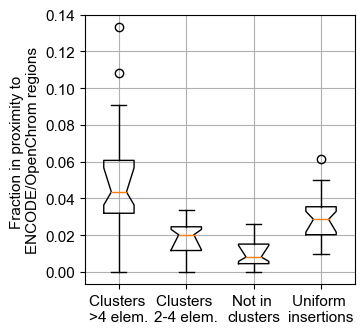

In [57]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)



ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_rd_1_mean],labels=["Clusters \n>4 elem.","Clusters \n2-4 elem.","Not in \nclusters", "Uniform \ninsertions"],showfliers=True,notch=True,bootstrap=10000)




plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())

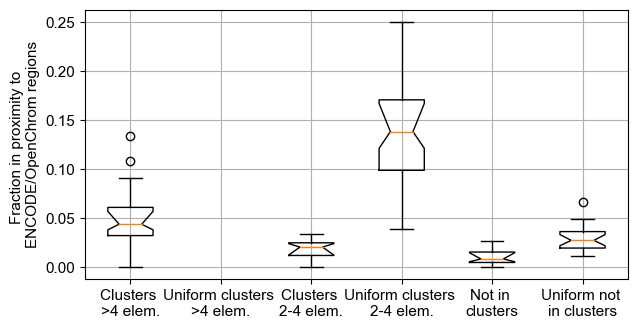

In [58]:
fig=plt.figure(figsize=(7,3.5))
ax1 = fig.add_subplot(111)



ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_rd_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_no_cluster_rd_1_mean],labels=["Clusters \n>4 elem.","Uniform clusters \n>4 elem.","Clusters \n2-4 elem.","Uniform clusters \n2-4 elem.","Not in \nclusters","Uniform not \nin clusters"],showfliers=True,notch=True,bootstrap=10000)




plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
#ax1.set_aspect(1./ax1.get_data_ratio())

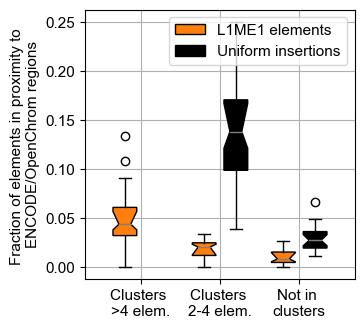

In [59]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)


x_pos=np.asarray([1,2,3])
bp_transposon=[mean_overlap_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean]
bp_hom_pos=[mean_overlap_rd_clusters_range_2_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_rd_1_mean]

#ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_rd_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_no_cluster_rd_1_mean],labels=["Clusters \n>4 elem.","Hom. clusters \n>4 elem.","Clusters \n2-4 elem.","Hom. clusters \n2-4 elem.","Not in \nclusters","Hom. not \nin clusters"],showfliers=True,notch=True,bootstrap=10000)

bp1=ax1.boxplot(bp_transposon,positions=x_pos-0.2,showfliers=True,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'tab:orange'},medianprops={'color': 'grey'})
bp2=ax1.boxplot(bp_hom_pos,positions=x_pos+0.2,showfliers=True,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'black'},medianprops={'color': 'grey'})


plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(x_pos,["Clusters \n>4 elem.","Clusters \n2-4 elem.","Not in \nclusters"],fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
plt.legend([bp1['boxes'][0], bp2['boxes'][0]], ['L1ME1 elements', 'Uniform insertions'],prop={'family': 'Arial','size': 11},loc="upper right")
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())

#plt.savefig("Transposon_analysis_1/figures/h_L1ME1_in_prox_ENCODE_3.pdf",format="pdf",bbox_inches="tight")


In [60]:
#stat sign. for clusters >4 elem.
#t_s, p_value_1=scipy.stats.mannwhitneyu(x=mean_overlap_clusters_range_2_mean,y=mean_overlap_rd_clusters_range_2_mean,alternative="two-sided")
#print(">4 elements:",p_value_1)
####################
#stat sign. for clusters 2-4 elem.
t_s, p_value_1=scipy.stats.mannwhitneyu(x=mean_overlap_clusters_range_1_mean,y=mean_overlap_rd_clusters_range_1_mean,alternative="two-sided")
print("2-4 elements:",p_value_1)
####################
#stat sign. not in clusters
t_s, p_value_1=scipy.stats.mannwhitneyu(x=mean_overlap_no_cluster_tr_1_mean,y=mean_overlap_no_cluster_rd_1_mean,alternative="two-sided")
print("not in clusters:",p_value_1)

2-4 elements: 6.6368856429973785e-09
not in clusters: 5.454580260645119e-07


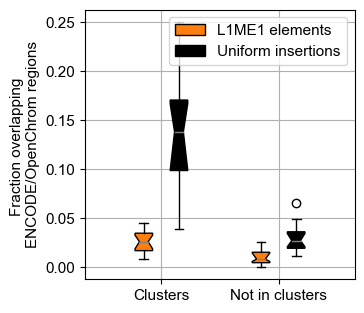

In [61]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)


x_pos=np.asarray([0,1])
bp_transposon=[mean_overlap_cluster_range_all_mean,mean_overlap_no_cluster_tr_1_mean]
bp_hom_pos=[mean_overlap_rd_cluster_range_all_mean,mean_overlap_no_cluster_rd_1_mean]

#ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_rd_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_no_cluster_rd_1_mean],labels=["Clusters \n>4 elem.","Hom. clusters \n>4 elem.","Clusters \n2-4 elem.","Hom. clusters \n2-4 elem.","Not in \nclusters","Hom. not \nin clusters"],showfliers=True,notch=True,bootstrap=10000)

bp1=ax1.boxplot(bp_transposon,positions=x_pos-0.15,showfliers=True,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'tab:orange'},medianprops={'color': 'grey'})
bp2=ax1.boxplot(bp_hom_pos,positions=x_pos+0.15,showfliers=True,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'black'},medianprops={'color': 'grey'})


plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(x_pos,["Clusters","Not in clusters"],fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
#plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction overlapping \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

plt.legend([bp1['boxes'][0], bp2['boxes'][0]], ['L1ME1 elements', 'Uniform insertions'],prop={'family': 'Arial','size': 11},loc="upper right")
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())

#plt.savefig("Transposon_analysis_1/figures/g_AluSq2_in_prox_ENCODE_4b.pdf",format="pdf",bbox_inches="tight")


In [62]:
#stat sign. for clusters 2-4 elem.
t_s, p_value_1=scipy.stats.mannwhitneyu(x=mean_overlap_cluster_range_all_mean,y=mean_overlap_rd_cluster_range_all_mean,alternative="two-sided")
print("in clusters:",p_value_1)
####################
#stat sign. not in clusters
t_s, p_value_1=scipy.stats.mannwhitneyu(x=mean_overlap_no_cluster_tr_1_mean,y=mean_overlap_no_cluster_rd_1_mean,alternative="two-sided")
print("not in clusters:",p_value_1)

in clusters: 9.185697615029324e-09
not in clusters: 5.454580260645119e-07


In [63]:
#lengths of transposon clusters (from beginning of first transposon of cluster to end of last transposon -> same result as other method before)
length_cluster_1=[]
for i in range(len(df_cluster_pos_3)):
    for index,row in df_cluster_pos_3[i][0].iterrows():
        length_e=row["STOP"]-row["START"]
        length_cluster_1.append(length_e)
    

 
print("mean length clusters 2-4:",np.mean(length_cluster_1))

length_cluster_2=[]
for i in range(len(df_cluster_pos_3)):
    for index,row in df_cluster_pos_3[i][1].iterrows():
        length_e=row["STOP"]-row["START"]
        length_cluster_2.append(length_e)
 
print("mean length clusters >4:",np.mean(length_cluster_2))

length_cluster_all=np.concatenate((length_cluster_1,length_cluster_2))
print("mean+std length all clusters:",np.mean(length_cluster_all),",",np.std(length_cluster_all))
print("max, min length all clusters:",np.max(length_cluster_all),",",np.min(length_cluster_all))

mean length clusters 2-4: 2492.9958029197082
mean length clusters >4: 7102.226035502958
mean+std length all clusters: 3579.41129707113 , 3461.7441694688323
max, min length all clusters: 31645 , 117


# Visualising distribution of transposons and open chromatin on chromosomes

In [64]:
#save elements and clusters for later use:

#with open ("Transposon_analysis_1/save_elements/AluSp_clusters_eps_e4_min_samples_2_V1.pkl","wb") as f:
    #pickle.dump(df_cluster_pos_3,f)
    
#with open ("Transposon_analysis_1/save_elements/AluSp_elements_V1.pkl","wb") as f:
    #pickle.dump(rmd_list_3,f)    

In [65]:
# load elements for use:

with open('Transposon_analysis_1/save_elements/AluSp_clusters_eps_e4_min_samples_2_V1.pkl', 'rb') as f:
    df_cluster_pos_load = pickle.load(f)
    

with open('Transposon_analysis_1/save_elements/AluSp_elements_V1.pkl', 'rb') as f:
    rmd_list_load = pickle.load(f)
    
        

In [66]:
#get acc peaks spilt into chrs
Chr_acc_peaks_sel1_split_by_chr=[Chr_acc_peaks_sel1[Chr_acc_peaks_sel1['chrom'] == chr_sel] for chr_sel in chr_list_3]

Chr_acc_peaks_sel1_split_by_chr

[      chrom  chromStart   chromEnd            name  score strand          6  \
 7      chr1      713850     714460         Valid_1   1000      .     713850   
 13     chr1      761903     763244         Valid_2   1000      .     761903   
 30     chr1      841391     842575         Valid_3   1000      .     841391   
 32     chr1      845956     847166         Valid_4   1000      .     845956   
 37     chr1      853094     853481         Valid_5   1000      .     853094   
 ...     ...         ...        ...             ...    ...    ...        ...   
 25189  chr1   247553370  247553810  OpenChrom_1125   1000      .  247553370   
 25193  chr1   247611316  247611741  OpenChrom_1126   1000      .  247611316   
 25237  chr1   248406521  248406810  OpenChrom_1127   1000      .  248406521   
 25290  chr1   249106366  249106815  OpenChrom_1128   1000      .  249106366   
 25307  chr1   249218884  249219215  OpenChrom_1129   1000      .  249218884   
 
                7        8      9  ...

In [67]:
#if transposon very short, lines in plot might not be visible, therefore use a minimum width
def return_minimum_width(ymin, ymax, min_length):
    
    if ymax - ymin < min_length:
        center = (ymax + ymin) / 2
        ymin = center - min_length / 2
        ymax = center + min_length / 2
    return ymin, ymax   

Chr: chr5 Genomic range: 69000000 - 69300000 BP


<Figure size 600x200 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

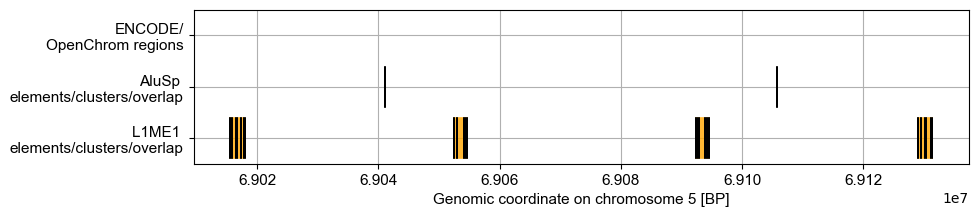

In [68]:
plot_chr=4
min_dist_plot=0

elements_1=rmd_list_3[plot_chr]
clusters_element_1=pd.concat([df_cluster_pos_3[plot_chr][0],df_cluster_pos_3[plot_chr][1]],axis=0)

elements_2=rmd_list_load[plot_chr]
clusters_element_2=pd.concat([df_cluster_pos_load[plot_chr][0],df_cluster_pos_load[plot_chr][1]],axis=0)

chr_acc=Chr_acc_peaks_sel1_split_by_chr[plot_chr]



plot_names=["L1ME1 \nelements/clusters/overlap","AluSp \nelements/clusters/overlap","ENCODE/\nOpenChrom regions"]




plot_range=[5.1*10**7,5.2*10**7]   #[5*10**7,5.5*10**7]

plot_range_start=np.asarray([1,2,3,4,5,6,7,8,9])*10**7
plot_range_stop=np.asarray([2,3,4,5,6,7,8,9,10])*10**7

plot_range_start=np.arange(1,10,0.1)*10**7
plot_range_stop=plot_range_start +0.03*10**7


plot_range_start=  [69000000] #[15920000] #
plot_range_stop= [69300000] #[16220000]   #
chr_acc_start=chr_acc["chromStart"].to_numpy()
chr_acc_stop=chr_acc["chromEnd"].to_numpy()
for k in range(len(plot_range_start)):
    
    fig=plt.figure(figsize=(6,2))
    fig=plt.figure(figsize=(20,5))
    fig=plt.figure(figsize=(10,2))
    
    ax1 = fig.add_subplot(111)

    plot_range=[plot_range_start[k],plot_range_stop[k]]
    
    plot_range_span=plot_range[1]-plot_range[0]
    
    
    min_width_line=plot_range_span/750
    
    
    print("Chr:",chr_list_3[plot_chr],"Genomic range:",plot_range[0],"-",plot_range[1], "BP")




    #plot clusters element 1
    for index, row in clusters_element_1.iterrows():

        elem_start=row["START"]
        elem_stop=row["STOP"]


        if plot_range[0]<=elem_start and elem_stop<=plot_range[1]:
            elem_start_b=elem_start#-1/50 *plot_range_span
            elem_stop_b=elem_stop#+1/50 *plot_range_span
            
            draw_start,draw_stop=return_minimum_width(ymin=elem_start_b, ymax=elem_stop_b, min_length=min_width_line)

            #check if cluster overlaps open chr:
            #chr_acc_start=chr_acc["chromStart"].to_numpy()
            #chr_acc_stop=chr_acc["chromEnd"].to_numpy()
            overlap_array=calc_overlap_V3(min1=elem_start_b,max1=elem_stop_b,min2=chr_acc_start,max2=chr_acc_stop)

            ax1.hlines(1,draw_start,draw_stop, linewidth=30,color="orange",alpha=0.8)

            if any(x > min_dist_plot for x in overlap_array):
                ax1.hlines(1,draw_start,draw_stop, linewidth=15,color="green",alpha=1)
                #print("!")

    #plot elements 1
    for index, row in elements_1.iterrows():

        elem_start=row["genoStart"]
        elem_stop=row["genoEnd"]


        if plot_range[0]<=elem_start and elem_stop<=plot_range[1]:
            elem_start_b=elem_start#-1/50 *plot_range_span
            elem_stop_b=elem_stop#+1/50 *plot_range_span
            
            draw_start,draw_stop=return_minimum_width(ymin=elem_start_b, ymax=elem_stop_b, min_length=min_width_line)

            #check if cluster overlaps open chr:
            #chr_acc_start=chr_acc["chromStart"].to_numpy()
            #chr_acc_stop=chr_acc["chromEnd"].to_numpy()
            overlap_array=calc_overlap_V3(min1=elem_start_b,max1=elem_stop_b,min2=chr_acc_start,max2=chr_acc_stop)

            ax1.hlines(1,draw_start,draw_stop, linewidth=30,color="black",alpha=1)

            if any(x > min_dist_plot for x in overlap_array):
                ax1.hlines(1,draw_start,draw_stop, linewidth=15,color="green",alpha=1)
                #print("!")

    ##########################
    ##########################
    ##########################




    #plot clusters element 2
    for index, row in clusters_element_2.iterrows():

        elem_start=row["START"]
        elem_stop=row["STOP"]


        if plot_range[0]<=elem_start and elem_stop<=plot_range[1]:
            elem_start_b=elem_start#-1/50 *plot_range_span
            elem_stop_b=elem_stop#+1/50 *plot_range_span
            
            draw_start,draw_stop=return_minimum_width(ymin=elem_start_b, ymax=elem_stop_b, min_length=min_width_line)

            #check if cluster overlaps open chr:
            #chr_acc_start=chr_acc["chromStart"].to_numpy()
            #chr_acc_stop=chr_acc["chromEnd"].to_numpy()
            overlap_array=calc_overlap_V3(min1=elem_start_b,max1=elem_stop_b,min2=chr_acc_start,max2=chr_acc_stop)

            ax1.hlines(2,draw_start,draw_stop, linewidth=30,color="orange",alpha=0.8)

            if any(x > min_dist_plot for x in overlap_array):
                ax1.hlines(2,draw_start,draw_stop, linewidth=15,color="green",alpha=1)
                #print("!")

    #plot elements 2
    for index, row in elements_2.iterrows():

        elem_start=row["genoStart"]
        elem_stop=row["genoEnd"]


        if plot_range[0]<=elem_start and elem_stop<=plot_range[1]:
            elem_start_b=elem_start#-1/50 *plot_range_span
            elem_stop_b=elem_stop#+1/50 *plot_range_span
            
            draw_start,draw_stop=return_minimum_width(ymin=elem_start_b, ymax=elem_stop_b, min_length=min_width_line)

            #check if cluster overlaps open chr:
            #chr_acc_start=chr_acc["chromStart"].to_numpy()
            #chr_acc_stop=chr_acc["chromEnd"].to_numpy()
            overlap_array=calc_overlap_V3(min1=elem_start_b,max1=elem_stop_b,min2=chr_acc_start,max2=chr_acc_stop)

            ax1.hlines(2,draw_start,draw_stop, linewidth=30,color="black",alpha=1)

            if any(x > min_dist_plot for x in overlap_array):
                ax1.hlines(2,draw_start,draw_stop, linewidth=15,color="green",alpha=1)
                #print("!")


    #plot open chr regions
    for index, row in chr_acc.iterrows():

        elem_start=row["chromStart"]
        elem_stop=row["chromEnd"]
        
        draw_start,draw_stop=return_minimum_width(ymin=elem_start_b, ymax=elem_stop_b, min_length=min_width_line)


        if plot_range[0]<=elem_start and elem_stop<=plot_range[1]:
            elem_start_b=elem_start#-1/50 *plot_range_span
            elem_stop_b=elem_stop#+1/50 *plot_range_span


            ax1.hlines(3,draw_start,draw_stop, linewidth=30,color="black",alpha=1)







    plt.ylim(0.5,3.5)
    plt.yticks([1,2,3],plot_names,fontname = "Arial",fontsize=11)
    plt.xticks(fontname = "Arial",fontsize=11) 
    #plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
    plt.xlabel("Genomic coordinate on chromosome 5 [BP]",fontname = "Arial",fontsize=11)
    plt.grid()
    #plt.savefig("Transposon_analysis_1/figures/chr5_section_69000000_69300000_L1ME1_AluSp_V1.pdf",format="pdf",bbox_inches="tight")
    plt.show()



# Size distribution of Transposons

## Functions

In [69]:
def t_size_distr_1(rmd_list_input):
    #get all sizes of transposons on each chromosome
    size_rmd_list_v1=[]
    for i in range(len(rmd_list_input)):
        size_rmd_list_v1.append( rmd_list_input[i][:]["genoEnd"].to_numpy()-rmd_list_input[i][:]["genoStart"].to_numpy()   )

    #append all sizes from each chromosome into one list
    size_rmd_list_v1_fl=[]
    for i in range(len(size_rmd_list_v1)):
        for j in range(len(size_rmd_list_v1[i])):
            size_rmd_list_v1_fl.append(size_rmd_list_v1[i][j])
            
    return size_rmd_list_v1,size_rmd_list_v1_fl

In [70]:
examples_rmd_3=rmd_3[rmd_3["repFamily"]=="L1"]

In [71]:
examples_rmd_3

genoName  genoStart    genoEnd     repName repClass  \
3                         chr1   50330063   50332153      L1PA10     LINE   
4                         chr1   58720067   58720973       L1PA2     LINE   
5                         chr1   75496180   75498100       L1MB7     LINE   
8                         chr1  117440426  117440514       L1ME1     LINE   
9                         chr1  117440494  117441457       L1ME1     LINE   
...                        ...        ...        ...         ...      ...   
5481309  chr21_gl000210_random       6396       6656       L1MB7     LINE   
5481314  chr21_gl000210_random       9359       9500       L1ME1     LINE   
5481316  chr21_gl000210_random      10059      10200       L1ME1     LINE   
5481339  chr21_gl000210_random      27296      27447  HAL1-2a_MD     LINE   
5481340  chr21_gl000210_random      27468      27682  HAL1-2a_MD     LINE   

        repFamily  
3              L1  
4              L1  
5              L1  
8              L1  
9              L1  
...           ...  
5481309        L1  
5481314        L1  
5481316        L1  
5481339        L1  
5481340        L1  

[987052 rows x 6 columns]

In [72]:
unique_examples_rmd_3 = [examples_rmd_3[col_name].unique() for col_name in examples_rmd_3.columns]

for i in unique_examples_rmd_3[3]:
    print(i)

L1PA10
L1PA2
L1MB7
L1ME1
L1PA7
L1PA3
L1ME2
L1MEc
L1MA9
L1MB3
L1PA8A
L1PA6
L1M2
HAL1
L1PA14
L1MA10
L1M1
L1ME3
L1PBa
L1PA15-16
L1M4
L1MDa
L1MC4
L1ME4a
L1MB8
L1MC
L1M3
L1MC1
L1PA5
L1PA4
L1MC3
L1M5
L1PA15
L1MA1
L1PA17
L1PB4
L1M4b
L1PB1
L1PA13
L1MB1
L1MA7
L1MB2
L1PA8
L1P1
L1MA3
HAL1b
L1MC2
L1MA2
L1MC4a
L1MC5
L1ME3A
L1MCc
L1PA16
L1MCa
L1ME5
L1MEe
L1MEf
L1ME3C
L1MD3
L1P4
L1MEd
L1P5
L1MA5
L1ME3D
L1MD
L1HS
L1MA8
L1PBa1
L1PA11
L1M4c
L1MA4A
L1MA4
L1ME3F
L1PREC2
L1MD1
L1MA6
L1MD2
L1PB3
L1MEg
L1MEg2
L1MB4
L1ME3B
L1M3e
L1M3a
L1MB5
L1PB
L1ME3E
L1M2c
L1M7
HAL1-3A_ME
L1ME2z
L1MEb
HAL1-2a_MD
L1PA12
L1MA5A
L1P2
L1PB2
L1P3
L1M6
L1M
L1MCb
L1P4a
L1M3f
L1M2a
L1P4e
L1M2b
L1MDb
L1M3c
L1MEg1
L1M3de
L1M3d
L1PBb
L1P3b
L1P4d
L1MEa
L1M2a1
L1M3b
L1P4b
L1P
L1P4c
HAL1N1_MD
L1MC5a
L1ME4b
X9_LINE
L1ME3G
L1ME4c
L1ME3Cz
L1MEj
L1M8
L1MEh
L1MEi
HAL1ME
L1M4a1
L1M4a2
HAL1M8
L1M6B


In [73]:
#select two transposons to compare size distribution
#no chrY to compare to HeLa cells
chr_list_size_1=["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15","chr16",
         "chr17","chr18","chr19","chr20","chr21","chr22","chrX"
         ]

element_sel_size_1="L1ME1" #"MamRep1527"  #"MamRep1527" #"L1ME1" #"AluSp"

element_sel_size_2="AluSp" #"MamRep1527"  #"MamRep1527" #"L1ME1" #"AluSp"   #"FRAM" #"HAL1-3A_ME"

In [74]:
rmd_list_size_1= sel_rep_element_on_chr_2(rmd_1=rmd_3,chr_list=chr_list_size_1,elements_name=element_sel_size_1,chr_col_name="genoName",element_col_name="repName")

In [75]:
rmd_list_size_2= sel_rep_element_on_chr_2(rmd_1=rmd_3,chr_list=chr_list_size_1,elements_name=element_sel_size_2,chr_col_name="genoName",element_col_name="repName")

In [76]:
tr_len_size_1,tr_len_size_1_fl=t_size_distr_1(rmd_list_size_1)

In [77]:
tr_len_size_2,tr_len_size_2_fl=t_size_distr_1(rmd_list_size_2)

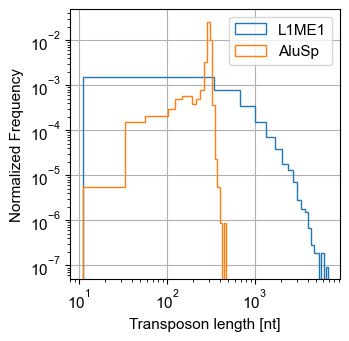

In [80]:


fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)

size_hist_v1=plt.hist(tr_len_size_1_fl,density=True,label="L1ME1",histtype="step",bins=20)
size_hist_v2=plt.hist(tr_len_size_2_fl,density=True,label="AluSp",histtype="step",bins=20)

plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Normalized Frequency",fontname = "Arial",fontsize=11)
plt.xlabel("Transposon length [nt]",fontname = "Arial",fontsize=11)

plt.xscale("log")
plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())

In [79]:
print("Mean, std. transposon length type 1:", np.mean(tr_len_size_1_fl),",",np.std(tr_len_size_1_fl),)
print("Mean, std. transposon length type 2:", np.mean(tr_len_size_2_fl),",",np.std(tr_len_size_2_fl))

Mean, std. transposon length type 1: 480.5730630716767 , 471.1156556669817
Mean, std. transposon length type 2: 288.9286871961102 , 43.1633157680467
